Input the pickle file, then fit the model in different conditions- acute versus chronic, high diversity vs low diversity of trauma.

In [2]:
import codecs
import sklearn
import glob
import os
import time
import re
from datetime import datetime
import multiprocessing as mp
from multiprocessing import Pool
import pickle
import pandas as pd
import numpy as np
from scipy import optimize
import scipy as sp
from scipy import stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
#import pymc as pt

In [ ]:
def load_workspace(filename):
 with open(filename, 'rb') as f:
  data_loaded = pickle.load(f)
 return data_loaded
 data = load_workspace('data/pklForTheo.pkl')

In [ ]:
 data = load_workspace('data/pklForTheo.pkl')

In [37]:

out_dir = os.path.join(os.getcwd(), "exports", "csv")
os.makedirs(out_dir, exist_ok=True)

keys = ['rwlrnEstArr','rwlrnOCArr','rwlrnSumm','lrnEstArr','lrnOCArr','lrnSumm','subjs','qDat','SummScores','rwlrnDat', 'lrnDat']

for k in keys:
    if 'data' in globals() and k in data:
        obj = data[k]
        fname = os.path.join(out_dir, f"{k}.csv")
        try:
            if hasattr(obj, "to_csv"):
                obj.to_csv(fname, index=False)
            else:
                pd.DataFrame(obj).to_csv(fname, index=False)
            print(f"Saved {k} -> {fname}")
        except Exception as e:
            print(f"Failed to save {k}: {e}")
    else:
        print(f"Key not found in data: {k}")

Saved rwlrnEstArr -> /Users/blhlabadmin/Desktop/IPTSocialLearningDecision/notebooks/exports/csv/rwlrnEstArr.csv
Saved rwlrnOCArr -> /Users/blhlabadmin/Desktop/IPTSocialLearningDecision/notebooks/exports/csv/rwlrnOCArr.csv
Saved rwlrnSumm -> /Users/blhlabadmin/Desktop/IPTSocialLearningDecision/notebooks/exports/csv/rwlrnSumm.csv
Saved lrnEstArr -> /Users/blhlabadmin/Desktop/IPTSocialLearningDecision/notebooks/exports/csv/lrnEstArr.csv
Saved lrnOCArr -> /Users/blhlabadmin/Desktop/IPTSocialLearningDecision/notebooks/exports/csv/lrnOCArr.csv
Saved lrnSumm -> /Users/blhlabadmin/Desktop/IPTSocialLearningDecision/notebooks/exports/csv/lrnSumm.csv
Saved subjs -> /Users/blhlabadmin/Desktop/IPTSocialLearningDecision/notebooks/exports/csv/subjs.csv
Saved qDat -> /Users/blhlabadmin/Desktop/IPTSocialLearningDecision/notebooks/exports/csv/qDat.csv
Key not found in data: SummScores
Saved rwlrnDat -> /Users/blhlabadmin/Desktop/IPTSocialLearningDecision/notebooks/exports/csv/rwlrnDat.csv
Saved lrnDat -

In [46]:
def load_saved_csvs(out_dir=None, keys=None, assign=False):
    import os, pandas as pd
    out_dir = out_dir or os.path.join(os.getcwd(), "exports", "csv")
    keys = keys or ['rwlrnEstArr','rwlrnOCArr','rwlrnSumm','lrnEstArr','lrnOCArr','lrnSumm']
    dfs = {k: pd.read_csv(os.path.join(out_dir, f"{k}.csv")) for k in keys if os.path.exists(os.path.join(out_dir, f"{k}.csv"))}
    if assign:
        globals().update(dfs)
    return dfs

In [50]:
def quick_diag_rwlrn(data, n=10):
    bad=[]
    for i,x in enumerate(data.get('rwlrnDat',[])):
        if not isinstance(x,(dict,list,pd.DataFrame,np.ndarray)):
            bad.append((i,type(x),repr(x)[:120]))
    print(len(bad), bad[:n])

In [51]:
quick_diag_rwlrn(data)

1 [(0, <class 'str'>, "'0'")]


In [39]:
data = load_saved_csvs()

In [40]:
def my_pearsonr(x,y):
    return stats.pearsonr(x,y)[0]
# Generate RL model predictions given outcomes, a learning rate and an initial prediction
#assumes outcomes is a DataFrame, cols=number of trials, rows = number of learning instances
# returns predictions as an np.array with the same shape as outcomes.

def genModelPreds(outcomes,lr,p0):
    pred = np.zeros(outcomes.shape)
    pred[:,0] = p0
    for ii in range(outcomes.shape[1]-1):
        pred[:,ii+1] = pred[:,ii] + lr * (np.array(outcomes.iloc[:,ii]) - pred[:,ii])
    return pred           

def genModelPreds_biasOC_d(outcomes,lr,d,p0):
    outcomes=np.array(outcomes)

    ocsDf = np.zeros(outcomes.shape)
    ocsDf[outcomes==-1]=-d
    ocsDf[outcomes==1]=1-d
        
    pred = np.zeros(outcomes.shape)
    pred[:,0] = p0
    for ii in range(outcomes.shape[1]-1):
        pred[:,ii+1] = pred[:,ii] + lr * (ocsDf[:,ii] - pred[:,ii])
    return pred 

def genModelPreds_biasOC_2LR(outcomes,lr_pos,lr_neg,p0):
    outcomes=np.array(outcomes)

    lrsDf = np.zeros(outcomes.shape)
    lrsDf[outcomes==0]=lr_neg
    lrsDf[outcomes==1]=lr_pos
        
    pred = np.zeros(outcomes.shape)
    pred[:,0] = p0
    for ii in range(outcomes.shape[1]-1):
        pred[:,ii+1] = pred[:,ii] + lrsDf[:,ii] * (outcomes[:,ii] - pred[:,ii])
    return pred 



def genModelPreds_biasOC_2LR_SW(data, lr_pre, lr_post, p0, d):
    data = data.copy()
    data= data.apply(pd.to_numeric, errors='coerce')
    data = data.astype(int)*2-1

    outcome_rows = [r for r in data.index if not r.startswith('sw_')]
    switch_rows = [r for r in data.index if r.startswith('sw_')]


    outcomes = data.loc[outcome_rows].to_numpy()
    switch_phase = data.loc[switch_rows].to_numpy()
    ocsDf = np.zeros(outcomes.shape)
    ocsDf[outcomes == -1] = -d
    ocsDf[outcomes == 1] = 1 - d
    
    lrsDf = np.zeros(outcomes.shape)
    lrsDf[switch_phase == 0] = lr_pre
    lrsDf[switch_phase == 1] = lr_post
        
    pred = np.zeros(outcomes.shape)
    pred[:,0] = p0
    for ii in range(outcomes.shape[1]-1):
        pred[:,ii+1] = pred[:,ii] + lrsDf[:,ii] * (ocsDf[:,ii] - pred[:,ii])
    return pred


def calcActProbs(modelPreds, sftmax, chVals=np.arange(5)+1):
    preds=np.array(modelPreds)
    EVs=[preds*i+(1-preds)*-i for i in chVals]
    expEVs_sftmax=[np.exp(np.float64(i)/sftmax) for i in EVs]
    sftmax_denom=np.zeros(expEVs_sftmax[0].shape)
    for i in expEVs_sftmax:
        sftmax_denom+=i
    cols=['ch_{:02d}'.format(i) for i in np.arange(modelPreds.shape[1])+1]
    actProbArr=[pd.DataFrame(i/sftmax_denom, columns=cols) for i in expEVs_sftmax]
    
    return actProbArr
#pt = pytensor
def choiceprob (theta, u): #probability calculation #cumulative probability 
    p_cum_2 = 1/(1+pt.exp(-theta (u[:, :, 1] + u[:, :, 2]+ u[:,:, 3] + u[:, :, 4]- u[:, :, 0]))) #p of choosing 2-5 over 1 # shape (n_sub, 18)
    p_cum_3 = 1/(1+ pt.exp(-theta (u[:,:, 2]+ u[:, :, 3] + u[:, :, 4]- u[:,:, 0] - u[:,:, 1]))) #p of choosing 3-5 over 1-2 
    p_cum_4 = 1/(1+ pt.exp(-theta (u[:,:, 3] + u[:, :, 4] - u[:,:, 0]- u[:, :, 1] - u[:, :, 2]))) #p of choosing 4-5 over 1-3 #probability for each trial & option p_11 
    p_cum_5 = 1 /(1+ pt.exp(-theta (u[:,:, 4]- u[:,:, 0]- u[:, :, 1]- u[:, :, 2] - u[:, :, 3]))) #p of choosing 5 over 1-5 #probability for each trial & option p_11 
    p_1 = 1- p_cum_2 
    p_2= p_cum_2 - p_cum_3 
    p_3= p_cum_3 - p_cum_4 
    p_4= p_cum_4 - p_cum_5
    p_5= p_cum_5
    
    p = pt.stack([p_1, p_2, p_3, p_4,p_5], axis=2) # shape (n_sub, 18, 4) return p

def calcActProbsPosNegOC(modelPreds, sftmax, chVals=np.arange(5)+1):
    preds=np.array(modelPreds)
    EVs=[preds*i for i in chVals]
    expEVs_sftmax=[np.exp(np.float64(i)/sftmax) for i in EVs]
    sftmax_denom=np.zeros(expEVs_sftmax[0].shape)
    for i in expEVs_sftmax:
        sftmax_denom+=i
    cols=['ch_{:02d}'.format(i) for i in np.arange(modelPreds.shape[1])+1]
    actProbArr=[pd.DataFrame(i/sftmax_denom, columns=cols) for i in expEVs_sftmax]
    return actProbArr

def genChoices(actProbArr):
    probCh=[np.zeros(actProbArr[0].shape)]
    choices=np.random.random_sample(actProbArr[0].shape)
    for i in range(len(actProbArr)):
        probCh.append(probCh[-1]+actProbArr[i])
        choices[choices<probCh[-1]]=i+1
    
    return choices#, probCh


def calcNegLogLike(choices, actProbs):
    choices.reset_index(inplace=True, drop=True)
    chProbs=choices.copy()
    for i in np.arange(len(actProbs)):
        chProbs[choices==i+1]=actProbs[i][choices==i+1]
    
    chProbs[chProbs==0]=np.nan
    nll=-np.log(np.float64(chProbs))
    np.nan_to_num(nll, copy=False)
    nll=np.sum(nll, axis=1)
    
    return nll, chProbs

def chanceLikelihood(choices, chanceP=0.2):
    choices.reset_index(inplace=True, drop=True)
    chProbs=choices.copy()
    
    chProbs[chProbs!=0]=chanceP
    chProbs[chProbs==0]=np.nan
    nll=-np.log(np.float64(chProbs))
    np.nan_to_num(nll, copy=False)
    nll=np.sum(nll, axis=1)
    
    return nll



def genBetaParams(mu=0.3, sd=0.05):
    alpha=((1-mu)/sd**2 - 1/mu )*mu**2
    beta=alpha*(1/mu-1)
    
    return alpha, beta

def betaMuSd(mu=0.3, sd=0.05, N=1):
    alpha=((1-mu)/sd**2 - 1/mu )*mu**2
    beta=alpha*(1/mu-1)
    
    return np.random.beta(alpha, beta,N)


#single LR sofented with sigmoid and single SM model
def optimizeLR_sft(params, choices, outcomes):
    lrp,sm=params
    lr=np.exp(lrp)/(np.exp(lrp)+1)
    if np.any(np.array((lr,sm))<0) or lr>1:
        nLL=10e30
        return nLL
     
    mod=genModelPreds(outcomes,lr,initPred)
    actProbs=calcActProbs(mod, sm)
    nLL, chProbs=calcNegLogLike(choices, actProbs)
    
    return np.sum(nLL)


#single LR sofented with sigmoid and fixed SM model
def optimizeLR_sft_fixedSM(params, choices, outcomes, smax=1, initPred=.5):
    lrp=params
    lr=np.exp(lrp)/(np.exp(lrp)+1)
    if lr<0 or smax<0 or lr>1:
        nLL=10e30
        return nLL
     
    mod=genModelPreds(outcomes,lr,initPred)
    actProbs=calcActProbs(mod, smax)
    nLL, chProbs=calcNegLogLike(choices, actProbs)
    
    return np.sum(nLL)

#single LR sofented with sigmoid and fixed SM model
def optimizeLR_sft_fixedSM_posNegOC(params, choices, outcomes, smax=1, initPred=0):
    lrp,d=params
    lr=np.exp(lrp)/(np.exp(lrp)+1)
    d=np.exp(d)/(np.exp(d)+1) #if softening d
    if lr<0 or smax<0 or lr>1:
        nLL=10e30
        return nLL
     
    mod=genModelPreds_biasOC_d(outcomes,lr,d,initPred)
    actProbs=calcActProbsPosNegOC(mod, smax)
    nLL, chProbs=calcNegLogLike(choices, actProbs)
    
    return np.sum(nLL)

#single LR sofented with sigmoid and biasedOC with sigmoid and p0 with no sigmoid, + fixed SM model
def optimizeLR_sft_fixedSM_posNegOC_p0(params, choices, outcomes, smax=1):
    lrp,d, p0=params
    lr=np.exp(lrp)/(np.exp(lrp)+1)
    d=np.exp(d)/(np.exp(d)+1) #if softening d
    p0=(np.exp(p0)/(np.exp(p0)+1))*2-1 #if softening d
    if lr<0 or smax<0 or lr>1:
        nLL=10e30
        return nLL
     
    mod=genModelPreds_biasOC_d(outcomes,lr,d,p0)
    actProbs=calcActProbsPosNegOC(mod, smax)
    nLL, chProbs=calcNegLogLike(choices, actProbs)
    
    return np.sum(nLL)


#pre and post switch LRS
def optimize2LR_sft_fixedSM_posNegOC_p0_switch(params, choices, outcomes, smax=1):
    lr_pre, lr_post, d, p0 =params
    lr_pre=np.exp(lr_pre)/(np.exp(lr_pre)+1)
    lr_post=np.exp(lr_post)/(np.exp(lr_post)+1)
    d=np.exp(d)/(np.exp(d)+1) #if softening d
    p0=(np.exp(p0)/(np.exp(p0)+1))*2-1 #if softening p0
    if lr_post<0 or lr_pre<0 or smax<0 or lr_post>1 or lr_pre>1:
        nLL=10e30
        return nLL
     
    mod=genModelPreds_biasOC_2LR_SW(outcomes,lr_pre,lr_post,p0,d)
    actProbs=calcActProbsPosNegOC(mod, smax)
    nLL, chProbs=calcNegLogLike(choices, actProbs)
    
    return np.sum(nLL)



#double LR sofented with sigmoid and fixed SM model
def optimize2LR_sft_fixedSM(params, choices, outcomes, smax=1, initPred=.5):
    lr_pos, lr_neg=params
    lr_pos=np.exp(lr_pos)/(np.exp(lr_pos)+1)
    lr_neg=np.exp(lr_neg)/(np.exp(lr_neg)+1)
    if lr_pos<0 or lr_neg<0 or smax<0 or lr_pos>1 or lr_neg>1:
        nLL=10e30
        return nLL
     
    mod=genModelPreds_biasOC_2LR(outcomes,lr_pos, lr_neg,initPred)
    actProbs=calcActProbs(mod, smax)
    nLL, chProbs=calcNegLogLike(choices, actProbs)
    
    return np.sum(nLL)


def optimize2LR_sft_fixedSM_p0(params, choices, outcomes, smax=1):
    lr_pos, lr_neg, p0=params
    lr_pos=np.exp(lr_pos)/(np.exp(lr_pos)+1)
    lr_neg=np.exp(lr_neg)/(np.exp(lr_neg)+1)
    p0=(np.exp(p0)/(np.exp(p0)+1))*2-1 #p0 with no sigmoid? confused abt this
    if lr_pos<0 or lr_neg<0 or smax<0 or lr_pos>1 or lr_neg>1:
        nLL=10e30
        return nLL
     
    mod=genModelPreds_biasOC_2LR(outcomes,lr_pos, lr_neg,p0)
    actProbs=calcActProbs(mod, smax)
    nLL, chProbs=calcNegLogLike(choices, actProbs)
    
    return np.sum(nLL)

# assuming shared variance only affects LR
# COV_1LR: Participant data will be fit with a single learning rate intercept (alpha_INT), one or more covariate parameters (e.g.,
# alpha_COV_PC_BPD_comm_PTSD and alpha_COV_PC_BPD_uniq_PTSD), and a single inverse temperature (beta), all at the group-level. Expected
# probability of partner sharing or lottery generating a win (p(0)) will be initialized to 0.5.
def optimize_1lr_PCA_2W(params, choices, outcomes, pca_vec, smax=1, initPred=0.5):
    """
    params = [alpha_INT, alpha_COV_pc1, alpha_COV_pc2]
      - all are group-level coefficients on the *logit* scale
    pca_vec = [z_pc1, z_pc2] for THIS participant
    """
    alpha_INT, w1, w2 = params

    # the group level intercept + covariate contributions 
    x_alpha = alpha_INT + w1 * pca_vec[0] + w2 * pca_vec[1]

    # map to (0,1)
    lr = np.exp(x_alpha) / (np.exp(x_alpha) + 1)

    # generate predictions 
    mod = genModelPreds(outcomes, lr, initPred)

    # softmax and NLL using your helpers
    actProbs = calcActProbs(mod, smax)
    nLL, _ = calcNegLogLike(choices, actProbs)

    return np.sum(nLL)

#with only the shared PC 
def optimize_1lr_PCA_1W(params, choices, outcomes, pca_vec, smax=1, initPred=0.5):
    """
    params = [alpha_INT, alpha_COV_pc1, alpha_COV_pc2]
      - all are group-level coefficients on the *logit* scale
    pca_vec = [z_pc1, z_pc2] for THIS participant
    """
    alpha_INT, w1 = params
    # predictor for learning rate
    x_alpha = alpha_INT + w1 * pca_vec[0]
    # map to (0,1)
    lr = np.exp(x_alpha) / (np.exp(x_alpha) + 1)
    # generate predictions 
    mod = genModelPreds(outcomes, lr, initPred)
    # softmax and NLL using your helpers
    actProbs = calcActProbs(mod, smax)
    nLL, _ = calcNegLogLike(choices, actProbs)
    return np.sum(nLL)

# PTP_LR+COV_p0: For each participant, data will be fit with a single participant-level learning rate (alpha(ptp)) at the participant level, as well as a
# single p0 intercept (p0_INT), one or more covariate parameters (e.g., p0_COV_PC_BPD_comm_PTSD and p0_COV_PC_BPD_uniq_PTSD), and a single
# inverse temperature (beta), all at the group-level.
def optimize_1lr_p0_PCA_2W(params, choices, outcomes, pca_vec, smax=1):
    """
    params = [alpha_INT, alpha_COV_pc1, alpha_COV_pc2]
      - all are group-level coefficients on the *logit* scale
    pca_vec = [z_pc1, z_pc2] for THIS participant
    """
    w1, w2, p0_INT = params

    # latent (real-line) predictor for learning rate
    x_p0 = p0_INT + w1 * pca_vec[0] + w2 * pca_vec[1]

    x_p0=(np.exp(p0)/(np.exp(p0)+1))*2-1
    # generate predictions 
    mod = genModelPreds(outcomes, x_p0)

    # softmax and NLL using your helpers
    actProbs = calcActProbs(mod, smax)
    nLL, _ = calcNegLogLike(choices, actProbs)

    return np.sum(nLL)

# COV_2LR MODEL: Participant data will be fit with two group-level learning rate intercepts (alpha_OC+_INT, alpha_OC-_INT), each of which will be
# paired with one or more group-level covariate parameters (e.g., alpha_OC+_COV_PC_BPD_comm_PTSD and alpha_OC+_COV_PC_BPD_uniq_PTSD),
# and a single group-level inverse temperature (beta). Expected probability of partner sharing or lottery generating a win (p(0)) will be initialized to
# 0.5..

def optimize_2lr_PCA_1W(params, choices, outcomes, pca_vec, smax=1, initPred=0.5):
    """
    params = [alpha_INT, alpha_COV_pc1, alpha_COV_pc2]
      - all are group-level coefficients on the *logit* scale
    pca_vec = [z_pc1, z_pc2] for THIS participant
    """
    alpha_OC_POS_INT, alpha_OC_NEG_INT, w1 = params

    # the group level intercept + covariate contributions 
    x_alpha_1 = (alpha_OC_POS_INT+ (w1 * pca_vec[0])) 
    x_alpha_2 = (alpha_OC_NEG_INT+ (w1 * pca_vec[0]))
    # map to (0,1)
    lr_pos = np.exp(x_alpha_1) / (np.exp(x_alpha_1) + 1)
    lr_neg = np.exp(x_alpha_2) / (np.exp(x_alpha_2) + 1)
    # generate predictions 
    mod = genModelPreds_biasOC_2LR(outcomes, lr_pos, lr_neg, initPred)

    # softmax and NLL using your helpers
    actProbs = calcActProbs(mod, smax)
    nLL, _ = calcNegLogLike(choices, actProbs)

    return np.sum(nLL)
# COV_2LR+PTP_p0 MODEL: Participant data will be fit with two group-level learning rate intercepts (alpha_OC+_INT, alpha_OC-_INT), each of which
# will be paired with one or more group-level covariate parameters (e.g., alpha_OC+_COV_PC_BPD_comm_PTSD and
# alpha_OC+_COV_PC_BPD_uniq_PTSD), a single participant-level initial expectation (p0(ptp)), and a single group-level inverse temperature (beta).
def optimize_2lr_p0_PCA_1W(params, choices, outcomes, pca_vec, smax=1):
    """
    params = [alpha_INT, alpha_COV_pc1, alpha_COV_pc2]
      - all are group-level coefficients on the *logit* scale
    pca_vec = [z_pc1, z_pc2] for THIS participant
    """
    alpha_OC_POS_INT, alpha_OC_NEG_INT, w1, p0 = params

    # the group level intercept + covariate contributions 
    x_alpha_1 = (alpha_OC_POS_INT+ (w1 * pca_vec[0])) 
    x_alpha_2 = (alpha_OC_NEG_INT+ (w1 * pca_vec[0]))
    # map to (0,1)
    lr_pos = np.exp(x_alpha_1) / (np.exp(x_alpha_1) + 1)
    lr_neg = np.exp(x_alpha_2) / (np.exp(x_alpha_2) + 1)

    p0=(np.exp(p0)/(np.exp(p0)+1))*2-1

    # generate predictions 
    mod = genModelPreds_biasOC_2LR(outcomes, lr_pos, lr_neg, p0)

    # softmax and NLL using your helpers
    actProbs = calcActProbs(mod, smax)
    nLL, _ = calcNegLogLike(choices, actProbs)

    return np.sum(nLL)

# COV_2LR+PTP_p0 MODEL: Participant data will be fit with two group-level learning rate intercepts (alpha_OC+_INT, alpha_OC-_INT), each of which
# will be paired with one or more group-level covariate parameters (e.g., alpha_OC+_COV_PC_BPD_comm_PTSD and
# alpha_OC+_COV_PC_BPD_uniq_PTSD), as well as a single group-level p0 intercept (p0_INT), one or more group-level covariate parameters (e.g.,
# p0_COV_PC_BPD_comm_PTSD and p0_COV_PC_BPD_uniq_PTSD), and a single group-level inverse temperature (beta).

def optimize_2lr_p0_PCA_1W(params, choices, outcomes, pca_vec, smax=1):
    """
    params = [alpha_INT, alpha_COV_pc1, alpha_COV_pc2]
      - all are group-level coefficients on the *logit* scale
    pca_vec = [z_pc1, z_pc2] for THIS participant
    """
    alpha_OC_POS_INT, alpha_OC_NEG_INT, w1, p0 = params

    # the group level intercept + covariate contributions 
    x_alpha_1 = (alpha_OC_POS_INT+ (w1 * pca_vec[0])) 
    x_alpha_2 = (alpha_OC_NEG_INT+ (w1 * pca_vec[0]))
    # map to (0,1)
    lr_pos = np.exp(x_alpha_1) / (np.exp(x_alpha_1) + 1)
    lr_neg = np.exp(x_alpha_2) / (np.exp(x_alpha_2) + 1)

    p0=(np.exp(p0)/(np.exp(p0)+1))*2-1

    # generate predictions 
    mod = genModelPreds_biasOC_2LR(outcomes, lr_pos, lr_neg, p0)

    # softmax and NLL using your helpers
    actProbs = calcActProbs(mod, smax)
    nLL, _ = calcNegLogLike(choices, actProbs)

    return np.sum(nLL)

    
def neg_loglik_cov_1lr(params, trials, covs):
    """
    params = [alpha_INT, alpha_COV_comm, alpha_COV_uniq, log_beta]
    trials: dataframe-like subsettable by pid with choice/outcome columns
    covs:   dataframe-like indexed by pid with z_comm, z_uniq
    """
    alpha_INT, aC_comm, aC_uniq, log_beta = params
    beta = np.exp(log_beta)  # enforce beta > 0

    nll = 0.0

    for pid in trials["pid"].unique():
        z_comm = covs.loc[pid, "z_comm"]
        z_uniq = covs.loc[pid, "z_uniq"]

        # participant-specific learning rate implied by covariates
        x_alpha = alpha_INT + aC_comm * z_comm + aC_uniq * z_uniq
        alpha_i = sigmoid(x_alpha)

        # initialize belief
        p = 0.5

        # iterate trials for this participant in order, doing it without the prebuilt functions for my own clarity
        df_i = trials[trials["pid"] == pid].sort_values("trial_index")
        for _, row in df_i.iterrows():
            a = int(row["choice"])          # 1..5
            oc = int(row["outcome"])        # 0/1

            # compute EVs for all actions 1..5
            actions = np.arange(1, 6)
            EV = p * actions + (1 - p) * (-actions)  # = actions*(2p-1)

            # softmax over actions
            logits = EV / beta
            logits -= np.max(logits)  # numerical stability
            probs = np.exp(logits)
            probs /= probs.sum()

            # accumulate negative log-likelihood of chosen action
            p_choice = probs[a - 1]
            nll -= np.log(p_choice + 1e-12)

            # RW update
            pe = oc - p
            p = p + alpha_i * pe

    return nll


def hrarchFit_gSMbrute_iLRmin(smaxRange, chDf, ocDf, lrRange=np.linspace(-10,10,5)):
    # timer=time.time()
    smax_nll=np.inf
    # print(smaxRange)
    for smax in smaxRange:
        fit_lrDF=pd.DataFrame(index=chDf.PID.unique(), columns=chDf.cond.unique(), data=np.nan)    
        nllDF=pd.DataFrame(index=chDf.PID.unique(), columns=chDf.cond.unique(), data=np.inf)
        for PID in chDf.PID.unique():
            for cond in chDf.cond.unique():
                lr_nll = np.inf
                for lr in lrRange:

                    result=sp.optimize.minimize(optimizeLR_sft_fixedSM, (lr,),(chDf.loc[(chDf.PID==PID)&(chDf.cond==cond),'ch_01':], ocDf.loc[(ocDf.PID==PID)&(ocDf.cond==cond), 'oc_01':],smax),bounds=((-10,10),))

                    if result.fun < lr_nll:
                        lr_nll = result.fun
                        lr_val = result.x[0]
                if lr_nll < nllDF.loc[PID,cond]:
                    nllDF.loc[PID,cond]=lr_nll
                    fit_lrDF.loc[PID,cond]=np.exp(lr_val)/(np.exp(lr_val)+1)

        if nllDF.sum().sum() < smax_nll:
            smax_nll=nllDF.sum().sum()
            bestSM = smax
            bestLR = fit_lrDF.copy()

        # print('sm{} finished at: {:02f}'.format(smax,time.time()-timer))
        
    return (bestSM, bestLR)


def tiered_hrarchFit_gSMbrute_iLRmin(chDF, ocDF):
    timer=time.time()
    SML1,_ =hrarchFit_gSMbrute_iLRmin(np.linspace(0,20,6), chDF, ocDF)
    if SML1==0:
        SML2,_ =hrarchFit_gSMbrute_iLRmin(np.linspace(0,4,5), chDF, ocDF)
    else:
        SML2,_ =hrarchFit_gSMbrute_iLRmin(np.linspace(SML1-4,SML1+4,9), chDF, ocDF)

    if SML2==0:
        SML3,_ =hrarchFit_gSMbrute_iLRmin(np.linspace(0,1.2,4), chDF, ocDF)
    else:
        SML3,_ =hrarchFit_gSMbrute_iLRmin(np.linspace(SML2-1,SML2+1,6), chDF, ocDF)

    if SML3==0:
        SML4,_ =hrarchFit_gSMbrute_iLRmin(np.linspace(0,.4,5), chDF, ocDF)
    else:
        SML4,_ =hrarchFit_gSMbrute_iLRmin(np.linspace(SML3-.4,SML3+.4,9), chDF, ocDF)

    if SML4==0:
        SML5,_ =hrarchFit_gSMbrute_iLRmin(np.linspace(0,.12,4), chDF, ocDF)
    else:
        SML5,_ =hrarchFit_gSMbrute_iLRmin(np.linspace(SML4-.1,SML4+.1,6), chDF, ocDF)

    if SML5==0:
        SML6,fit_lrDF =hrarchFit_gSMbrute_iLRmin(np.linspace(0,.04,5), chDF, ocDF)
    else:
        SML6,fit_lrDF =hrarchFit_gSMbrute_iLRmin(np.linspace(SML5-.04,SML5+.04,9), chDF, ocDF)
    
    print('final sm: {} finished at: {:02f}'.format(SML6,time.time()-timer))
    
    return SML6,fit_lrDF

def bootstrap_correlation_ci(series1, series2, n_bootstraps=10000, ci=95):
    indices = np.arange(len(series1))
    correlations = []
    
    for _ in range(n_bootstraps):
        boot_indices = np.random.choice(indices, size=len(indices), replace=True)
        boot_series1 = series1[boot_indices]
        boot_series2 = series2[boot_indices]
        r, _ = stats.pearsonr(boot_series1, boot_series2)
        correlations.append(r)
    
    lower = np.percentile(correlations, (100 - ci) / 2)
    upper = np.percentile(correlations, 100 - (100 - ci) / 2)
    return lower, upper

# And update your function definition to:
def bootstrap_mean_ci(series, n_bootstraps=1000, ci=95):
    means = []
    indices = np.arange(len(series))
    for _ in range(n_bootstraps):
        boot_indices = np.random.choice(indices, size=len(indices), replace=True)
        boot_series = series.iloc[boot_indices]
        means.append(np.mean(boot_series))
    lower = np.percentile(means, (100 - ci) / 2)
    upper = np.percentile(means, 100 - (100 - ci) / 2)
    return lower, upper

def sigmoid(x,a,b,c):
    y=a+b/(1+np.exp(-c*(x-50)))

    return y

In [41]:
# ...existing code...
def load_saved_csvs(out_dir=None, keys=None, assign=False):
    import os, pandas as pd
    out_dir = out_dir or os.path.join(os.getcwd(), "exports", "csv")
    keys = keys or ['rwlrnEstArr','rwlrnOCArr','rwlrnSumm','lrnEstArr','lrnOCArr','lrnSumm','subjs','qDat','SummScores','rwlrnDat', 'lrnDat']
    dfs = {k: pd.read_csv(os.path.join(out_dir, f"{k}.csv")) for k in keys if os.path.exists(os.path.join(out_dir, f"{k}.csv"))}
    if assign:
        globals().update(dfs)
    return dfs

data = load_saved_csvs()

In [ ]:
def diagnose_rwlrnDat(data, n_preview=120):
    for i,x in enumerate(data.get('rwlrnDat', [])):
        t,type_repr = type(x), getattr(x, "shape", None)
        print(i, t, f"shape={type_repr}" if type_repr is not None else "", repr(x)[:n_preview])

In [42]:
## Now the lottery data
rwlrnEstArr=data['rwlrnEstArr']
rwlrnOCArr=data['rwlrnOCArr']
rwlrnSumm=data['rwlrnSumm']
# do data wrangling to add the pre post switch parts to the outcome arrays
rwlrnOCArr = rwlrnOCArr.reset_index()
rwlrnOCArr = rwlrnOCArr.rename(columns={'index': 'ltround'})
rwlrnOCArr['ltround'] = rwlrnOCArr['ltround']+1

## Now the trust data
lrnEstArr=data['lrnEstArr']
lrnOCArr=data['lrnOCArr']
lrnSumm=data['lrnSumm']
# do data wrangling to add the pre post switch parts to the outcome arrays
lrnOCArr = lrnOCArr.reset_index()
lrnOCArr = lrnOCArr.rename(columns={'index': 'aground'})
lrnOCArr['aground'] = lrnOCArr['aground']+1



In [43]:

def add_switch_phase(group):
    # The switch point should be the same for all rows in the group
    switch_point = group['lottoswpt'].iloc[0]
    # Create the 'switch_phase' column
    # 0 for pre-switch, 1 for post-switch
    group['switch_phase'] = (group['ltround'] > switch_point).astype(int)
    return group

## Now the lottery data
rwlrnEstArr=data['rwlrnEstArr']
rwlrnOCArr=data['rwlrnOCArr']
rwlrnSumm=data['rwlrnSumm']
# do data wrangling to add the pre post switch parts to the outcome arrays
rwlrnOCArr = rwlrnOCArr.reset_index()
rwlrnOCArr = rwlrnOCArr.rename(columns={'index': 'ltround'})
rwlrnOCArr['ltround'] = rwlrnOCArr['ltround']+1

## do data wrangling to add the pre post switch parts to the outcome arrays
subj_ids = data['subjs']

switch_phase_dfs = []

for i, subject_data in enumerate(data['rwlrnDat']):
    # Create a DataFrame for the current participant
    df = pd.DataFrame(subject_data)
    df = df[df['trialtype'] == 'decision']
    # Apply the function to add the 'switch_phase' column
    df['lottotype'] = df['lottotype'].astype('category')
    processed_df = df.groupby('lottotype', group_keys=False).apply(add_switch_phase)
    outcome_mapping = {'Won': 1, 'Lost': 0}
    processed_df['outcome'] = processed_df['outcome'].map(outcome_mapping)
    # Keep essential columns for matching
    switch_phase_dfs.append(processed_df[['subject_id', 'lottotype', 'ltround', 'outcome', 'switch_phase']])

# 2. Concatenate all switch phase dataframes
switch_phase_long_df = pd.concat(switch_phase_dfs, ignore_index=True)


# 3. Pivot the data from long to wide format
switch_phase_long_df['lotto_trial_col'] = switch_phase_long_df['lottotype'].astype(str)

switch_phase_wide_df = switch_phase_long_df.pivot_table(
    index=['ltround','subject_id'], 
    columns=['lottotype'],
    values='switch_phase'
).reset_index().set_index('ltround')
cols = switch_phase_wide_df.columns

rename_map = {
    col: f"sw_{col}"
    for col in cols[1:]      # skip first two columns
}

switch_phase_wide_df.rename(columns=rename_map, inplace=True)

# Rename the columns of the pivoted dataframe to avoid conflicts if necessary

switch_phase_wide_df = switch_phase_wide_df.rename(columns={'subject_id': 'PID'})
rwlrnOCArr = pd.merge(
    rwlrnOCArr, 
    switch_phase_wide_df, 
    on=['PID', 'ltround'], 
    how='left'
)

rwlrnOCArr.set_index(rwlrnOCArr.columns[0], inplace=True)
rwlrnOCArr.index.name = None

cols_to_convert_rw = rwlrnOCArr.columns[9:]
rwlrnOCArr[cols_to_convert_rw] = rwlrnOCArr[cols_to_convert_rw]

ValueError: DataFrame constructor not properly called!

In [ ]:
bad = [(i, type(x), repr(x)[:416]) for i,x in enumerate(data['rwlrnDat']) if not (isinstance(x, (list, dict, pd.DataFrame, np.ndarray)))]
print(bad)

[(0, <class 'str'>, "'0'")]


In [ ]:

def add_switch_phase_trust(group):
    # The switch point should be the same for  rows in the group
    switch_point = group['agentswpt'].iloc[0]
    # Create the 'switch_phase' column
    # 0 for pre-switch, 1 for post-switch
    group['switch_phase'] = (group['aground'] > switch_point).astype(int)
    return group

## Now the trust data
lrnEstArr=data['lrnEstArr']
lrnOCArr=data['lrnOCArr']
lrnSumm=data['lrnSumm']
# do data wrangling to add the pre post switch parts to the outcome arrays
lrnOCArr = lrnOCArr.reset_index()
lrnOCArr = lrnOCArr.rename(columns={'index': 'aground'})
lrnOCArr['aground'] = lrnOCArr['aground']+1
## do data wrangling to add the pre post switch parts to the outcome arrays
subj_ids = data['subjs']



switch_phase_dfs_trust = []
for i, subject_data in enumerate(data['lrnDat']):
    # Create a DataFrame for the current participant
    df = pd.DataFrame(subject_data)
    df = df[df['trialtype'] == 'decision']
    # Apply the function to add the 'switch_phase' column
    df['agenttype'] = df['agenttype'].astype('category')
    processed_df = df.groupby('agenttype', group_keys=False).apply(add_switch_phase_trust)
    outcome_mapping = {'Won': 1, 'Lost': 0}
    processed_df['outcome'] = processed_df['outcome'].map(outcome_mapping)
    # Keep essential columns for matching
    switch_phase_dfs_trust.append(processed_df[['subject_id', 'agenttype', 'aground', 'outcome', 'switch_phase']])

# 2. Concatenate all switch phase dataframes
switch_phase_long_df_trust = pd.concat(switch_phase_dfs_trust, ignore_index=True)
# 3. Pivot the data from long to wide format
switch_phase_long_df_trust['agent_trial_col'] = switch_phase_long_df_trust['agenttype'].astype(str)

switch_phase_wide_df_trust = switch_phase_long_df_trust.pivot_table(
    index=['aground','subject_id'], 
    columns=['agenttype'],
    values='switch_phase'
).reset_index().set_index('aground')
cols = switch_phase_wide_df_trust.columns
rename_map = {
    col: f"sw_{col}"
    for col in cols[1:]      # skip first two columns
}

switch_phase_wide_df_trust.rename(columns=rename_map, inplace=True)

# Rename the columns of the pivoted dataframe to avoid conflicts if necessary

switch_phase_wide_df_trust = switch_phase_wide_df_trust.rename(columns={'subject_id': 'PID'})
lrnOCArr = pd.merge(
    lrnOCArr, 
    switch_phase_wide_df_trust, 
    on=['PID', 'aground'], 
    how='left'
)

lrnOCArr.set_index(lrnOCArr.columns[0], inplace=True)
lrnOCArr.index.name = None


cols_to_convert_lrn = lrnOCArr.columns[9:]
lrnOCArr[cols_to_convert_lrn] = lrnOCArr[cols_to_convert_lrn]


In [ ]:

datForAndrea = pd.read_csv('datForAndreaMerged.csv', index_col=0)

print(datForAndrea.shape)
print(datForAndrea.columns)
print("distFromMedQA_lowMC_ltMADCutOff_goodSub:", datForAndrea['distFromMedQA_lowMC_ltMADCutOff_goodSub'].sum())
print("distFromMedQAAll_lowMC_ltMADCutOff_goodSub:", datForAndrea['distFromMedQAAll_lowMC_ltMADCutOff_goodSub'].sum())

(418, 48)
Index(['distFromMedQA_lowMC_ltMADCutOff_goodSub',
       'distFromMedQAAll_lowMC_ltMADCutOff_goodSub', 'Age', 'Race',
       'HLS_ethnicity', 'BirthSex', 'Education', 'LEC-A_6', 'LEC-A_7',
       'LEC-A_8', 'LEC-A_9', 'LEC-A_10', 'LEC-A_11', 'LEC-A_17',
       'LEC-6-FU-Age', 'LEC-7-FU-Age', 'LEC-8-FU-Age', 'LEC-9-FU-Age',
       'LEC-10-FU-Age', 'LEC-11-FU-Age', 'LEC-16-FU-Age', 'trust_rat_mean',
       'trust_rat_std', 'trust_subjLR_bOC', 'trust_subjD_bOC',
       'trust_subjNLL_bOC', 'trust_subjLRTp_bOC', 'trust_subjLR_3prm',
       'trust_subjD_3prm', 'trust_subjp0_3prm', 'trust_subjNLL_3prm',
       'trust_subjLRTp_3prm', 'trust_BIC_bOC', 'trust_BIC_3prm',
       'lott_subjLR_bOC', 'lott_subjD_bOC', 'lott_subjNLL_bOC',
       'lott_subjLRTp_bOC', 'lott_subjLR_3prm', 'lott_subjD_3prm',
       'lott_subjp0_3prm', 'lott_subjNLL_3prm', 'lott_subjLRTp_3prm',
       'lott_BIC_bOC', 'lott_BIC_3prm', 'trustDiscrim_fitOffset',
       'trustDiscrim_fitScale', 'trustDiscrim_fitSlop

In [ ]:
## write out all the data for upload to the cluster
# FIT THE LOTTERY and TRUST DATA TOGETHER WITH A BIASED OUTCOME (d) single LR MODEL and initialEstimate
start_time = datetime.now()

smax=1
lrRange=np.linspace(-2,2,5)
dRange=np.linspace(-2,2,5)
p0Range=np.linspace(-2,2,5)
# fit_lrDF_subj=pd.DataFrame(index=lrnEstArr.PID.unique(), columns=['subjLR', 'subjNLL', 'subjLRTp'], data=np.inf)    
# allLrnSumm=lrnSumm.add_prefix('tr_').join(rwlrnSumm.add_prefix('rw_'))
lrnEstArr=data['lrnEstArr']
lrnOCArr=data['lrnOCArr']
lrnSumm=data['lrnSumm']

subj_ids = data['subjs']  # Replace with the actual key or source for subject IDs
rwlrnEstArr=data['rwlrnEstArr']
rwlrnOCArr=data['rwlrnOCArr']
rwlrnSumm=data['rwlrnSumm']

In [ ]:
# FIT THE LOTTERY and TRUST DATA TOGETHER WITH A BIASED OUTCOME (d) single LR MODEL and initialEstimate
start_time = datetime.now()

smax=1
lrRange=np.linspace(-2,2,5)
dRange=np.linspace(-2,2,5)
p0Range=np.linspace(-2,2,5)
# fit_lrDF_subj=pd.DataFrame(index=lrnEstArr.PID.unique(), columns=['subjLR', 'subjNLL', 'subjLRTp'], data=np.inf)    
# allLrnSumm=lrnSumm.add_prefix('tr_').join(rwlrnSumm.add_prefix('rw_'))


# fit_lrDF_subj=pd.DataFrame(index=lrnEstArr.PID.unique(), columns=['subjLR', 'subjNLL', 'subjLRTp'], data=np.inf)    
#Why is this here?
allLrnSumm=lrnSumm.add_prefix('tr_').join(rwlrnSumm.add_prefix('rw_'))

print('FITTING...')
fitCount=0;


for PID in lrnEstArr.PID.unique():
    fitCount+=1
    print(f'subj_{fitCount:03.0f} ({datetime.now()-start_time}:0.2f): {PID}')
    tmpDat=lrnEstArr.query(f'PID==\"{PID}\"').join(rwlrnEstArr.query(f'PID==\"{PID}\"').drop(columns=['PID']).add_prefix('rw_'))
    allestDat=tmpDat.transpose().dropna().drop('PID').astype(int)
    allestDat.columns=['ch_{:02d}'.format(i) for i in allestDat.columns+1]
    tmpDat=lrnOCArr.query(f'PID==\"{PID}\"').join(rwlrnOCArr.query(f'PID==\"{PID}\"').drop(columns=['PID']).add_prefix('rw_'))
    allocDat=tmpDat.transpose().dropna().drop('PID').astype(int)*2-1
    all_lrs_nll=np.inf
    for lrs, ds, p0s in zip(lrRange,dRange, p0Range):
        result_s=sp.optimize.minimize(optimizeLR_sft_fixedSM_posNegOC_p0, (lrs,ds,p0s,),(allestDat, allocDat),bounds=((-10,10),(-10,10),(-1,1)))
        if result_s.fun < all_lrs_nll:
            all_lrs_nll = result_s.fun
            all_lrs_val = result_s.x[0]
            all_lrs_d = result_s.x[1]
            all_lrs_p0 = result_s.x[2]
    allLrnSumm.loc[PID,'subjLR_3prm']=np.exp(all_lrs_val)/(np.exp(all_lrs_val)+1)
    allLrnSumm.loc[PID,'subjD_3prm']=np.exp(all_lrs_d)/(np.exp(all_lrs_d)+1)
    allLrnSumm.loc[PID,'subjp0_3prm']=all_lrs_p0
    allLrnSumm.loc[PID,'subjNLL_3prm']=all_lrs_nll
    allchncNLL=np.sum(chanceLikelihood(allestDat))
    allLrnSumm.loc[PID, 'subjLRTp_3prm']=stats.chi2.sf(2*(allchncNLL-allLrnSumm.loc[PID,'subjNLL_3prm']),1)

allLrnSumm=allLrnSumm.loc[:,allLrnSumm.columns[~allLrnSumm.columns.str.startswith('qa:')].append(allLrnSumm.columns[allLrnSumm.columns.str.startswith('qa:')])]

print('DONE')

# # build the plot
# fig, ax = plt.subplots()
# ax.hist(allLrnSumm['subjLR'], bins=np.arange(0,1.01,.02))
# ax.set(title='ALL LRN Learning Rates: mean = {:0.2f} ± {:0.2f}'.format(allLrnSumm.subjLR.mean(), allLrnSumm.subjLR.std()/np.sqrt(allLrnSumm.subjLR.count())))
# plt.savefig('final/results/ALLLRN_Learning_Rates_hist.png')
# plt.show()

# # for hierarchical fitting later must reshape array
# # PID=lrnEstArr['PID'].iloc[0]
# # tmp=lrnEstArr.loc[lrnEstArr['PID']==PID,:].dropna(axis=1).drop(columns=['PID']).transpose().reset_index(drop=True)
# # tmp['PID']=PID
# # tmp

#save the results
allLrnSumm.to_csv('BiasOut1LR_ALL.csv')

FITTING...
subj_001 (0:00:00.008002:0.2f): 5f2f86864fd821374b4367bc
subj_002 (0:00:10.811999:0.2f): 61492ac26b91b5b11ba2c88b


KeyboardInterrupt: 

In [ ]:
def clean_data(sim_results_df):
    # Sort by column: 'p0' (ascending)
    sim_results_df = sim_results_df.sort_values(['p0'])
    # Drop columns: 'smax', 'lr' and 2 other columns
    sim_results_df = sim_results_df.drop(columns=['smax', 'lr', 'd', 'p0','ltround'])
    return sim_results_df

sim_results_df = clean_data(sim_results_df.copy())
sim_results_df.head()

In [ ]:
rwlrnEstArr
sim_results_df

In [ ]:
print("rwlrnEstArr columns:", list(rwlrnEstArr.columns))
print("sim_results_df columns:", list(sim_results_df.columns))

rwlrnEstArr columns: ['PID', '0.2,0.65', '0.35,0.65', '0.35,0.8', '0.65,0.2', '0.8,0.2', '0.8,0.35', '0.2,0.8', '0.65,0.35']
sim_results_df columns: ['PID', '0.2,0.65', '0.35,0.65', '0.35,0.8', '0.65,0.2', '0.8,0.2', '0.8,0.35', '0.2,0.8', '0.65,0.35']


In [ ]:
#FIT THE LOTTERY DATA WITH A BIASED OUTCOME (d) single LR MODEL and initialEstimate
import codecs
import glob
import os
import time
import re
from datetime import datetime


smax=1
lrRange=np.linspace(-2,2,5)
dRange=np.linspace(-2,2,5)
p0Range=np.linspace(-2,2,5)
# fit_lrDF_subj=pd.DataFrame(index=lrnEstArr.PID.unique(), columns=['subjLR', 'subjNLL', 'subjLRTp'], data=np.inf)    
subj_ids = data['subjs']  # Replace with the actual key or source for subject IDs

rwlrnEstArr=data['rwlrnEstArr']
rwlrnOCArr=data['rwlrnOCArr']
rwlrnSumm=data['rwlrnSumm']
# Add PID column to each DataFrame if missing
for key in ['rwlrnEstArr', 'rwlrnOCArr', 'rwlrnSumm']:
    df = data[key]
    if 'PID' not in df.columns:
        df['PID'] = subj_ids
    data[key] = df


print('FITTING...')
fitCount=0;
for PID in rwlrnEstArr.PID.unique():
    fitCount+=1
    print(f'subj_{fitCount:03.0f} ({datetime.now()-start_time}:0.2f): {PID}')
    # print('subj: {}'.format(PID))
    rwestDat=rwlrnEstArr.loc[(rwlrnEstArr.PID==PID)].transpose().dropna().drop('PID').astype(int)
    rwestDat.columns=['ch_{:02d}'.format(i) for i in rwestDat.columns+1]
    rwocDat=rwlrnOCArr.loc[(rwlrnOCArr.PID==PID)].transpose().dropna().drop('PID').astype(int)*2-1
    rwlrs_nll=np.inf
    for lrs, ds, p0s in zip(lrRange,dRange, p0Range):
            result_s=sp.optimize.minimize(optimizeLR_sft_fixedSM_posNegOC_p0, (lrs,ds,p0s),(rwestDat, rwocDat),bounds=((-10,10),(-10,10),(-1,1)))
            if result_s.fun < rwlrs_nll:
                rwlrs_nll = result_s.fun
                rwlrs_lr = result_s.x[0]
                rwlrs_d = result_s.x[1]
                rwlrs_p0 = result_s.x[2]
 
    rwlrnSumm.loc[PID,'subjLR_3prm']=np.exp(rwlrs_lr)/(np.exp(rwlrs_lr)+1)
    rwlrnSumm.loc[PID,'subjD_3prm']=np.exp(rwlrs_d)/(np.exp(rwlrs_d)+1)
    rwlrnSumm.loc[PID,'subjp0_3prm']=rwlrs_p0
    rwlrnSumm.loc[PID,'subjNLL_3prm']=rwlrs_nll
    rwchncNLL=np.sum(chanceLikelihood(rwestDat))
    rwlrnSumm.loc[PID, 'subjLRTp_3prm']=stats.chi2.sf(2*(rwchncNLL-rwlrnSumm.loc[PID,'subjNLL_3prm']),1)

    # print(rwlrnSumm.loc[PID,'subjLR_3prm'])
    # print(rwlrnSumm.loc[PID,'subjD_3prm'])
    # print(rwlrnSumm.loc[PID,'subjp0_3prm'])    
    
rwlrnSumm=rwlrnSumm.loc[:,rwlrnSumm.columns[~rwlrnSumm.columns.str.startswith('qa:')].append(rwlrnSumm.columns[rwlrnSumm.columns.str.startswith('qa:')])]
    
    
print('DONE')
rwlrnSumm.to_csv('BiasOut1LR_LOT.csv')

FITTING...
subj_001 (4:44:48.597149:0.2f): 5f2f86864fd821374b4367bc


KeyboardInterrupt: 

In [ ]:
rwocDat = rwlrnOCArr.loc[(rwlrnOCArr.PID == PID)].transpose().dropna().drop(['PID']).astype(int) * 2 - 1


In [ ]:
## Now the lottery data
rwlrnEstArr=data['rwlrnEstArr']
rwlrnOCArr=data['rwlrnOCArr']
rwlrnSumm=data['rwlrnSumm']
# do data wrangling to add the pre post switch parts to the outcome arrays
rwlrnOCArr = rwlrnOCArr.reset_index()
rwlrnOCArr = rwlrnOCArr.rename(columns={'index': 'ltround'})
rwlrnOCArr['ltround'] = rwlrnOCArr['ltround']+1


In [ ]:
# FIT THE TRUST DATA WITH A BIASED OUTCOME (d) single LR MODEL and initialEstimate
start_time = datetime.now()
smax=1
lrRange=np.linspace(-2,2,5)
dRange=np.linspace(-2,2,5)
p0Range=np.linspace(-2,2,5)
# fit_lrDF_subj=pd.DataFrame(index=lrnEstArr.PID.unique(), columns=['subjLR', 'subjNLL', 'subjLRTp'], data=np.inf)    

lrnEstArr=sims
lrnOCArr=data['lrnOCArr']
lrnSumm=data['lrnSumm']
# Add PID column to each DataFrame if missing
for key in ['lrnEstArr', 'lrnOCArr', 'lrnSumm']:
    df = data[key]
    if 'PID' not in df.columns:
        df['PID'] = subj_ids
    data[key] = df


print('FITTING...')
fitCount=0;
for PID in lrnEstArr.PID.unique():
    fitCount+=1
    print(f'subj_{fitCount:03.0f} ({datetime.now()-start_time}:0.2f): {PID}')
    # print('subj: {}'.format(PID))
    estDat=lrnEstArr.loc[(lrnEstArr.PID==PID)].transpose().dropna().drop('PID').astype(int)
    estDat.columns=['ch_{:02d}'.format(i) for i in estDat.columns+1]
    ocDat=lrnOCArr.loc[(lrnOCArr.PID==PID)].transpose().dropna().drop('PID').astype(int)*2-1
    lrs_nll=np.inf
    for lrs, ds, p0s in zip(lrRange,dRange, p0Range):
            result_s=sp.optimize.minimize(optimizeLR_sft_fixedSM_posNegOC_p0, (lrs,ds,p0s),(estDat, ocDat),bounds=((-10,10),(-10,10),(-1,1)))
            if result_s.fun < lrs_nll:
                lrs_nll = result_s.fun
                lrs_lr = result_s.x[0]
                lrs_d = result_s.x[1]
                lrs_p0 = result_s.x[2]
 
    lrnSumm.loc[PID,'subjLR_3prm']=np.exp(lrs_lr)/(np.exp(lrs_lr)+1)
    lrnSumm.loc[PID,'subjD_3prm']=np.exp(lrs_d)/(np.exp(lrs_d)+1)
    lrnSumm.loc[PID,'subjp0_3prm']=lrs_p0
    lrnSumm.loc[PID,'subjNLL_3prm']=lrs_nll
    chncNLL=np.sum(chanceLikelihood(estDat))
    lrnSumm.loc[PID, 'subjLRTp_3prm']=stats.chi2.sf(2*(chncNLL-lrnSumm.loc[PID,'subjNLL_3prm']),1)

lrnSumm=lrnSumm.loc[:,lrnSumm.columns[~lrnSumm.columns.str.startswith('qa:')].append(lrnSumm.columns[lrnSumm.columns.str.startswith('qa:')])]
    
    
print('DONE')

lrnSumm.to_csv('BiasOut1LR_TRUST.csv')

lrnSumm

FITTING...
subj_001 (0:00:00.005001:0.2f): 5f2f86864fd821374b4367bc
subj_002 (0:00:07.778758:0.2f): 61492ac26b91b5b11ba2c88b
subj_003 (0:00:20.026499:0.2f): 60234c1d5a0cf81cba76ce5d
subj_004 (0:00:30.043929:0.2f): 6362aca86b740b1ec4cb6efb


KeyboardInterrupt: 

In [ ]:
import pandas as pd

# Read in the PrePost_TRUST.csv file and rename PROLIFIC_PID to PID
prepost_df = pd.read_csv(r"C:\Users\mnand\Desktop\SNE Data Analysis\notebooks\PrePost_TRUST.csv")
if 'PROLIFIC_PID' in prepost_df.columns:
    prepost_df = prepost_df.rename(columns={'PROLIFIC_PID': 'PID'})

# Rename parameter columns in prepost_df to match sims
prepost_df = prepost_df.rename(columns={
    'subjLR_3prm': 'lr_pos',
    'subjp0_3prm': 'p0',
    'subjD_3prm': 'd'
})

# Ensure PID is present and unique in both DataFrames
if 'PID' not in sims.columns:
    raise ValueError("sims DataFrame must have a 'PID' column.")
if 'PID' not in prepost_df.columns:
    raise ValueError("PrePost_TRUST.csv must have a 'PID' column.")

# Merge on PID (inner join to keep only matching PIDs)
merged = pd.merge(sims, prepost_df, on='PID', suffixes=('_sim', '_recovered'))
# Invert the sims parameters
if 'p0_sim' in merged.columns:
    merged['p0_sim'] = merged['p0_sim'] * -1
if 'lr_pos_sim' in merged.columns:
    merged['lr_pos_sim'] = 1 - merged['lr_pos_sim']
if 'd_sim' in merged.columns:
    merged['d_sim'] = 1 - merged['d_sim']

# List parameter columns to compare
param_cols = ['lr_pos', 'p0', 'd']

# Calculate and print correlations for each parameter
for col in param_cols:
    sim_col = f"{col}_sim"
    prepost_col = f"{col}_recovered"
    if sim_col in merged.columns and prepost_col in merged.columns:
        corr = merged[sim_col].corr(merged[prepost_col])
        print(f"Correlation for {col}: {corr:.3f}")

# Optionally, show a summary DataFrame
merged[[f"{col}_sim" for col in param_cols if f"{col}_sim" in merged.columns] +
       [f"{col}_recovered" for col in param_cols if f"{col}_recovered" in merged.columns]].head()

merged

Correlation for lr_pos: -0.017
Correlation for p0: -0.120
Correlation for d: 0.050


,lr_pos_sim,p0_sim,d_sim,lr_pos_recovered,p0_recovered,d_recovered
0,0.214747,-0.892602,0.870621,0.379503,-1.0,0.431037
1,0.214747,-0.892602,0.870621,0.379503,-1.0,0.431037
2,0.214747,-0.892602,0.870621,0.379503,-1.0,0.431037
3,0.214747,-0.892602,0.870621,0.379503,-1.0,0.431037
4,0.214747,-0.892602,0.870621,0.379503,-1.0,0.431037


In [ ]:
rwlrnEstArr=data['rwlrnEstArr']
rwlrnOCArr=data['rwlrnOCArr']
rwlrnSumm=data['rwlrnSumm'] 

lrnEstArr=data['lrnEstArr']
lrnOCArr=data['lrnOCArr']
lrnSumm=data['lrnSumm']


# fit_lrDF_subj=pd.DataFrame(index=lrnEstArr.PID.unique(), columns=['subjLR', 'subjNLL', 'subjLRTp'], data=np.inf)    
#Why is this here?
allLrnSumm=lrnSumm.add_prefix('tr_').join(rwlrnSumm.add_prefix('rw_'))

In [ ]:
rwlrnEstArr=data['rwlrnEstArr']
rwlrnOCArr=data['rwlrnOCArr']
rwlrnSumm=data['rwlrnSumm'] 

lrnEstArr=data['lrnEstArr']
lrnOCArr=data['lrnOCArr']
lrnSumm=data['lrnSumm']


In [ ]:
# FIT THE LOTTERY and TRUST DATA TOGETHER WITH DUAL LRs for switch, bias, and initialEstimate

start_time = datetime.now()

smax=1
lrRange=np.linspace(-2,2,5)
drange=np.linspace(-2,2,5)
p0Range=np.linspace(-2,2,5)



## do data wrangling to add the pre post switch parts to the outcome arrays

# fit_lrDF_subj=pd.DataFrame(index=lrnEstArr.PID.unique(), columns=['subjLR', 'subjNLL', 'subjLRTp'], data=np.inf)    
#Why is this here?
allLrnSumm=lrnSumm.add_prefix('tr_').join(rwlrnSumm.add_prefix('rw_'))

print('FITTING...')
fitCount=0;
for PID in lrnEstArr.PID.unique():
    fitCount+=1
    print(f'subj_{fitCount:03.0f} ({datetime.now()-start_time}:0.2f): {PID}')
    tmpDat=lrnEstArr.query(f'PID==\"{PID}\"').join(rwlrnEstArr.query(f'PID==\"{PID}\"').drop(columns=['PID']).add_suffix('_rw'))
    allestDat=tmpDat.transpose().dropna().drop('PID').astype(int)
    allestDat.columns=['ch_{:02d}'.format(i) for i in allestDat.columns+1]
    tmpDat=lrnOCArr.query(f'PID==\"{PID}\"').join(rwlrnOCArr.query(f'PID==\"{PID}\"').drop(columns=['PID']).add_suffix('_rw'))
    
    allocDat=tmpDat.transpose().dropna().drop('PID')
    all_lrs_nll = np.inf
    for lrs, p0, d in zip(lrRange,p0Range,drange):
        result_s=sp.optimize.minimize(optimize2LR_sft_fixedSM_posNegOC_p0_switch, (lrs,lrs,d,p0),(allestDat, allocDat), bounds=((-10,10),(-10,10),(-10,10),(-1,1)))
        if result_s.fun < all_lrs_nll:
            all_lrs_nll = result_s.fun
            lrs_pre_val = result_s.x[0]
            lrs_post_val = result_s.x[1]
            lrs_d = result_s.x[2]
            lrs_p0 = result_s.x[3]

    allLrnSumm.loc[PID,'subj2LR_pre']=np.exp(lrs_post_val)/(np.exp(lrs_post_val)+1)
    allLrnSumm.loc[PID,'subj2LR_post']=np.exp(lrs_pre_val)/(np.exp(lrs_pre_val)+1)
    allLrnSumm.loc[PID,'subj2p0_4prm']=lrs_p0
    allLrnSumm.loc[PID,'subj2D_4prm']=np.exp(lrs_d)/(np.exp(lrs_d)+1)
    allLrnSumm.loc[PID,'subj2NLL_biasedOC']=all_lrs_nll
    allchncNLL=np.sum(chanceLikelihood(allestDat))  
    allLrnSumm.loc[PID, 'subj2LRTp_biasedOC']=stats.chi2.sf(2*(allchncNLL-allLrnSumm.loc[PID,'subj2NLL_biasedOC']),1)
allLrnSumm=allLrnSumm.loc[:,allLrnSumm.columns[~allLrnSumm.columns.str.startswith('qa:')].append(allLrnSumm.columns[allLrnSumm.columns.str.startswith('qa:')])]


print('DONE')

allLrnSumm.to_csv('2LRdp0SW_ALL.csv')
 

FITTING...
subj_001 (0:00:00.006525:0.2f): 5f2f86864fd821374b4367bc
subj_002 (0:00:06.914452:0.2f): 61492ac26b91b5b11ba2c88b


KeyboardInterrupt: 

In [ ]:
# FIT THE LOTTERY and TRUST DATA TOGETHER WITH DUAL LRs and initialEstimate

start_time = datetime.now()

smax=1
lrRange=np.linspace(-2,2,5)
p0Range=np.linspace(-2,2,5)


rwlrnEstArr=data['rwlrnEstArr']
rwlrnOCArr=data['rwlrnOCArr']
rwlrnSumm=data['rwlrnSumm'] 

lrnEstArr=data['lrnEstArr']
lrnOCArr=data['lrnOCArr']
lrnSumm=data['lrnSumm']


# fit_lrDF_subj=pd.DataFrame(index=lrnEstArr.PID.unique(), columns=['subjLR', 'subjNLL', 'subjLRTp'], data=np.inf)    
#Why is this here?
allLrnSumm=lrnSumm.add_prefix('tr_').join(rwlrnSumm.add_prefix('rw_'))

print('FITTING...')
fitCount=0;
for PID in lrnEstArr.PID.unique():
    fitCount+=1
    print(f'subj_{fitCount:03.0f} ({datetime.now()-start_time}:0.2f): {PID}')
    tmpDat=lrnEstArr.query(f'PID==\"{PID}\"').join(rwlrnEstArr.query(f'PID==\"{PID}\"').drop(columns=['PID']).add_prefix('rw_'))
    allestDat=tmpDat.transpose().dropna().drop('PID').astype(int)
    allestDat.columns=['ch_{:02d}'.format(i) for i in allestDat.columns+1]
    tmpDat=lrnOCArr.query(f'PID==\"{PID}\"').join(rwlrnOCArr.query(f'PID==\"{PID}\"').drop(columns=['PID']).add_prefix('rw_'))
    allocDat=tmpDat.transpose().dropna().drop('PID').astype(int)*2-1
    all_lrs_nll = np.inf
    for lrs, p0 in zip(lrRange,p0Range):
        result_s=sp.optimize.minimize(optimize2LR_sft_fixedSM_p0, (lrs,lrs,p0),(allestDat, allocDat), bounds=((-10,10),(-10,10),(-1,1)))
        if result_s.fun < all_lrs_nll:
            all_lrs_nll = result_s.fun
            lrs_pos_val = result_s.x[0]
            lrs_neg_val = result_s.x[1]
            lrs_p0 = result_s.x[2]

    allLrnSumm.loc[PID,'subj2LR_posOC']=np.exp(lrs_pos_val)/(np.exp(lrs_pos_val)+1)
    allLrnSumm.loc[PID,'subj2LR_negOC']=np.exp(lrs_neg_val)/(np.exp(lrs_neg_val)+1)
    allLrnSumm.loc[PID,'subj2LR_biasedOC']=allLrnSumm.loc[PID,'subj2LR_posOC']-allLrnSumm.loc[PID,'subj2LR_negOC']
    allLrnSumm.loc[PID,'subj2p0_3prm']=lrs_p0
    allLrnSumm.loc[PID,'subj2NLL_biasedOC']=all_lrs_nll
    allchncNLL=np.sum(chanceLikelihood(allestDat))  
    allLrnSumm.loc[PID, 'subj2LRTp_biasedOC']=stats.chi2.sf(2*(allchncNLL-allLrnSumm.loc[PID,'subj2NLL_biasedOC']),1)
allLrnSumm=allLrnSumm.loc[:,allLrnSumm.columns[~allLrnSumm.columns.str.startswith('qa:')].append(allLrnSumm.columns[allLrnSumm.columns.str.startswith('qa:')])]


print('DONE')

allLrnSumm.to_csv('p02LR_ALL.csv')
 

In [ ]:
lrnEstArr=data['lrnEstArr']
lrnOCArr=data['lrnOCArr']
lrnSumm=data['lrnSumm']

In [ ]:
# FIT the trust Data WITH A Dual LEARNING RATE MODEL and initialestimate
smax=1
lrRange=np.linspace(-10,10,5)
p0Range=np.linspace(-2,2,5)
# fit_lrDF_subj=pd.DataFrame(index=lrnEstArr.PID.unique(), columns=['subjLR', 'subjNLL', 'subjLRTp'], data=np.inf)    

lrnEstArr=data['lrnEstArr']
lrnOCArr=data['lrnOCArr']
lrnSumm=data['lrnSumm']

# Add PID column to each DataFrame if missing
for key in ['lrnEstArr', 'lrnOCArr', 'lrnSumm']:
    df = data[key]
    if 'PID' not in df.columns:
        df['PID'] = subj_ids
    data[key] = df

print('FITTING...')

fitCount=0;
for PID in lrnEstArr.PID.unique():
    # print('subj: {}'.format(PID))
    fitCount+=1
    print(f'subj_{fitCount:03.0f} ({datetime.now()-start_time}:0.2f): {PID}')
    estDat=lrnEstArr.loc[(lrnEstArr.PID==PID)].transpose().dropna().drop('PID').astype(int)
    estDat.columns=['ch_{:02d}'.format(i) for i in estDat.columns+1]
    ocDat=lrnOCArr.loc[(lrnOCArr.PID==PID)].transpose().dropna().drop('PID').astype(int)
    lrs_nll=np.inf
    for lrs, p0s in zip(lrRange, p0Range):
        result_s=sp.optimize.minimize(optimize2LR_sft_fixedSM_p0, (lrs,lrs,p0s),(estDat, ocDat),bounds=((-10,10),(-10,10),(-1,1)))
        if result_s.fun < lrs_nll:
            lrs_nll = result_s.fun
            lrs_pos_val = result_s.x[0]
            lrs_neg_val = result_s.x[1]
            lrs_p0 = result_s.x[2]
 
    lrnSumm.loc[PID,'subj2LR_posOC']=np.exp(lrs_pos_val)/(np.exp(lrs_pos_val)+1)
    lrnSumm.loc[PID,'subj2LR_negOC']=np.exp(lrs_neg_val)/(np.exp(lrs_neg_val)+1)
    lrnSumm.loc[PID,'subj2LR_biasedOC']=lrnSumm.loc[PID,'subj2LR_posOC']-lrnSumm.loc[PID,'subj2LR_negOC']
    lrnSumm.loc[PID,'subj2p0_3prm']=lrs_p0
    lrnSumm.loc[PID,'subj2NLL_biasedOC']=lrs_nll
    lrnSumm.loc[PID, 'subj2LRTp_biasedOC']=stats.chi2.sf(2*(chncNLL-lrnSumm.loc[PID,'subj2NLL_biasedOC']),1)
lrnSumm=lrnSumm.loc[:,lrnSumm.columns[~lrnSumm.columns.str.startswith('qa:')].append(lrnSumm.columns[lrnSumm.columns.str.startswith('qa:')])]
    

print('DONE')
lrnSumm.to_csv('p02LR_TRUST.csv')

NameError: name 'np' is not defined

In [ ]:
# FIT THE LOTTERY DATA  WITH DUAL LRs and initialEstimate

start_time = datetime.now()

smax=1
lrRange=np.linspace(-2,2,5)
p0Range=np.linspace(-2,2,5)

rwlrnEstArr=data['rwlrnEstArr']
rwlrnOCArr=data['rwlrnOCArr']
rwlrnSumm=data['rwlrnSumm']
# Add PID column to each DataFrame if missing
for key in ['rwlrnEstArr', 'rwlrnOCArr', 'rwlrnSumm']:
    df = data[key]
    if 'PID' not in df.columns:
        df['PID'] = subj_ids
    data[key] = df

# fit_lrDF_subj=pd.DataFrame(index=lrnEstArr.PID.unique(), columns=['subjLR', 'subjNLL', 'subjLRTp'], data=np.inf)    
#Why is this here?
#allLrnSumm=lrnSumm.add_prefix('tr_').join(rwlrnSumm.add_prefix('rw_'))

print('FITTING...')
fitCount=0;
for PID in rwlrnEstArr.PID.unique():
    fitCount+=1
    print(f'subj_{fitCount:03.0f} ({datetime.now()-start_time}:0.2f): {PID}')
    tmpDat=rwlrnEstArr.query(f'PID==\"{PID}\"').join(rwlrnEstArr.query(f'PID==\"{PID}\"').drop(columns=['PID']).add_prefix('rw_'))
    rwestDat=tmpDat.transpose().dropna().drop('PID').astype(int)
    rwestDat.columns=['ch_{:02d}'.format(i) for i in rwestDat.columns+1]
    tmpDat=rwlrnOCArr.query(f'PID==\"{PID}\"').join(rwlrnOCArr.query(f'PID==\"{PID}\"').drop(columns=['PID']).add_prefix('rw_'))
    rwocDat=tmpDat.transpose().dropna().drop('PID').astype(int)*2-1
    all_lrs_nll=np.inf
    for lrs, p0 in zip(lrRange,p0Range):
        result_s=sp.optimize.minimize(optimize2LR_sft_fixedSM_p0, (lrs,lrs,p0),(rwestDat, rwocDat), bounds=((-10,10),(-10,10),(-1,1)))
        if result_s.fun < lrs_nll:
            lrs_nll = result_s.fun
            lrs_pos_val = result_s.x[0]
            lrs_neg_val = result_s.x[1]
            lrs_p0 = result_s.x[2]
    rwlrnSumm.loc[PID,'subj2LR_posOC']=np.exp(lrs_pos_val)/(np.exp(lrs_pos_val)+1)
    rwlrnSumm.loc[PID,'subj2LR_negOC']=np.exp(lrs_neg_val)/(np.exp(lrs_neg_val)+1)
    rwlrnSumm.loc[PID,'subj2p0_3prm']=lrs_p0
    rwlrnSumm.loc[PID,'subj2NLL_biasedOC']=lrs_nll
    rwlrnSumm.loc[PID, 'subj2LRTp_biasedOC']=stats.chi2.sf(2*(rwchncNLL-rwlrnSumm.loc[PID,'subj2NLL_biasedOC']),1)
    rwchncNLL=np.sum(chanceLikelihood(rwestDat))
rwlrnSumm.loc[PID,'subj2LR_biasedOC']=rwlrnSumm.loc[PID,'subj2LR_posOC']-rwlrnSumm.loc[PID,'subj2LR_negOC']
print('DONE')

rwlrnSumm.to_csv('p02LR_LOT.csv')


FITTING...
subj_001 (0:00:00.003998:0.2f): 5f2f86864fd821374b4367bc
subj_002 (0:00:10.025995:0.2f): 61492ac26b91b5b11ba2c88b
subj_003 (0:00:20.503995:0.2f): 60234c1d5a0cf81cba76ce5d
subj_004 (0:00:30.601004:0.2f): 6362aca86b740b1ec4cb6efb
subj_005 (0:00:38.427517:0.2f): 60fcd2b146529d02f1566012
subj_006 (0:00:48.837517:0.2f): 63ed12d2c25b08ba24fe8a41
subj_007 (0:00:58.896518:0.2f): 5d412a9013864b0015b14b31
subj_008 (0:01:11.479515:0.2f): 62ec219e5f3634408fb35580
subj_009 (0:01:20.410513:0.2f): 594936ad4152bf0001bfd5cd
subj_010 (0:01:35.406006:0.2f): 63d842d3e9626bd5fe5c17b1
subj_011 (0:01:44.421997:0.2f): 631bc422eec20143118ad66b
subj_012 (0:01:48.005997:0.2f): 58016c9f551314000145af58
subj_013 (0:01:56.890997:0.2f): 63d1c10210ce566ce71616e8
subj_014 (0:02:05.390996:0.2f): 5e55e83cc65ccb5ed547cb04
subj_015 (0:02:15.327997:0.2f): 63e5b3e89a3823139cb9d35e
subj_016 (0:02:23.947995:0.2f): 6400ea4cec0b310140841b2d
subj_017 (0:02:34.224195:0.2f): 6352b3c968388ef86f3556db
subj_018 (0:02:43.75

Now I'm going to break up the scales and score them. I will score the LEC, the CTQ, and then see how many of the LEC B is in childhood.

In [ ]:
# create Simulated social data and use to ind socially specific params

import os
os.chdir(r"C:\Users\mnand\Desktop\SNE Data Analysis\Scripts")
print(os.getcwd())
print(os.listdir())

good_candidates = datForAndrea[datForAndrea['distFromMedQA_lowMC_ltMADCutOff_goodSub'] == 1].index
#distFromMedQAAll_lowM

oneLRLOT = pd.read_csv("BiasOut1LR_LOT.csv", index_col=0)
oneLRTRUST = pd.read_csv("BiasOut1LR_TRUST.csv", index_col=0)

#sort by good candidates
oneLRLOT = oneLRLOT.loc[good_candidates]
oneLRTRUST = oneLRTRUST.loc[good_candidates]


import pandas as pd
import statsmodels.api as sm

# Make sure indices align and build df with unique column names
df = pd.DataFrame({
    'lottery_LR': oneLRLOT['subjLR_3prm'],
    'trust_LR': oneLRTRUST['subjLR_3prm']
}).dropna()

# Define predictors and outcome
X = df['lottery_LR']
y = df['trust_LR']

# Add constant for intercept
X_with_const = sm.add_constant(X)

# Run regression
model = sm.OLS(y, X_with_const).fit()

print(model.summary())

#for p0

# Make sure indices align and build df with unique column names
df = pd.DataFrame({
    'lottery_p0': oneLRLOT['subjp0_3prm'],
    'trust_p0': oneLRTRUST['subjp0_3prm']
}).dropna()

# Define predictors and outcome
X = df['lottery_p0']
y = df['trust_p0']

# Add constant for intercept
X_with_const = sm.add_constant(X)

# Run regression
model = sm.OLS(y, X_with_const).fit()
print(model.summary())
#for D

# Make sure indices align and build df with unique column names
df = pd.DataFrame({
    'lottery_D': oneLRLOT['subjD_3prm'],
    'trust_D': oneLRTRUST['subjD_3prm']
}).dropna()

# Define predictors and outcome
X = df['lottery_D']
y = df['trust_D']

# Add constant for intercept
X_with_const = sm.add_constant(X)

# Run regression
model = sm.OLS(y, X_with_const).fit()
print(model.summary())

#make a blank allLrnSumm df
allLrnSumm = pd.DataFrame(index=oneLRTRUST.index)
#now with regression 
allLrnSumm['subjLR_3prm_predsoc']= oneLRTRUST['subjLR_3prm']- (0.4612*oneLRLOT['subjLR_3prm'] + 0.1847)
allLrnSumm['subjD_3prm_predsoc']=  oneLRTRUST['subjD_3prm']- (0.3433*oneLRLOT['subjD_3prm'] + 0.4545)
allLrnSumm['subjp0_3prm_predsoc']= oneLRTRUST['subjp0_3prm']- (0.4498 *oneLRLOT['subjp0_3prm'] + 0.0159)
""" 
allLrnSumm['subjNLL_3prm_predsoc']= oneLRTRUST['subjNLL_3prm']- (0.4612*oneLRLOT['subjNLL_3prm'] + 0.1847)
allLrnSumm['subjLRTp_3prm_predsoc']= oneLRTRUST['subjLRTp_3prm']- (0.4612*oneLRLOT['subjLRTp_3prm'] + 0.1847)
 """
#this is the depricated simple subtraction methods
""" 
allLrnSumm['subjLR_3prm_socSpec']=allLrnSumm['tr_subjLR_3prm']-allLrnSumm['rw_subjLR_3prm']
allLrnSumm['subjD_3prm_socSpec']=allLrnSumm['tr_subjD_3prm']-allLrnSumm['rw_subjD_3prm']
allLrnSumm['subjp0_3prm_socSpec']=allLrnSumm['tr_subjp0_3prm']-allLrnSumm['rw_subjp0_3prm']
allLrnSumm['subjNLL_3prm_socSpec']=allLrnSumm['tr_subjNLL_3prm']-allLrnSumm['rw_subjNLL_3prm']
allLrnSumm['subjLRTp_3prm_socSpec']=allLrnSumm['tr_subjLRTp_3prm']-allLrnSumm['rw_subjLRTp_3prm']
 """



C:\Users\mnand\Desktop\SNE Data Analysis\Scripts
['BiasOut1LR_LOT.csv', 'BiasOut1LR_TRUST.csv', 'ccny_finalExperimentAnalysis_BOTH.ipynb', 'ccny_finalExperimentAnalysis_BOTH_2.ipynb', 'ccny_finalExperimentAnalysis_BOTH_updated.ipynb', 'convert.py', 'datForAndreaMerged.csv', 'mergeResults.py', 'Modeling.ipynb', 'modeling.py', 'pklForTheo.pkl', 'ReplicateModel.py', 'results', 'SNSLTraumaDat.csv', 'SwitchModel.py']
                            OLS Regression Results                            
Dep. Variable:               trust_LR   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     80.05
Date:                Tue, 23 Dec 2025   Prob (F-statistic):           1.94e-17
Time:                        15:07:43   Log-Likelihood:                 37.593
No. Observations:                 363   AIC:                            -71.19
Df Residuals:                  

" \nallLrnSumm['subjLR_3prm_socSpec']=allLrnSumm['tr_subjLR_3prm']-allLrnSumm['rw_subjLR_3prm']\nallLrnSumm['subjD_3prm_socSpec']=allLrnSumm['tr_subjD_3prm']-allLrnSumm['rw_subjD_3prm']\nallLrnSumm['subjp0_3prm_socSpec']=allLrnSumm['tr_subjp0_3prm']-allLrnSumm['rw_subjp0_3prm']\nallLrnSumm['subjNLL_3prm_socSpec']=allLrnSumm['tr_subjNLL_3prm']-allLrnSumm['rw_subjNLL_3prm']\nallLrnSumm['subjLRTp_3prm_socSpec']=allLrnSumm['tr_subjLRTp_3prm']-allLrnSumm['rw_subjLRTp_3prm']\n "

In [ ]:
allLrnSumm = pd.read_csv(r'C:\Users\mnand\Desktop\SNE Data Analysis\Scripts\results\BiasOut1LR_ALL.csv', index_col=0)

In [ ]:
#desctiptive stats for Social, nonsocial, and socially specific params, using 95% confidence intervals
import numpy as np
import scipy.stats as stats
good_candidates = datForAndrea[datForAndrea['distFromMedQAAll_lowMC_ltMADCutOff_goodSub'] == 1].index
valid_candidates = [idx for idx in good_candidates if idx in allLrnSumm.index]

allLrnSumm = allLrnSumm.loc[valid_candidates]
print(len(allLrnSumm))


#violin plots for all of these

def plot_violin_with_jitter_and_ci(df, n_bootstraps=10000, ci=95, ylim=None, yticks=None, figsize=(6,6)):
    """
    Plots a violin plot with jittered data, mean, and bootstrapped confidence intervals.
    
    Parameters:
    - df: DataFrame, data to plot with each column being a separate dataset.
    - bootstrap_mean_ci: function, used to calculate mean and CI.
    - n_bootstrap: int, number of bootstrap iterations for CI calculation.
    - ci: float, the confidence interval percentage.
    """
    # Set the figure size and create a violin plot
    plt.figure(figsize=figsize)
    
    # Create violin plots for each column
    sns.violinplot(data=df, inner=None, color="0.8", cut=0)
    
    # Add jittered points
    for i, col in enumerate(df.columns):
        # Jittered x positions
        jittered_x = np.random.normal(i, 0.06, size=len(df))
        plt.scatter(jittered_x, df[col], alpha=0.5, color='k', s=10)
        
        # Calculate mean and CI using the provided function
        lower_ci, upper_ci = bootstrap_mean_ci(df[col], n_bootstraps, ci)
        mean=df[col].mean()
        
        # Plot mean and CI
        plt.errorbar(i+.4, mean, yerr=[[mean - lower_ci], [upper_ci - mean]], fmt='d', color='#FF8F00', capsize=5)
    

    # Set the x-axis labels to the column names
    plt.xticks(ticks=np.arange(len(df.columns)), labels=df.columns)
    # Adjust tick parameters to hide tick marks but keep labels
    plt.tick_params(axis='x', length=0)  # Set tick length to 0 for x-axis

    if ylim is not None:
        plt.ylim(ylim)

    # Optionally set custom yticks if provided
    if yticks is not None:
        plt.yticks(yticks)
    
    # Add a horizontal line at zero
    plt.axhline(y=0, color='Gray', linestyle='--')

    # Adjust y-axis ticks to be inside and remove tick labels
    plt.tick_params(axis='y', direction='in', labelleft=False)  # 'labelleft=False' removes the y-axis tick labels
    
    plt.tight_layout()
    plt.savefig(f'dist{i}.svg', format='svg')
    plt.show()

len(allLrnSumm)

309


309

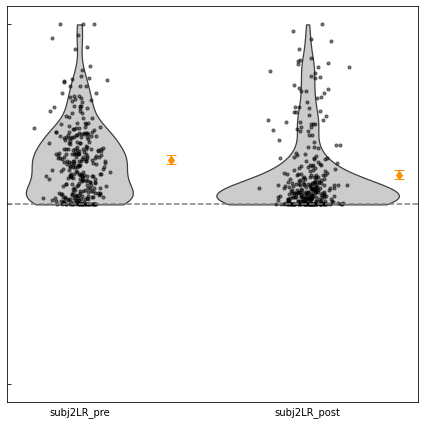

In [ ]:
plot_violin_with_jitter_and_ci(allLrnSumm[['subj2LR_pre','subj2LR_post']], ylim=[-1.1,1.1], yticks=[-1,0,1])

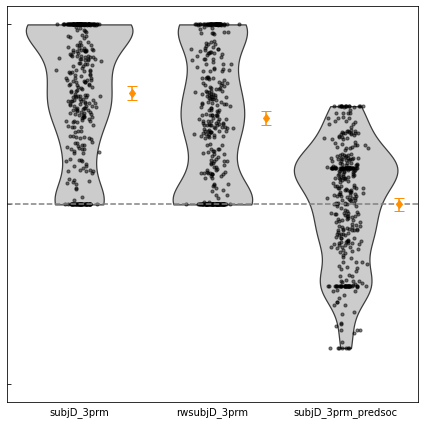

In [ ]:

allLrnSumm['subjLR_3prm_predsoc']= oneLRTRUST['subjLR_3prm']- (0.4612*oneLRLOT['subjLR_3prm'] + 0.1847)
allLrnSumm['subjD_3prm_predsoc']=  oneLRTRUST['subjD_3prm']- (0.3433*oneLRLOT['subjD_3prm'] + 0.4545)
allLrnSumm['subjp0_3prm_predsoc']= oneLRTRUST['subjp0_3prm']- (0.4498 *oneLRLOT['subjp0_3prm'] + 0.0159)

allLrnSumm['rwsubjLR_3prm']= oneLRLOT['subjLR_3prm']
allLrnSumm['rwsubjp0_3prm']= oneLRLOT['subjp0_3prm']
allLrnSumm['rwsubjD_3prm']= oneLRLOT['subjD_3prm']


allLrnSumm['subjLR_3prm']= oneLRTRUST['subjLR_3prm']
allLrnSumm['subjp0_3prm']= oneLRTRUST['subjp0_3prm']
allLrnSumm['subjD_3prm']= oneLRTRUST['subjD_3prm']


#plot_violin_with_jitter_and_ci(allLrnSumm[['subjLR_3prm','rwsubjLR_3prm','subjLR_3prm_predsoc']], ylim=[-1.1,1.1], yticks=[-1,0,1])
#plot_violin_with_jitter_and_ci(allLrnSumm[['subjp0_3prm','rwsubjp0_3prm','subjp0_3prm_predsoc']], ylim=[-1.1,1.1], yticks=[-1,0,1])
plot_violin_with_jitter_and_ci(allLrnSumm[['subjD_3prm','rwsubjD_3prm','subjD_3prm_predsoc']], ylim=[-1.1,1.1], yticks=[-1,0,1])




<span style="font-size: 48px;">1: Trauma Load</span>

In [ ]:
qDat = data['qDat']
# Take all qDat columns that start with 'LEC-A'
lec_df = qDat.loc[:, qDat.columns.str.startswith('LEC')]
#lec_df = datForAndrea.loc[:, datForAndrea.columns.str.startswith('LEC')]



#lec_cols_interest = ['LEC-A_7',  'LEC-A_8',  'LEC-A_9', 'LEC-A_10', 'LEC-A_11', 'LEC-A_16']
ALL_LEC = ['LEC-A_1','LEC-A_2','LEC-A_3','LEC-A_4','LEC-A_5','LEC-A_6', 'LEC-A_7',  'LEC-A_8',  'LEC-A_9', 'LEC-A_10', 'LEC-A_11', 'LEC-A_12','LEC-A_14','LEC-A_15','LEC-A_16','LEC-A_17']
ALL_LEC_AGE = [
    'LEC-1-FU-Age', 'LEC-2-FU-Age', 'LEC-3-FU-Age', 'LEC-4-FU-Age', 'LEC-5-FU-Age',
    'LEC-6-FU-Age', 'LEC-7-FU-Age', 'LEC-8-FU-Age', 'LEC-9-FU-Age', 'LEC-10-FU-Age',
    'LEC-11-FU-Age', 'LEC-12-FU-Age', 'LEC-14-FU-Age', 'LEC-15-FU-Age', 'LEC-16-FU-Age', 'LEC-17-FU-Age'
]
lec_cols_interest = ['LEC-A_6', 'LEC-A_7',  'LEC-A_8',  'LEC-A_9', 'LEC-A_10', 'LEC-A_11', 'LEC-A_17']
lec_cols_interest_witness = ['LEC-A_6','LEC-A_7',  'LEC-A_8',  'LEC-A_9', 'LEC-A_10', 'LEC-A_11','LEC-A_15', 'LEC-A_17']
lec_age_cols = ['LEC-6-FU-Age', 'LEC-7-FU-Age', 'LEC-8-FU-Age', 'LEC-9-FU-Age', 'LEC-10-FU-Age', 'LEC-11-FU-Age', 'LEC-16-FU-Age']
lec_age_witness = ['LEC-6-FU-Age', 'LEC-7-FU-Age', 'LEC-8-FU-Age', 'LEC-9-FU-Age', 'LEC-10-FU-Age', 'LEC-11-FU-Age', 'LEC-15-FU-Age', 'LEC-16-FU-Age']
lec_chronicity_cols = ['LEC-6-FU-Chronicity', 'LEC-7-FU-Chronicity', 'LEC-8-FU-Chronicity', 'LEC-9-FU-Chronicity', 'LEC-10-FU-Chronicity', 'LEC-11-FU-Chronicity', 'LEC-16-FU-Chronicity']


In [ ]:

def experienced(val):
    if pd.isnull(val):
        return 0
    try:
        return 1 if "1" in str(val).split(",") else 0
    except:
        return 0


def experienced_in_childhood(age, val):
    # Return 1 if age < 18 and '1' is anywhere in val (handles comma-separated or other digits)
    try:
        if float(age) < 18 and ('1' in str(val).split(',')):
            return 1
    except:
        pass
    return 0

def witnessed(val):
    if pd.isnull(val):
        return 0
    try:
        return 1 if "2" in str(val).split(",") else 0
    except:
        return 0


def witnessed_and_experienced(val):
    if pd.isnull(val):
        return 0
    try:
        val_set = set(str(val).split(","))
        return 1 if "1" in val_set and "2" in val_set else 0
    except:
        return 0
    

def witnessed_and_exper_child(val, age):
    if pd.isnull(val):
        return 0
    try:
        val_set = set(str(val).split(","))
        return 1 if float(age) < 18 and "1" in val_set and "2" in val_set else 0
    except:
        return 0
    

def witnessed_in_childhood(age, val):
    # Return 1 if age < 18 and '2' is anywhere in val (handles comma-separated or other digits)
    try:
        if float(age) < 18 and ('2' in str(val).split(',')):
            return 1
    except:
        pass
    return 0

def is_chronic(val, exp_val):
    if pd.isnull(val) or pd.isnull(exp_val):
        return 0
    try:
        # Only count as chronic if experienced ("1" in exp_val) and chronicity == 2
        if "1" in str(exp_val).split(",") and float(val) == 2:
            return 1
        else:
            return 0
    except:
        return 0
    
lec_df['LEC-3-FU-Age'] = lec_df['LEC-3-FU-Age'].astype(str).str.replace(r'^7', '', regex=True)



interpersonal_load = lec_df[lec_cols_interest].applymap(experienced).sum(axis=1)

lec_df['interpersonal_load'] = interpersonal_load
lec_df['interpersonal_childhood'] = [
    sum(experienced_in_childhood(row[age_col], row[lec_col]) for age_col, lec_col in zip(lec_age_cols, lec_cols_interest))
    for _, row in lec_df.iterrows()
]

lec_df['IPT_yn'] = (lec_df['interpersonal_load'] > 0).astype(int)

lec_df['IPT_child_yn'] = (lec_df['interpersonal_childhood'] > 0).astype(int)

lec_df['Lec_Total_Childhood'] = [
    sum(
        experienced_in_childhood(row[age_col], row[lec_col])
        for age_col, lec_col in zip(ALL_LEC_AGE, ALL_LEC)
    )
    for _, row in lec_df.iterrows()
]

lec_df['interpersonal_chronicity'] = [
    sum(is_chronic(row[chronicity_col], row[exp_col]) for chronicity_col, exp_col in zip(lec_chronicity_cols, lec_cols_interest))
    for _, row in lec_df.iterrows()
]

# FIX: chronic_childhood_interpersonal should count only chronic events in childhood
lec_df['chronic_childhood_interpersonal'] = [
    sum(
        is_chronic(row[chronicity_col], row[lec_col]) and experienced_in_childhood(row[age_col], row[lec_col])
        for age_col, lec_col, chronicity_col in zip(lec_age_cols, lec_cols_interest, lec_chronicity_cols)
    )
    for _, row in lec_df.iterrows()
]
lec_df['interpersonal_witnessed'] = [
    sum(
        witnessed(row[lec_col]) for lec_col in lec_cols_interest_witness
    )
    for _, row in lec_df.iterrows()
]
#experienced or witnessed
lec_df['experienced_or_witnessed'] = [
    sum(experienced(row[lec_col]) or witnessed(row[lec_col]) for lec_col in lec_cols_interest_witness
    )
    for _, row in lec_df.iterrows()
]

lec_df['experienced_and_witnessed'] = [
    sum(
        witnessed_and_experienced(row[lec_col]) for lec_col in lec_cols_interest_witness
    )
    for _, row in lec_df.iterrows()
]
lec_df['ipt_witnessed_childhood'] = [
    sum(witnessed_in_childhood(row[age_col], row[lec_col]) for age_col, lec_col in zip(lec_age_witness, lec_cols_interest_witness))
    for _, row in lec_df.iterrows()
]

lec_df['experienced_and_witnessed_childhood'] = [
    sum(witnessed_and_exper_child(row[lec_col], row[age_col]) for lec_col, age_col in zip(lec_cols_interest_witness, lec_age_witness))
    for _, row in lec_df.iterrows()
]
lec_df['experienced_and_witnessed_adulthood'] = lec_df['experienced_and_witnessed'] - lec_df['experienced_and_witnessed_childhood']


#now i will try to separate it first to see if the most traumatic event was interpersonal, and then if that event happened in childhood

#if B1 == 7 8 9 10 11 or 16 then interpersonal
lec_df['most_traumatic_interpersonal'] = lec_df['LEC-B1'].apply(lambda x: int(x in [7, 8, 9, 10, 11, 16]))
# now if that event happened in childhood, we can find this by subtracting how many years ago it happened from the age, taken from prolfic_data
lec_df['Age'] = datForAndrea['Age']
#lec_df['most_traumatic_childhood'] = lec_df.apply(lambda row: int(row['most_traumatic_interpersonal'] and (row['Age'] - row['LEC-B2']) <= 18), axis=1)
## find the events that happened in childhood that were chronic, as defined by the columns LEC-XX-FU-Chronicity
#lec_df['chronic_childhood_interpersonal'] =

#convert all 5s to 4s

lec_df['interpersonal_load_trunc'] = lec_df['interpersonal_load'].replace(5, 4)
lec_df['interpersonal_childhood_trunc'] = lec_df['interpersonal_childhood'].replace(5, 4)

lec_df['interpersonal_adult'] = lec_df['interpersonal_load'] - lec_df['interpersonal_childhood']
lec_df['interpersonal_adult_trunc'] = lec_df['interpersonal_load_trunc'] - lec_df['interpersonal_childhood_trunc']


prolific_dataW2 = data['summScores']
ctq_cols = [col for col in prolific_dataW2.columns if col.startswith('CTQ')]
if 'PID' in prolific_dataW2.columns:
    ctq_cols += ['PID']
ctq_df = prolific_dataW2[ctq_cols]

print(ctq_df.head())

CTQTot = ctq_df['CTQ_total']
#CTQTot = ctq_df['good_candidates']


""" 
# print(CTQ.iloc[:,np.r_[2,5,7,13,19,26,28]-1])
ctq_df.iloc[:,np.r_[2,5,7,13,19,26,28]-1]=6-ctq_df.iloc[:,np.r_[2,5,7,13,19,26,28]-1]
# print(CTQ.iloc[:,np.r_[2,5,7,13,19,26,28]-1])
ctq_df['CTQ_total']=ctq_df.sum(axis=1)
ctq_df['CTQ_emotAb']=ctq_df.iloc[:,np.r_[3,8,14,18,25]-1].sum(axis=1)
ctq_df['CTQ_physAb']=ctq_df.iloc[:,np.r_[9,11,12,15,17]-1].sum(axis=1)
ctq_df['CTQ_sexAb']=ctq_df.iloc[:,np.r_[20,21,23,24,27]-1].sum(axis=1)
ctq_df['CTQ_emotNeg']=ctq_df.iloc[:,np.r_[5,7,13,19,28]-1].sum(axis=1)
ctq_df['CTQ_physNeg']=ctq_df.iloc[:,np.r_[1,2,4,6,26]-1].sum(axis=1)
ctq_df['CTQ_minDen']=(ctq_df.iloc[:,np.r_[10,16,22]-1]>4).sum(axis=1)

ctqScored=ctq_df.join(ctq_df.loc[:, 'CTQ_total':])
#also do quality checks to see if the IPTLoad we imputed and the CTQ are correlated
 """

C:\Users\mnand\AppData\Local\Temp/ipykernel_19448/701028805.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lec_df['LEC-3-FU-Age'] = lec_df['LEC-3-FU-Age'].astype(str).str.replace(r'^7', '', regex=True)
C:\Users\mnand\AppData\Local\Temp/ipykernel_19448/701028805.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lec_df['interpersonal_load'] = interpersonal_load
C:\Users\mnand\AppData\Local\Temp/ipykernel_19448/701028805.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

                          CTQ_total  CTQ_emotAb  CTQ_physAb  CTQ_sexAb  \
PROLIFIC_PID                                                             
55c694e3fdf99b6c4f28595f  40.000000         7.0         7.0        5.0   
55d86f3569dbc30012b6869f  42.000000         5.0         5.0       10.0   
55e7221441988f000b75cc7a  50.666667         9.0         6.0        5.0   
560ce65601c38a0012769e20  43.333333         6.0         5.0        5.0   
56b8de29e1d0a200051517f8  40.666667         5.0         5.0        5.0   

                          CTQ_emotNeg  CTQ_physNeg  CTQ_minDen  
PROLIFIC_PID                                                    
55c694e3fdf99b6c4f28595f     5.000000     5.000000         1.0  
55d86f3569dbc30012b6869f     9.000000     5.000000         0.0  
55e7221441988f000b75cc7a    18.000000     6.666667         0.0  
560ce65601c38a0012769e20     9.333333     7.666667         0.0  
56b8de29e1d0a200051517f8     6.000000     5.000000         3.0  


C:\Users\mnand\AppData\Local\Temp/ipykernel_19448/701028805.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lec_df['experienced_and_witnessed_childhood'] = [
C:\Users\mnand\AppData\Local\Temp/ipykernel_19448/701028805.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lec_df['experienced_and_witnessed_adulthood'] = lec_df['experienced_and_witnessed'] - lec_df['experienced_and_witnessed_childhood']
C:\Users\mnand\AppData\Local\Temp/ipykernel_19448/701028805.py:140: SettingWithCopyWarning: 
A value i

" \n# print(CTQ.iloc[:,np.r_[2,5,7,13,19,26,28]-1])\nctq_df.iloc[:,np.r_[2,5,7,13,19,26,28]-1]=6-ctq_df.iloc[:,np.r_[2,5,7,13,19,26,28]-1]\n# print(CTQ.iloc[:,np.r_[2,5,7,13,19,26,28]-1])\nctq_df['CTQ_total']=ctq_df.sum(axis=1)\nctq_df['CTQ_emotAb']=ctq_df.iloc[:,np.r_[3,8,14,18,25]-1].sum(axis=1)\nctq_df['CTQ_physAb']=ctq_df.iloc[:,np.r_[9,11,12,15,17]-1].sum(axis=1)\nctq_df['CTQ_sexAb']=ctq_df.iloc[:,np.r_[20,21,23,24,27]-1].sum(axis=1)\nctq_df['CTQ_emotNeg']=ctq_df.iloc[:,np.r_[5,7,13,19,28]-1].sum(axis=1)\nctq_df['CTQ_physNeg']=ctq_df.iloc[:,np.r_[1,2,4,6,26]-1].sum(axis=1)\nctq_df['CTQ_minDen']=(ctq_df.iloc[:,np.r_[10,16,22]-1]>4).sum(axis=1)\n\nctqScored=ctq_df.join(ctq_df.loc[:, 'CTQ_total':])\n#also do quality checks to see if the IPTLoad we imputed and the CTQ are correlated\n "

In [ ]:
def correlate_ctq_childhood(lec_df, CTQTot):
    """
    Computes Pearson correlation between CTQ total score and LEC-based childhood trauma load.
    Returns correlation coefficient and p-value.
    """
    import numpy as np
    from scipy.stats import pearsonr

    # Align indices and drop missing
    df = lec_df.copy()
    df = df.loc[df.index.intersection(CTQTot.index)]
    childhood_load = df['interpersonal_childhood_trunc']
    ctq = CTQTot.loc[childhood_load.index]

    # Drop missing values
    valid = (~childhood_load.isna()) & (~ctq.isna())
    childhood_load = childhood_load[valid]
    ctq = ctq[valid]

    corr, pval = pearsonr(childhood_load, ctq)
    print(f"Correlation between CTQ total and LEC childhood trauma load: r={corr:.3f}, p={pval:.3g}")
    return corr, pval

# Example usage:
correlate_ctq_childhood(lec_df, CTQTot)

Correlation between CTQ total and LEC childhood trauma load: r=0.504, p=2.57e-22


(0.5044319523851973, 2.568269234002645e-22)

In [ ]:

print(data.keys())

print(type(qSummW2))
print(qSummW2.head())

dict_keys(['qDat', 'subjs', 'qSumm', 'subj', 'rwlrnDat', 'rwlrnSumm', 'rwlrnEstArr', 'rwlrnOCArr', 'rwlrnEst', 'rwlrnOC', 'lrnDat', 'lrnSumm', 'lrnEstArr', 'lrnOCArr', 'lrnEst', 'lrnOC', 'qDatW2', 'subjsW2', 'qSummW2', 'summScores'])


NameError: name 'qSummW2' is not defined

In [ ]:

#Change LEC by childhood trauma load and adulthood truama load, as in not binerized as "childhood trauma or not"
#  use them as regressors? 
#chronic vs acute interpersonal trauma?


good_candidates = datForAndrea[datForAndrea['distFromMedQA_lowMC_ltMADCutOff_goodSub'] == 1].index
#distFromMedQAAll_lowMC_ltMADCutOff_
good_candidates2 = datForAndrea[datForAndrea['distFromMedQAAll_lowMC_ltMADCutOff_goodSub'] == 1].index
valid_candidates = [idx for idx in good_candidates if idx in lec_df.index]
lec_df = lec_df.loc[valid_candidates]
valid_candidates = [idx for idx in good_candidates if idx in CTQTot.index]
CTQTot = CTQTot.loc[valid_candidates]
#drop NA
CTQTot = CTQTot.dropna()
#lec_df = lec_df.loc[good_candidates]
# Summary stats for trauma load, childhood/adult, and all trauma functions

# 1. Participants with at least one interpersonal trauma
n_total = len(lec_df)
n_interpersonal = (lec_df['interpersonal_load'] > 0).sum()
pct_interpersonal = n_interpersonal / n_total * 100

# 2. Participants with zero interpersonal trauma
n_no_interpersonal = (lec_df['interpersonal_load'] == 0).sum()
pct_no_interpersonal = n_no_interpersonal / n_total * 100

print(f"Participants with ≥1 interpersonal trauma: {n_interpersonal} ({pct_interpersonal:.1f}%)")
print(f"Participants with no interpersonal trauma: {n_no_interpersonal} ({pct_no_interpersonal:.1f}%)")

# 3. Distribution of number of interpersonal traumas
for n in range(1, 6):
    count = (lec_df['interpersonal_load'] == n).sum()
    pct = count / n_total * 100
    print(f"{count} ({pct:.1f}%) participants reported {n} interpersonal traumatic event(s)")

# 4. Childhood vs. adulthood among those with interpersonal trauma
interpersonal_mask = lec_df['interpersonal_load'] > 0
n_childhood = (lec_df['interpersonal_childhood'] > 0).sum()
n_witnessed = (lec_df['interpersonal_witnessed'] > 0).sum()
n_experienced_witnessed = (lec_df['experienced_and_witnessed'] > 0).sum()
n_adulthood = interpersonal_mask.sum() - n_childhood
# 5. Additional summary stats using all trauma functions
def print_group_stats(df, col, label, threshold=0):
    n_total = len(df)
    n_group = (df[col] > threshold).sum()
    pct_group = n_group / n_total * 100
    print(f"{label}: {n_group} ({pct_group:.1f}%)")

def print_group_stats_ipt(df, col, label, threshold=0):
    n_total = n_interpersonal
    n_group = (df[col] > threshold).sum()
    pct_group = n_group / n_total * 100
    print(f"{label}: {n_group} ({pct_group:.1f}%)")
only_childhood = (lec_df['interpersonal_childhood'] > 0) & (lec_df['interpersonal_adult'] == 0)
only_adulthood = (lec_df['interpersonal_childhood'] == 0) & (lec_df['interpersonal_adult'] > 0)
both_child_and_adult = (lec_df['interpersonal_childhood'] > 0) & (lec_df['interpersonal_adult'] > 0)

print(f"Only childhood IPT: {only_childhood.sum()} ({only_childhood.sum()/n_total*100:.1f}%)")
print(f"Only adulthood IPT: {only_adulthood.sum()} ({only_adulthood.sum()/n_total*100:.1f}%)")
print(f"Both childhood and adulthood IPT: {both_child_and_adult.sum()} ({both_child_and_adult.sum()/n_total*100:.1f}%)")
print_group_stats_ipt(lec_df, 'interpersonal_childhood', "Any childhood interpersonal trauma")
print_group_stats_ipt(lec_df, 'interpersonal_adult', "Any adulthood-only interpersonal trauma")
print_group_stats(lec_df, 'interpersonal_load', "Any interpersonal trauma")


def print_group_stats_iptw(df, col, label, threshold=0):
    n_total = n_witnessed
    n_group = (df[col] > threshold).sum()
    pct_group = n_group / n_total * 100
    print(f"{label}: {n_group} ({pct_group:.1f}%)")

def print_group_stats_iptwc(df, col, label, threshold=0):
    n_total = n_experienced_witnessed
    n_group = (df[col] > threshold).sum()
    pct_group = n_group / n_total * 100
    print(f"{label}: {n_group} ({pct_group:.1f}%)")
print_group_stats_iptw(lec_df, 'interpersonal_witnessed', "Any witnessed interpersonal trauma")
# Fold together mutually exclusive experienced & witnessed IPT groups

mask_both_child = (lec_df['experienced_and_witnessed_childhood'] > 0)
mask_both_adult = (lec_df['experienced_and_witnessed_adulthood'] > 0)

only_child = mask_both_child & ~mask_both_adult
only_adult = mask_both_adult & ~mask_both_child
both = mask_both_child & mask_both_adult

n_experienced_witnessed = (lec_df['experienced_and_witnessed'] > 0).sum()

print(f"Mutually exclusive breakdown among those with any experienced & witnessed IPT:")
print(f"  Only childhood: {only_child.sum()} ({only_child.sum()/n_experienced_witnessed*100:.1f}%)")
print(f"  Only adulthood: {only_adult.sum()} ({only_adult.sum()/n_experienced_witnessed*100:.1f}%)")
print(f"  Both childhood and adulthood: {both.sum()} ({both.sum()/n_experienced_witnessed*100:.1f}%)")

print(f"\nNested (overlapping) stats:")
print_group_stats_iptwc(lec_df, 'experienced_or_witnessed', "Any interpersonal trauma experienced  wiortnessed")
print_group_stats_iptwc(lec_df, 'experienced_and_witnessed', "Any interpersonal trauma both experienced and witnessed")
print_group_stats_iptwc(lec_df, 'experienced_and_witnessed_childhood', "Any interpersonal trauma both experienced and witnessed in childhood")
#subtract those who experienced and witnessed in childhood from those who experienced and witnessed at all to get adult
print_group_stats_iptwc(lec_df, 'experienced_and_witnessed_adulthood', "Any interpersonal trauma both experienced and witnessed in adulthood")

print_group_stats_iptw(lec_df, 'ipt_witnessed_childhood', "Any witnessed trauma in childhood")


# Basic stats for interpersonal chronicity
chronicity = lec_df['interpersonal_chronicity']

print(f"Mean chronicity: {chronicity.mean():.2f}")
print(f"Median chronicity: {chronicity.median():.2f}")
print(f"Std dev chronicity: {chronicity.std():.2f}")
print(f"Min chronicity: {chronicity.min()}")
print(f"Max chronicity: {chronicity.max()}")
print(f"Number with any chronicity (>0): {(chronicity > 0).sum()} / {len(chronicity)} ({(chronicity > 0).mean()*100:.1f}%)")
print(f"Number with zero chronicity: {(chronicity == 0).sum()} / {len(chronicity)} ({(chronicity == 0).mean()*100:.1f}%)")

# Distribution counts
print("Chronicity value counts:")
print(chronicity.value_counts().sort_index())


n_total = len(lec_df)
n_chronic = (lec_df['interpersonal_chronicity'] > 0).sum()
n_ipt = (lec_df['interpersonal_load'] > 0).sum()

print(f"Number with any chronic interpersonal trauma: {n_ipt} ({n_ipt/n_total*100:.1f}%)")
print(f"Number with chronic interpersonal trauma: {n_chronic} ({n_chronic/n_total*100:.1f}%)")
print(f"Number with acute-only interpersonal trauma: {n_ipt-n_chronic} ({(n_ipt-n_chronic)/n_total*100:.1f}%)")

Participants with ≥1 interpersonal trauma: 213 (58.4%)
Participants with no interpersonal trauma: 152 (41.6%)
87 (23.8%) participants reported 1 interpersonal traumatic event(s)
63 (17.3%) participants reported 2 interpersonal traumatic event(s)
44 (12.1%) participants reported 3 interpersonal traumatic event(s)
16 (4.4%) participants reported 4 interpersonal traumatic event(s)
3 (0.8%) participants reported 5 interpersonal traumatic event(s)
Only childhood IPT: 48 (13.2%)
Only adulthood IPT: 118 (32.3%)
Both childhood and adulthood IPT: 47 (12.9%)
Any childhood interpersonal trauma: 95 (44.6%)
Any adulthood-only interpersonal trauma: 165 (77.5%)
Any interpersonal trauma: 213 (58.4%)
Any witnessed interpersonal trauma: 156 (100.0%)
Mutually exclusive breakdown among those with any experienced & witnessed IPT:
  Only childhood: 27 (31.8%)
  Only adulthood: 42 (49.4%)
  Both childhood and adulthood: 16 (18.8%)

Nested (overlapping) stats:
Any interpersonal trauma experienced  wiortnessed

C:\Users\mnand\AppData\Local\Temp/ipykernel_19448/3244550467.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(range(1,6)), y=trauma_counts, palette='Blues')


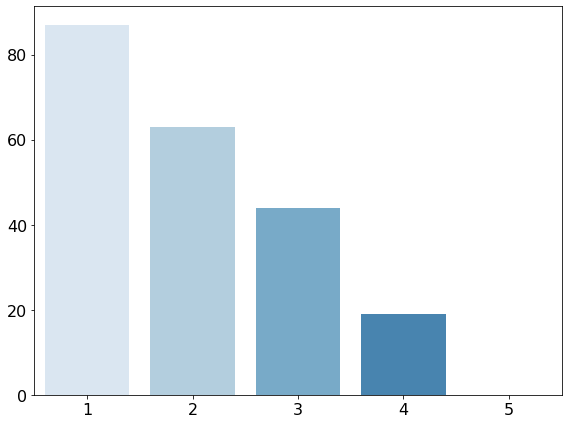

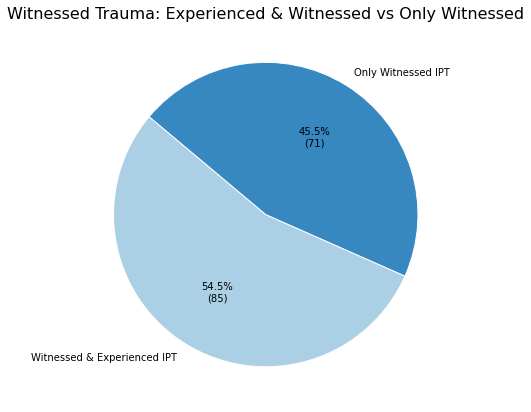

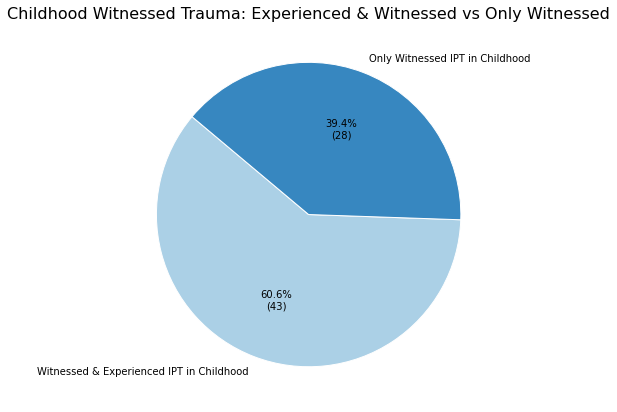

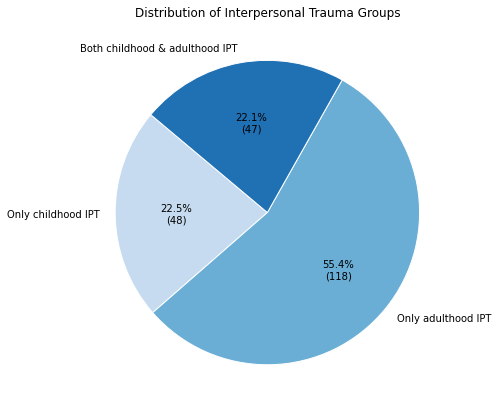

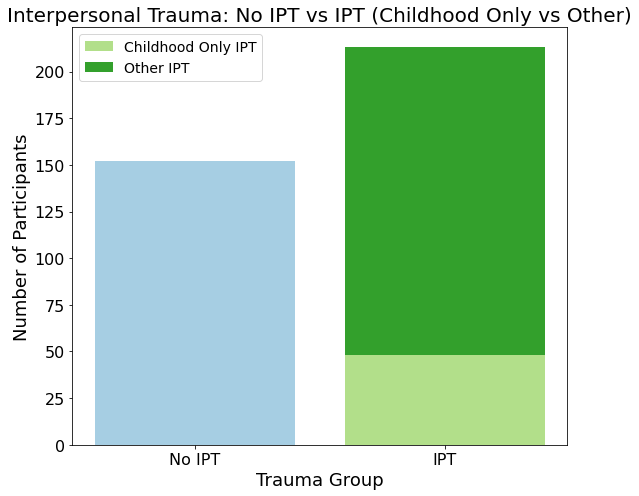

In [ ]:

# 2. Bar plot: Distribution of number of interpersonal traumas
plt.figure(figsize=(8,6))
trauma_counts = [(lec_df['interpersonal_load_trunc'] == n).sum() for n in range(1,6)]
sns.barplot(x=list(range(1,6)), y=trauma_counts, palette='Blues')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig('dist.svg', format='svg') 
plt.show()

# Pie chart: witnessed trauma split into "witnessed & experienced" vs "only witnessed"

mask_witnessed = lec_df['interpersonal_witnessed'] > 0
mask_experienced_and_witnessed = lec_df['experienced_and_witnessed'] > 0
mask_only_witnessed = mask_witnessed & ~mask_experienced_and_witnessed

pie_labels = [
    "Witnessed & Experienced IPT",
    "Only Witnessed IPT"
]
pie_counts = [
    mask_experienced_and_witnessed.sum(),
    mask_only_witnessed.sum()
]

fig, ax = plt.subplots(figsize=(7,7), facecolor='white')
wedges, texts, autotexts = ax.pie(
    pie_counts,
    labels=pie_labels,
    autopct=lambda pct: f"{pct:.1f}%\n({int(round(pct/100.*sum(pie_counts)))})",
    startangle=140,
    colors=sns.color_palette("Blues", n_colors=2),
    wedgeprops=dict(edgecolor='white')
)

plt.title("Witnessed Trauma: Experienced & Witnessed vs Only Witnessed", fontsize=16)
plt.show()

# Pie chart: witnessed trauma in childhood split into "witnessed & experienced in childhood" vs "only witnessed in childhood"

mask_witnessed_child = lec_df['ipt_witnessed_childhood'] > 0
mask_experienced_and_witnessed_child = lec_df['experienced_and_witnessed_childhood'] > 0
mask_only_witnessed_child = mask_witnessed_child & ~mask_experienced_and_witnessed_child

pie_labels_child = [
    "Witnessed & Experienced IPT in Childhood",
    "Only Witnessed IPT in Childhood"
]
pie_counts_child = [
    mask_experienced_and_witnessed_child.sum(),
    mask_only_witnessed_child.sum()
]

fig, ax = plt.subplots(figsize=(7,7), facecolor='white')
wedges, texts, autotexts = ax.pie(
    pie_counts_child,
    labels=pie_labels_child,
    autopct=lambda pct: f"{pct:.1f}%\n({int(round(pct/100.*sum(pie_counts_child)))})",
    startangle=140,
    colors=sns.color_palette("Blues", n_colors=2),
    wedgeprops=dict(edgecolor='white')
)

plt.title("Childhood Witnessed Trauma: Experienced & Witnessed vs Only Witnessed", fontsize=16)
plt.show()
# Pie chart for mutually exclusive IPT groups with numbers on slices

pie_labels = [
    "Only childhood IPT",
    "Only adulthood IPT",
    "Both childhood & adulthood IPT"
]
pie_counts = [
    only_childhood.sum(),
    only_adulthood.sum(),
    both_child_and_adult.sum()
]

fig, ax = plt.subplots(figsize=(7,7), facecolor='white')
wedges, texts, autotexts = ax.pie(
    pie_counts,
    labels=pie_labels,
    autopct=lambda pct: f"{pct:.1f}%\n({int(round(pct/100.*sum(pie_counts)))})",
    startangle=140,
    colors=sns.color_palette("Blues", n_colors=3),
    wedgeprops=dict(edgecolor='white')
)

plt.title("Distribution of Interpersonal Trauma Groups")
plt.show()
# Bar plot: IPT vs No IPT, with IPT split into "Childhood Only" and "Other" (within IPT group)

import matplotlib.pyplot as plt
import seaborn as sns

# Masks
no_ipt_mask = lec_df['interpersonal_load'] == 0
ipt_mask = lec_df['interpersonal_load'] > 0
child_only_mask = (lec_df['interpersonal_childhood'] > 0) & (lec_df['interpersonal_adult'] == 0) & ipt_mask
other_ipt_mask = ipt_mask & ~child_only_mask

# Counts
n_no_ipt = no_ipt_mask.sum()
n_ipt = ipt_mask.sum()
n_child_only = child_only_mask.sum()
n_other_ipt = other_ipt_mask.sum()

# Stacked bar plot data
ipt_subgroups = [n_child_only, n_other_ipt]

plt.figure(figsize=(8,7))
bars = plt.bar(['No IPT', 'IPT'], [n_no_ipt, n_ipt], color=['#a6cee3', '#1f78b4'])
plt.bar('IPT', n_child_only, color='#b2df8a', label='Childhood Only IPT')
plt.bar('IPT', n_other_ipt, bottom=n_child_only, color='#33a02c', label='Other IPT')

plt.ylabel('Number of Participants', fontsize=18)
plt.xlabel('Trauma Group', fontsize=18)
plt.title('Interpersonal Trauma: No IPT vs IPT (Childhood Only vs Other)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

<span style="font-size: 48px;">2: Trust ratings X IPT</span>

In [ ]:
# Filter to good candidates
# Only keep good_candidates that are in lec_df.index

#lec_df = lec_df.loc[good_candidates]
trust_df = datForAndrea.loc[good_candidates]

trust_df = trust_df.loc[lec_df.index]

In [ ]:


# 1. Compare mean trust ratings: IPT vs no IPT
group_no_ipt = trust_df[lec_df['interpersonal_load'] == 0]['trust_rat_mean']
group_any_ipt = trust_df[lec_df['interpersonal_load'] > 0]['trust_rat_mean']
from scipy.stats import ttest_ind, pearsonr
t_stat, p_val = ttest_ind(group_no_ipt, group_any_ipt, nan_policy='omit')
print(f"Mean trust rating (no IPT): {group_no_ipt.mean():.2f} ± {group_no_ipt.std():.2f}")
print(f"Mean trust rating (any IPT): {group_any_ipt.mean():.2f} ± {group_any_ipt.std():.2f}")
print(f"t-test: t={t_stat:.3f}, p={p_val:.3g}")


# 2. Correlation: IPT load vs mean trust rating
clean_df = trust_df.copy()
clean_df['interpersonal_load'] = lec_df['interpersonal_load']
clean_df = clean_df[['interpersonal_load', 'trust_rat_mean']].replace([np.inf, -np.inf], np.nan).dropna()
corr, pval = pearsonr(clean_df['interpersonal_load'], clean_df['trust_rat_mean'])
print(f"Correlation (IPT load vs trust): r={corr:.3f}, p={pval:.3g}")




Mean trust rating (no IPT): 4.62 ± 0.96
Mean trust rating (any IPT): 4.33 ± 1.29
t-test: t=2.333, p=0.0202
Correlation (IPT load vs trust): r=-0.074, p=0.157


In [ ]:

# Correlation: CTQ vs mean trust rating
clean_df = trust_df.copy()
clean_df['CTQ'] = CTQTot
clean_df = clean_df[['CTQ', 'trust_rat_mean']].replace([np.inf, -np.inf], np.nan).dropna()
corr, pval = pearsonr(clean_df['CTQ'], clean_df['trust_rat_mean'])
print(f"Correlation (CTQvs trust): r={corr:.3f}, p={pval:.3g}")



Correlation (CTQvs trust): r=0.013, p=0.823


<span style="font-size: 24px;">Trust ratings X wit+exp IPT</span>

In [ ]:

# 1. Compare mean trust ratings: IPT experienced or witnessed vs no experience or witnessIPT
group_no_ipt = trust_df[lec_df['experienced_or_witnessed'] == 0]['trust_rat_mean']
group_any_ipt = trust_df[lec_df['experienced_or_witnessed'] > 0]['trust_rat_mean']
from scipy.stats import ttest_ind, pearsonr
t_stat, p_val = ttest_ind(group_no_ipt, group_any_ipt, nan_policy='omit')
print(f"Mean trust rating (no exp/wit IPT): {group_no_ipt.mean():.2f} ± {group_no_ipt.std():.2f}")
print(f"Mean trust rating (any exp/wit IPT): {group_any_ipt.mean():.2f} ± {group_any_ipt.std():.2f}")
print(f"t-test: t={t_stat:.3f}, p={p_val:.3g}")


# 1. Compare mean trust ratings: IPT witnessed only (no direct experience) vs no experience or witnessIPT
mask_no_witnessed = lec_df['interpersonal_witnessed'] == 0
mask_no_experienced = lec_df['interpersonal_load'] == 0
group_no_ipt = trust_df[mask_no_witnessed & mask_no_experienced]['trust_rat_mean']

mask_only_witnessed = (lec_df['interpersonal_witnessed'] > 0) & (lec_df['interpersonal_load'] == 0)
group_any_ipt = trust_df[mask_only_witnessed]['trust_rat_mean']
from scipy.stats import ttest_ind, pearsonr
t_stat, p_val = ttest_ind(group_no_ipt, group_any_ipt, nan_policy='omit')
print(f"Mean trust rating (no exp/wit IPT): {group_no_ipt.mean():.2f} ± {group_no_ipt.std():.2f}")
print(f"Mean trust rating (no exp, any wit IPT): {group_any_ipt.mean():.2f} ± {group_any_ipt.std():.2f}")
print(f"t-test: t={t_stat:.3f}, p={p_val:.3g}")


Mean trust rating (no exp/wit IPT): 4.55 ± 0.91
Mean trust rating (any exp/wit IPT): 4.41 ± 1.27
t-test: t=1.032, p=0.303
Mean trust rating (no exp/wit IPT): 4.55 ± 0.91
Mean trust rating (no exp, any wit IPT): 4.86 ± 1.10
t-test: t=-1.692, p=0.0927


In [ ]:
len(group_no_ipt), len(group_any_ipt)

(114, 38)

C:\Users\mnand\AppData\Local\Temp/ipykernel_87976/4267502046.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


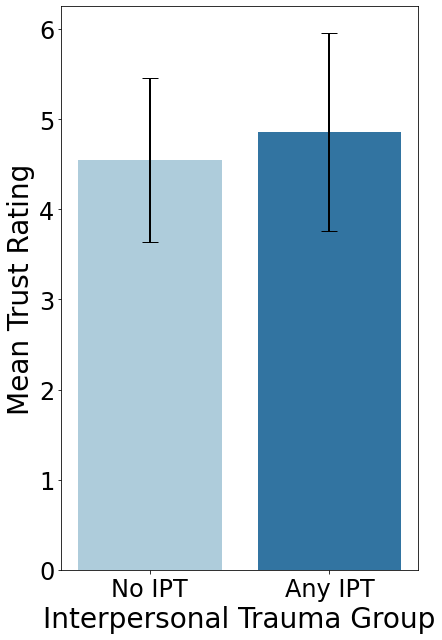

In [ ]:
# Visualize mean trust ratings for IPT vs no IPT with large labels
plt.figure(figsize=(6,9))
sns.barplot(
    x=['No IPT', 'Any IPT'],
    y=[group_no_ipt.mean(), group_any_ipt.mean()],
    palette=['#a6cee3', '#1f78b4']
)
plt.errorbar(
    x=[0, 1],
    y=[group_no_ipt.mean(), group_any_ipt.mean()],
    yerr=[group_no_ipt.std(), group_any_ipt.std()],
    fmt='none',
    ecolor='black',
    capsize=8,
    linewidth=2
)
plt.ylabel('Mean Trust Rating', fontsize=28)
plt.xlabel('Interpersonal Trauma Group', fontsize=28)

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.tight_layout()
plt.show()

<span style="font-size: 48px;">2b: Trust ratings X IPT: Acute vs Chronics</span>

<span style="font-size: 48px;">3: Trust Ratings x IPT Regression</span>

In [ ]:
# Build regression DataFrame with all predictors and outcome, drop missing
regression_df = pd.DataFrame({
    'trust_rat_mean': trust_df['trust_rat_mean'],
    'interpersonal_childhood': lec_df['interpersonal_childhood'],
    'interpersonal_load': lec_df['interpersonal_load'],
    'interpersonal_childhood_trunc': lec_df['interpersonal_childhood_trunc'],
    'interpersonal_load_trunc': lec_df['interpersonal_load_trunc'],
    'BirthSex': datForAndrea.loc[good_candidates, 'BirthSex'],
    'Race': datForAndrea.loc[good_candidates, 'Race'],
    'HLS_ethnicity': datForAndrea.loc[good_candidates, 'HLS_ethnicity'],
    'Age': datForAndrea.loc[good_candidates, 'Age']
}).dropna()

regression_df = regression_df[regression_df['interpersonal_load'] > 0]
# Unadjusted regression
from sklearn.preprocessing import StandardScaler

# Standardize predictors and outcome
scaler = StandardScaler()
X_unadj_std = scaler.fit_transform(regression_df[['interpersonal_load']])
y_std = scaler.fit_transform(regression_df[['trust_rat_mean']]).flatten()
X_unadj_std = sm.add_constant(X_unadj_std)
model_unadj_std = sm.OLS(y_std, X_unadj_std).fit()
std_beta_unadj = model_unadj_std.params[1]
print(f"Unadjusted regression standardized beta: {std_beta_unadj:.3f},p={model_unadj_std.pvalues[1]:.3g}")
print(model_unadj_std.summary())

# Adjusted regression (standardize all predictors)
X_adj_std = scaler.fit_transform(regression_df[['interpersonal_load_trunc', 'BirthSex', 'Race', 'HLS_ethnicity', 'Age']])
X_adj_std = sm.add_constant(X_adj_std)
model_adj_std = sm.OLS(y_std, X_adj_std).fit()
std_beta_adj = model_adj_std.params[1]
print(f"\nAdjusted regression standardized beta (demographics only): {std_beta_adj:.3f},p={model_adj_std.pvalues[1]:.3g}")
print(model_adj_std.summary())


# Adjusted regression (standardize all predictors)
X_adj_std = scaler.fit_transform(regression_df[['interpersonal_load_trunc', 'interpersonal_childhood_trunc']])
X_adj_std = sm.add_constant(X_adj_std)
model_adj_std = sm.OLS(y_std, X_adj_std).fit()
std_beta_adj = model_adj_std.params[1]
print(f"\nAdjusted regression standardized beta (IPT and childhood): {std_beta_adj:.3f},p={model_adj_std.pvalues[1]:.3g}")
print(model_adj_std.summary())

# Adjusted regression (standardize all predictors)
X_adj_std = scaler.fit_transform(regression_df[['interpersonal_load_trunc', 'interpersonal_childhood_trunc','BirthSex', 'Race', 'HLS_ethnicity', 'Age']])
X_adj_std = sm.add_constant(X_adj_std)
model_adj_std = sm.OLS(y_std, X_adj_std).fit()
std_beta_adj = model_adj_std.params[1]
print(f"\nAdjusted regression standardized beta (IPT and childhood with demographics): {std_beta_adj:.3f},p={model_adj_std.pvalues[1]:.3g}")
print(model_adj_std.summary())

Unadjusted regression standardized beta: 0.040,p=0.565
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.3325
Date:                Tue, 23 Dec 2025   Prob (F-statistic):              0.565
Time:                        15:09:21   Log-Likelihood:                -300.65
No. Observations:                 212   AIC:                             605.3
Df Residuals:                     210   BIC:                             612.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

<span style="font-size: 48px;">4: Trust Ratings x Childhood</span>


In [ ]:

# 3. Childhood vs adulthood IPT
child_mask = lec_df['interpersonal_childhood'] > 0
adult_mask = (lec_df['interpersonal_load'] > 0) & (lec_df['interpersonal_childhood'] == 0)
group_child = trust_df[child_mask]['trust_rat_mean']
group_adult = trust_df[adult_mask]['trust_rat_mean']
t_stat2, p_val2 = ttest_ind(group_child, group_adult, nan_policy='omit')
print(f"Mean trust rating (childhood IPT): {group_child.mean():.2f} ± {group_child.std():.2f}")
print(f"Mean trust rating (adulthood IPT): {group_adult.mean():.2f} ± {group_adult.std():.2f}")
print(f"t-test (childhood vs adulthood): t={t_stat2:.3f}, p={p_val2:.3g}")

# 4. Effect size (Cohen's d)
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    pooled_sd = np.sqrt(((nx-1)*x.std()**2 + (ny-1)*y.std()**2) / (nx+ny-2))
    return (x.mean() - y.mean()) / pooled_sd

print(f"Cohen's d (childhood vs adulthood): {cohens_d(group_child, group_adult):.3f}")

# 5. Overall sample mean trust rating
print(f"Overall mean trust rating: {trust_df['trust_rat_mean'].mean():.2f} (SD={trust_df['trust_rat_mean'].std():.2f})")

Mean trust rating (childhood IPT): 4.28 ± 1.39
Mean trust rating (adulthood IPT): 4.38 ± 1.20
t-test (childhood vs adulthood): t=-0.593, p=0.554
Cohen's d (childhood vs adulthood): -0.082
Overall mean trust rating: 4.45 (SD=1.17)


<span style="font-size: 48px;">5: Trust x Childhood Regression</span>

In [ ]:
#Build regression DataFrame for Learning Rates (socially-specific)
regression_df = pd.DataFrame({
    'trust_rat_mean': trust_df['trust_rat_mean'],
    'interpersonal_childhood': lec_df['interpersonal_childhood'],
    'interpersonal_load': lec_df['interpersonal_load'],
    'interpersonal_childhood_trunc': lec_df['interpersonal_childhood_trunc'],
    'interpersonal_load_trunc': lec_df['interpersonal_load_trunc'],
    'BirthSex': datForAndrea.loc[good_candidates, 'BirthSex'],
    'Race': datForAndrea.loc[good_candidates, 'Race'],
    'HLS_ethnicity': datForAndrea.loc[good_candidates, 'HLS_ethnicity'],
    'Age': datForAndrea.loc[good_candidates, 'Age']
}).dropna()
regression_df = regression_df[regression_df['interpersonal_load'] > 0]

# Split into childhood IPT and adulthood-only IPT
childhood_mask = (regression_df['interpersonal_childhood'] > 0)
adulthood_mask = (regression_df['interpersonal_load'] > 0) & (regression_df['interpersonal_childhood'] == 0)

# Standardize interpersonal_load and init_offer_predsoc for each group

from sklearn.preprocessing import StandardScaler

def run_standardized_reg(df, label):
    scaler = StandardScaler()
    X = scaler.fit_transform(df[['interpersonal_load']])
    y = scaler.fit_transform(df[['trust_rat_mean']]).flatten()
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[1]
    pval = model.pvalues[1]
    print(f"{label}: std. β={beta:.3f}, p={pval:.3f}")
    print(model.summary())

# Childhood IPT group
run_standardized_reg(regression_df[childhood_mask], "Childhood IPT")

# Adulthood-only IPT group
run_standardized_reg(regression_df[adulthood_mask], "Adulthood-only IPT")

Childhood IPT: std. β=0.076, p=0.464
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.5407
Date:                Tue, 23 Dec 2025   Prob (F-statistic):              0.464
Time:                        15:09:26   Log-Likelihood:                -133.10
No. Observations:                  94   AIC:                             270.2
Df Residuals:                      92   BIC:                             275.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.8

<span style="font-size: 48px;">6: Initial Offer x IPT Load</span>


In [ ]:
#see if there is an effect of chronicity of ipt load on socially specific lr, initial offer, and bias
#then we do the same thing with the childhood trauma questionaire
#good_candidates = datForAndrea[datForAndrea['distFromMedQA_lowMC_ltMADCutOff_goodSub'] == 1].index
#merged_df = merged_df.loc[good_candidates]
# Merge on PID to align interpersonal_load and socially specific LR
merged_df = pd.merge(
    allLrnSumm,
    lec_df[['interpersonal_load', 'interpersonal_childhood', 'interpersonal_load_trunc', 'interpersonal_childhood_trunc','interpersonal_chronicity']],
    left_index=True,
    right_index=True
)
valid_candidates = merged_df.index.intersection(good_candidates)
merged_df = merged_df.loc[valid_candidates]

# Group socially-specific initial offers by IPT status
group_no_ipt = merged_df[merged_df['interpersonal_load'] == 0]['subjp0_3prm_predsoc']
group_any_ipt = merged_df[merged_df['interpersonal_load'] > 0]['subjp0_3prm_predsoc']

from scipy.stats import ttest_ind
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    pooled_sd = np.sqrt(((nx-1)*x.std()**2 + (ny-1)*y.std()**2) / (nx+ny-2))
    return (x.mean() - y.mean()) / pooled_sd

# Calculate stats
mean_no_ipt = group_no_ipt.mean()
sd_no_ipt = group_no_ipt.std()
mean_any_ipt = group_any_ipt.mean()
sd_any_ipt = group_any_ipt.std()
t_stat, p_val = ttest_ind(group_no_ipt, group_any_ipt, nan_policy='omit')
d = cohens_d(group_no_ipt, group_any_ipt)

print(f"Mean initial offer (no IPT): {mean_no_ipt:.3f} ± {sd_no_ipt:.3f}")
print(f"Mean initial offer (any IPT): {mean_any_ipt:.3f} ± {sd_any_ipt:.3f}")
print(f"Independent samples t-test: n = {len(group_no_ipt) + len(group_any_ipt)}, t={t_stat:.2f}, p={p_val:.3f}, Cohen's d={d:.3f}")


KeyError: 'subjp0_3prm_predsoc'

C:\Users\mnand\AppData\Local\Temp/ipykernel_87976/180914829.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


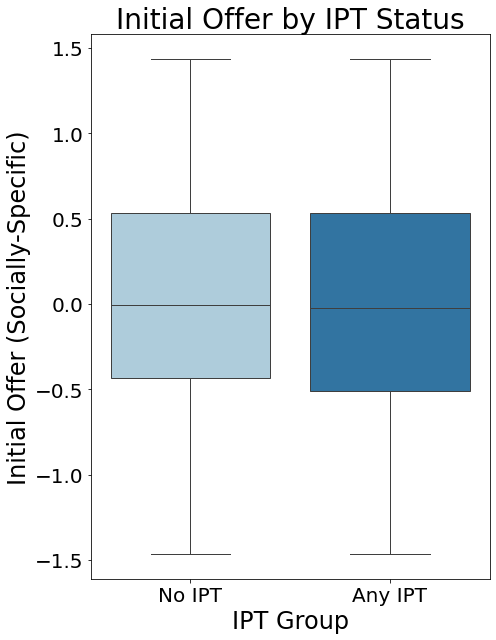

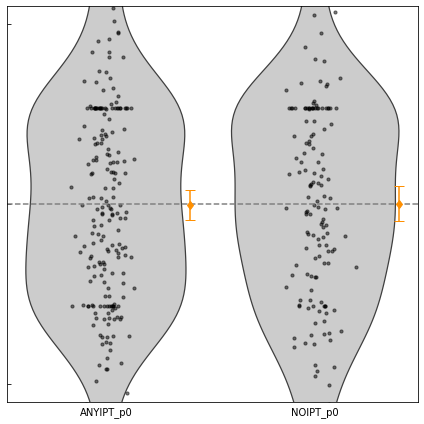

In [ ]:

# Calculate SEM
n_no_ipt = len(group_no_ipt)
n_any_ipt = len(group_any_ipt)
violinplot_df = pd.DataFrame({
    
    'NOIPT_p0' : merged_df[merged_df['interpersonal_load'] == 0]['subjp0_3prm_predsoc'],
    'ANYIPT_p0': merged_df[merged_df['interpersonal_load'] > 0]['subjp0_3prm_predsoc'],
})
violinplot_df2 = pd.DataFrame({
    
    'NOIPT_LR' : merged_df[merged_df['interpersonal_load'] == 0]['subjLR_3prm_predsoc'],
    'ANYIPT_LR': merged_df[merged_df['interpersonal_load'] > 0]['subjLR_3prm_predsoc'],
})
violinplot_df3 = pd.DataFrame({
    
    'NOIPT_D' : merged_df[merged_df['interpersonal_load'] == 0]['subjD_3prm_predsoc'],
    'ANYIPT_D': merged_df[merged_df['interpersonal_load'] > 0]['subjD_3prm_predsoc'],
})
# make into a df
group_no_ipt = merged_df[merged_df['interpersonal_load'] == 0]['subjp0_3prm_predsoc']
group_any_ipt = merged_df[merged_df['interpersonal_load'] > 0]['subjp0_3prm_predsoc']


plt.figure(figsize=(7, 9))
sns.boxplot(
    x=['No IPT'] * n_no_ipt + ['Any IPT'] * n_any_ipt,
    y=pd.concat([group_no_ipt, group_any_ipt]),
    palette=['#a6cee3', '#1f78b4']
)
plt.ylabel('Initial Offer (Socially-Specific)', fontsize=24)
plt.xlabel('IPT Group', fontsize=24)
plt.title('Initial Offer by IPT Status', fontsize=28)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.savefig('P0IPT.svg', format='svg') 
plt.show()


plot_violin_with_jitter_and_ci(violinplot_df[['ANYIPT_p0','NOIPT_p0']], ylim=[-1.1,1.1], yticks=[-1,0,1])
#plot_violin_with_jitter_and_ci(violinplot_df2[['ANYIPT_LR','NOIPT_LR']], ylim=[-1.1,1.1], yticks=[-1,0,1])
#plot_violin_with_jitter_and_ci(violinplot_df3[['ANYIPT_D','NOIPT_D']], ylim=[-1.1,1.1], yticks=[-1,0,1])

 # <-- Export as SVG

<span style="font-size: 48px;">7: Initial offer x Interpersonal Load Regression</span>


In [ ]:
# Build regression DataFrame for initial offers (socially-specific)
regression_df = pd.DataFrame({
    'init_offer_predsoc': merged_df['subjp0_3prm_predsoc'],
    'trust_rat_mean': trust_df['trust_rat_mean'],
    'interpersonal_childhood': lec_df['interpersonal_childhood'],
    'interpersonal_load': lec_df['interpersonal_load'],
    'interpersonal_childhood_trunc': lec_df['interpersonal_childhood_trunc'],
    'interpersonal_load_trunc': lec_df['interpersonal_load_trunc'],
    'BirthSex': datForAndrea.loc[good_candidates, 'BirthSex'],
    'Race': datForAndrea.loc[good_candidates, 'Race'],
    'HLS_ethnicity': datForAndrea.loc[good_candidates, 'HLS_ethnicity'],
    'Age': datForAndrea.loc[good_candidates, 'Age']
}).dropna()

regression_df = regression_df[regression_df['interpersonal_load'] > 0]

from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr

corr, pval = pearsonr(regression_df['trust_rat_mean'], regression_df['init_offer_predsoc'])
print(f"Correlation (trust_rat_mean vs init_offer_predsoc): r={corr:.3f}, p={pval:.3g}")

# Standardize predictors and outcome
scaler = StandardScaler()
X_unadj_std = scaler.fit_transform(regression_df[['trust_rat_mean']])
y_std = scaler.fit_transform(regression_df[['init_offer_predsoc']]).flatten()
X_unadj_std = sm.add_constant(X_unadj_std)
model_unadj_std = sm.OLS(y_std, X_unadj_std).fit()
std_beta_unadj = model_unadj_std.params[1]
print(f"trust x  initial offer: {std_beta_unadj:.3f}, p={model_unadj_std.pvalues[1]:.3g}")
#print(model_unadj_std.summary())


# Standardize predictors and outcome
scaler = StandardScaler()
X_unadj_std = scaler.fit_transform(regression_df[['interpersonal_load_trunc']])
y_std = scaler.fit_transform(regression_df[['init_offer_predsoc']]).flatten()
X_unadj_std = sm.add_constant(X_unadj_std)
model_unadj_std = sm.OLS(y_std, X_unadj_std).fit()
std_beta_unadj = model_unadj_std.params[1]
print(f"Unadjusted regression standardized beta: {std_beta_unadj:.3f}, p={model_unadj_std.pvalues[1]:.3g}")
#print(model_unadj_std.summary())

# Adjusted regression (standardize all predictors)
X_adj_std = scaler.fit_transform(regression_df[['interpersonal_load_trunc', 'BirthSex', 'Race', 'HLS_ethnicity', 'Age']])
X_adj_std = sm.add_constant(X_adj_std)
model_adj_std = sm.OLS(y_std, X_adj_std).fit()
std_beta_adj = model_adj_std.params[1]
print(f"\nAdjusted regression standardized beta (w/ race sex etc): {std_beta_adj:.3f}, p={model_adj_std.pvalues[1]:.3g}")
#print(model_adj_std.summary())

# Adjusted regression (standardize all predictors)
X_adj_std = scaler.fit_transform(regression_df[['interpersonal_load','interpersonal_childhood']])
X_adj_std = sm.add_constant(X_adj_std)
model_adj_std = sm.OLS(y_std, X_adj_std).fit()
std_beta_adj = model_adj_std.params[1]
print(f"\nAdjusted regression standardized beta (with child IPT): {std_beta_adj:.3f}, p={model_adj_std.pvalues[1]:.3g}")
#print(model_adj_std.summary())

# Adjusted regression (standardize all predictors)
X_adj_std = scaler.fit_transform(regression_df[['interpersonal_load','interpersonal_childhood', 'BirthSex', 'Race', 'HLS_ethnicity', 'Age']])
X_adj_std = sm.add_constant(X_adj_std)
model_adj_std = sm.OLS(y_std, X_adj_std).fit()
std_beta_adj = model_adj_std.params[1]
print(f"\nAdjusted regression standardized beta (with child IPT and demographics): {std_beta_adj:.3f}, p={model_adj_std.pvalues[1]:.3g}")
#print(model_adj_std.summary())

Correlation (trust_rat_mean vs init_offer_predsoc): r=0.059, p=0.391
trust x  initial offer: 0.059, p=0.391
Unadjusted regression standardized beta: 0.056, p=0.416

Adjusted regression standardized beta (w/ race sex etc): 0.049, p=0.492

Adjusted regression standardized beta (with child IPT): 0.050, p=0.509

Adjusted regression standardized beta (with child IPT and demographics): 0.035, p=0.653


<span style="font-size: 48px;">8: Initial Offer x Childhood Trauma</span>


In [ ]:

# Group socially-specific initial offers by IPT status
group_no_childhood = merged_df[merged_df['interpersonal_childhood'] == 0]['subjp0_3prm_predsoc']
group_any_childhood = merged_df[merged_df['interpersonal_childhood'] > 0]['subjp0_3prm_predsoc']

from scipy.stats import ttest_ind
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    pooled_sd = np.sqrt(((nx-1)*x.std()**2 + (ny-1)*y.std()**2) / (nx+ny-2))
    return (x.mean() - y.mean()) / pooled_sd

# Calculate stats
mean_no_childhood = group_no_childhood.mean()
sd_no_childhood = group_no_childhood.std()
mean_any_childhood = group_any_childhood.mean()
sd_any_childhood = group_any_childhood.std()
t_stat, p_val = ttest_ind(group_no_childhood, group_any_childhood, nan_policy='omit')
d = cohens_d(group_no_childhood, group_any_childhood)

print(f"Mean initial offer (no childhood IPT): {mean_no_childhood:.3f} ± {sd_no_childhood:.3f}")
print(f"Mean initial offer (any childhood IPT): {mean_any_childhood:.3f} ± {sd_any_childhood:.3f}")
print(f"Independent samples t-test: t={t_stat:.2f}, p={p_val:.3f}, Cohen's d={d:.3f}")


Mean initial offer (no childhood IPT): -0.004 ± 0.603
Mean initial offer (any childhood IPT): 0.012 ± 0.640
Independent samples t-test: t=-0.22, p=0.823, Cohen's d=-0.027


C:\Users\mnand\AppData\Local\Temp/ipykernel_87976/2604630277.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


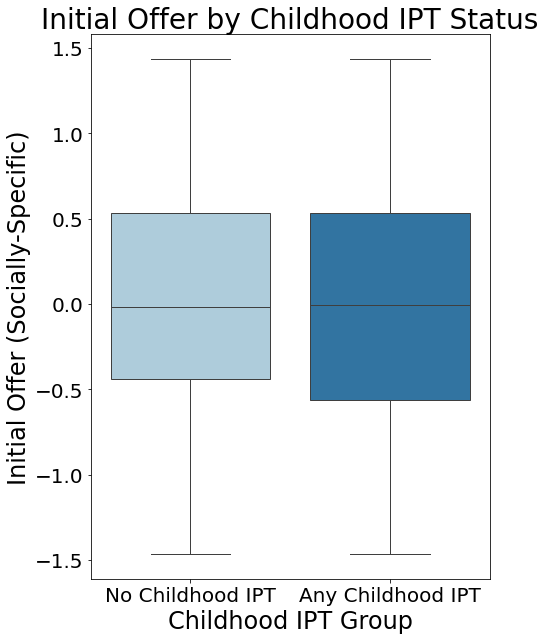

<Figure size 432x288 with 0 Axes>

In [ ]:
# Calculate SEM
n_no_childhood = len(group_no_childhood)
n_any_childhood = len(group_any_childhood)
plt.figure(figsize=(7, 9))
sns.boxplot(
    x=['No Childhood IPT'] * n_no_childhood + ['Any Childhood IPT'] * n_any_childhood,
    y=pd.concat([group_no_childhood, group_any_childhood]),
    palette=['#a6cee3', '#1f78b4']
)
plt.ylabel('Initial Offer (Socially-Specific)', fontsize=24)
plt.xlabel('Childhood IPT Group', fontsize=24)
plt.title('Initial Offer by Childhood IPT Status', fontsize=28)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.show()
plt.savefig('P0IPT.svg', format='svg')  # <-- Export as SVG

<span style="font-size: 48px;">9: Initial Offer x Childhood Trauma Regression</span>


In [ ]:
# Build regression DataFrame for Learning Rates (socially-specific)
regression_df = pd.DataFrame({
    'interpersonal_chronicity' : merged_df['interpersonal_chronicity'],
    'chronic_childhood_interpersonal' : lec_df['chronic_childhood_interpersonal'],
    'init_offer_predsoc': merged_df['subjp0_3prm_predsoc'],
    'subjLR_3prm': allLrnSumm['subjLR_3prm_predsoc'],
    'interpersonal_childhood_trunc': lec_df['interpersonal_childhood_trunc'],
    'interpersonal_adult_load_trunc': lec_df['interpersonal_adult_trunc'],
    'interpersonal_load_trunc': lec_df['interpersonal_load_trunc'],
    'BirthSex': datForAndrea.loc[good_candidates, 'BirthSex'],
    'Race': datForAndrea.loc[good_candidates, 'Race'],
    'HLS_ethnicity': datForAndrea.loc[good_candidates, 'HLS_ethnicity'],
    'Age': datForAndrea.loc[good_candidates, 'Age']
}).dropna()
regression_df = regression_df[regression_df['interpersonal_load_trunc'] > 0]

# Split into childhood IPT and adulthood-only IPT
childhood_mask = (regression_df['interpersonal_childhood_trunc'] > 0)
adulthood_mask = (regression_df['interpersonal_load_trunc'] > 0) & (regression_df['interpersonal_childhood_trunc'] == 0)

# Standardize interpersonal_load and init_offer_predsoc for each group

from sklearn.preprocessing import StandardScaler

def run_standardized_reg(df, label):
    scaler = StandardScaler()
    X = scaler.fit_transform(df[['interpersonal_load_trunc']])
    y = scaler.fit_transform(df[['init_offer_predsoc']]).flatten()
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[1]
    pval = model.pvalues[1]
    print(f"{label}: std. β={beta:.3f}, p={pval:.3f}")
    #print(model.summary())

# Childhood IPT group
run_standardized_reg(regression_df[childhood_mask], "Childhood IPT")

# Adulthood-only IPT group
run_standardized_reg(regression_df[adulthood_mask], "Adulthood-only IPT")


# Chronic trauma mask (chronicity > 0)
chronic_mask = (regression_df['interpersonal_chronicity'] > 0)
acute_mask = (regression_df['interpersonal_chronicity'] == 0)


# Chronic childhood IPT mask
chronic_child_mask = regression_df['chronic_childhood_interpersonal'] > 0
# Acute childhood IPT mask
acute_child_mask = (regression_df['interpersonal_childhood_trunc'] > 0) & (regression_df['chronic_childhood_interpersonal'] == 0)


from sklearn.preprocessing import StandardScaler


def run_standardized_reg_adult(df, label):
    scaler = StandardScaler()
    predictor = ['interpersonal_adult_load_trunc']
    X = scaler.fit_transform(df[predictor])
    y = scaler.fit_transform(df[['init_offer_predsoc']]).flatten()
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[1]
    pval = model.pvalues[1]
    print(f"{label}: std. β={beta:.3f}, p={pval:.3f}")
    print(f"Predictor(s): {predictor} | Outcome: init_offer_predsoc")
    #print(model.summary())


run_standardized_reg_adult(regression_df[childhood_mask], "Adult IPT with childhood IPT")
run_standardized_reg_adult(regression_df[adulthood_mask], "Adult IPT without childhood IPT")


def run_standardized_reg_adult_demo(df, label):
    scaler = StandardScaler()
    predictors = ['interpersonal_adult_load_trunc', 'BirthSex', 'Race', 'HLS_ethnicity','Age']
    X = scaler.fit_transform(df[predictors])
    y = scaler.fit_transform(df[['init_offer_predsoc']]).flatten()
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[1]
    pval = model.pvalues[1]
    print(f"{label}: std. β={beta:.3f}, p={pval:.3f}")
    print(f"Predictor(s): {predictors} | Outcome: init_offer_predsoc")
    #print(model.summary())


run_standardized_reg_adult_demo(regression_df[childhood_mask], "Adult IPT with childhood IPT w/ demos")
run_standardized_reg_adult_demo(regression_df[adulthood_mask], "Adult IPT without childhood IPT w/ demos")

# Childhood IPT group
run_standardized_reg(regression_df[childhood_mask], "Childhood IPT")

# Adulthood-only IPT group
run_standardized_reg(regression_df[adulthood_mask], "Adulthood-only IPT")

# Chronic IPT group
run_standardized_reg(regression_df[chronic_mask], "Chronic IPT")

# Acute IPT group
run_standardized_reg(regression_df[acute_mask], "Acute IPT")

#chronic childhood IPT
run_standardized_reg(regression_df[chronic_child_mask], "Chronic Childhood IPT")

# Regression for acute childhood IPT group
run_standardized_reg(regression_df[acute_child_mask], "Acute Childhood IPT")

#chronic adulthood IPT
chronic_adult_mask = (regression_df['interpersonal_load_trunc'] > 0) & (regression_df['interpersonal_childhood_trunc'] == 0) & (regression_df['interpersonal_chronicity'] > 0)
run_standardized_reg(regression_df[chronic_adult_mask], "Chronic Adulthood IPT")

#acute adulthood IPT
acute_adult_mask = (regression_df['interpersonal_load_trunc'] > 0) & (regression_df['interpersonal_childhood_trunc'] == 0) & (regression_df['interpersonal_chronicity'] == 0)
run_standardized_reg(regression_df[acute_adult_mask], "Acute Adulthood IPT")


def run_standardized_reg_demo(df, label):
    scaler = StandardScaler()
    predictors = ['interpersonal_load_trunc', 'BirthSex', 'Race', 'HLS_ethnicity','Age']
    X = scaler.fit_transform(df[predictors])
    y = scaler.fit_transform(df[['init_offer_predsoc']]).flatten()
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[1]
    pval = model.pvalues[1]
    print(f"{label}: std. β={beta:.3f}, p={pval:.3f}")
    print(f"Predictor(s): {predictors} | Outcome: init_offer_predsoc")

    #print(model.summary())

# Childhood IPT group
run_standardized_reg_demo(regression_df[childhood_mask], "Childhood IPT w/ demos")

# Adulthood-only IPT group
run_standardized_reg_demo(regression_df[adulthood_mask], "Adulthood-only IPT w/ demos")


# Chronic IPT group
run_standardized_reg_demo(regression_df[chronic_mask], "Chronic IPT w/ demos")

# Acute IPT group
run_standardized_reg_demo(regression_df[acute_mask], "Acute IPT w/demos")

#chronic childhood IPT
run_standardized_reg_demo(regression_df[chronic_child_mask], "Chronic Childhood IPT w/demos")

# Regression for acute childhood IPT group
run_standardized_reg_demo(regression_df[acute_child_mask], "Acute Childhood IPT w/demos")

#chronic adulthood IPT
run_standardized_reg_demo(regression_df[chronic_adult_mask], "Chronic Adulthood IPT w/demos")

#acute adulthood IPT
run_standardized_reg_demo(regression_df[acute_adult_mask], "Acute Adulthood IPT w/demos")


Childhood IPT: std. β=0.018, p=0.863
Adulthood-only IPT: std. β=0.087, p=0.349
Adult IPT with childhood IPT: std. β=-0.018, p=0.861
Predictor(s): ['interpersonal_adult_load_trunc'] | Outcome: init_offer_predsoc
Adult IPT without childhood IPT: std. β=0.087, p=0.349
Predictor(s): ['interpersonal_adult_load_trunc'] | Outcome: init_offer_predsoc
Adult IPT with childhood IPT w/ demos: std. β=-0.039, p=0.698
Predictor(s): ['interpersonal_adult_load_trunc', 'BirthSex', 'Race', 'HLS_ethnicity', 'Age'] | Outcome: init_offer_predsoc
Adult IPT without childhood IPT w/ demos: std. β=0.101, p=0.314
Predictor(s): ['interpersonal_adult_load_trunc', 'BirthSex', 'Race', 'HLS_ethnicity', 'Age'] | Outcome: init_offer_predsoc
Childhood IPT: std. β=0.018, p=0.863
Adulthood-only IPT: std. β=0.087, p=0.349
Chronic IPT: std. β=0.035, p=0.709
Acute IPT: std. β=0.142, p=0.173
Chronic Childhood IPT: std. β=-0.005, p=0.970
Acute Childhood IPT: std. β=0.083, p=0.635
Chronic Adulthood IPT: std. β=0.035, p=0.798
Ac

<span style="font-size: 48px;">10: Learning Rate and IPT</span>

In [ ]:
# Group socially-specific learning rates by IPT status
group_no_ipt = merged_df[merged_df['interpersonal_load'] == 0]['subjLR_3prm_predsoc']
group_any_ipt = merged_df[merged_df['interpersonal_load'] > 0]['subjLR_3prm_predsoc']

from scipy.stats import ttest_ind
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    pooled_sd = np.sqrt(((nx-1)*x.std()**2 + (ny-1)*y.std()**2) / (nx+ny-2))
    return (x.mean() - y.mean()) / pooled_sd

# Calculate stats
mean_no_ipt = group_no_ipt.mean()
sd_no_ipt = group_no_ipt.std()
mean_any_ipt = group_any_ipt.mean()
sd_any_ipt = group_any_ipt.std()
t_stat, p_val = ttest_ind(group_no_ipt, group_any_ipt, nan_policy='omit')
d = cohens_d(group_no_ipt, group_any_ipt)

print(f"Mean LR (no IPT): {mean_no_ipt:.3f} ± {sd_no_ipt:.3f}")
print(f"Mean LR (any IPT): {mean_any_ipt:.3f} ± {sd_any_ipt:.3f}")
print(f"Independent samples t-test: n = {len(group_no_ipt) + len(group_any_ipt)}, t={t_stat:.2f}, p={p_val:.3f}, Cohen's d={d:.3f}")

Mean LR (no IPT): -0.031 ± 0.210
Mean LR (any IPT): 0.022 ± 0.222
Independent samples t-test: n = 365, t=-2.31, p=0.021, Cohen's d=-0.246


In [ ]:
# Group socially-specific learning rates by IPT status
#subj2LR_pre	subj2LR_post


group_no_ipt_pre = merged_df[merged_df['interpersonal_load'] == 0]['subj2LR_pre']
group_any_ipt_pre = merged_df[merged_df['interpersonal_load'] > 0]['subj2LR_pre']


group_no_ipt_post = merged_df[merged_df['interpersonal_load'] == 0]['subj2LR_post']
group_any_ipt_post = merged_df[merged_df['interpersonal_load'] > 0]['subj2LR_post']

from scipy.stats import ttest_ind
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    pooled_sd = np.sqrt(((nx-1)*x.std()**2 + (ny-1)*y.std()**2) / (nx+ny-2))
    return (x.mean() - y.mean()) / pooled_sd

# Calculate stats
mean_no_ipt_pre = group_no_ipt_pre.mean()
mean_no_ipt_post = group_no_ipt_post.mean()
sd_no_ipt_pre = group_no_ipt_pre.std()
sd_no_ipt_post = group_no_ipt_post.std()
mean_any_ipt_pre = group_any_ipt_pre.mean()
mean_any_ipt_post = group_any_ipt_post.mean()
sd_any_ipt_pre = group_any_ipt_pre.std()
sd_any_ipt_post = group_any_ipt_post.std()
t_stat, p_val = ttest_ind(group_no_ipt_pre, group_any_ipt_pre, nan_policy='omit')
d_pre = cohens_d(group_no_ipt_pre, group_any_ipt_pre)
t_stat_post, p_val_post = ttest_ind(group_no_ipt_post, group_any_ipt_post, nan_policy='omit')
d_post = cohens_d(group_no_ipt_post, group_any_ipt_post)
print(f"Mean LR Pre (no IPT): {mean_no_ipt_pre:.3f} ± {sd_no_ipt_pre:.3f}")
print(f"Mean LR Pre (any IPT): {mean_any_ipt_pre:.3f} ± {sd_any_ipt_pre:.3f}")
print(f"Independent samples t-test Pre: n = {len(group_no_ipt_pre) + len(group_any_ipt_pre)}, t={t_stat:.2f}, p={p_val:.3f}, Cohen's d={d_pre:.3f}")
print(f"Mean LR Post (no IPT): {mean_no_ipt_post:.3f} ± {sd_no_ipt_post:.3f}")
print(f"Mean LR Post (any IPT): {mean_any_ipt_post:.3f} ± {sd_any_ipt_post:.3f}")
print(f"Independent samples t-test Post: n = {len(group_no_ipt_post) + len(group_any_ipt_post)}, t={t_stat_post:.2f}, p={p_val_post:.3f}, Cohen's d={d_post:.3f}")
                                

Mean LR Pre (no IPT): 0.250 ± 0.207
Mean LR Pre (any IPT): 0.255 ± 0.223
Independent samples t-test Pre: n = 295, t=-0.22, p=0.827, Cohen's d=-0.026
Mean LR Post (no IPT): 0.175 ± 0.226
Mean LR Post (any IPT): 0.167 ± 0.220
Independent samples t-test Post: n = 295, t=0.29, p=0.770, Cohen's d=0.034


C:\Users\mnand\AppData\Local\Temp/ipykernel_87976/3017733439.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


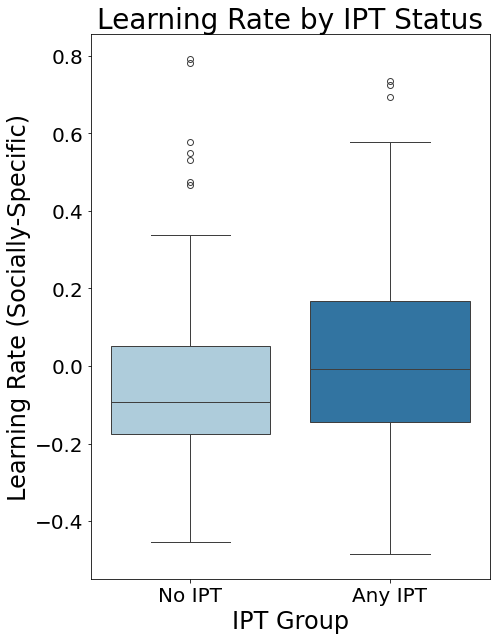

In [ ]:
# Visualize mean socially-specific learning rates for IPT vs no IPT
n_no_ipt = len(group_no_ipt)
n_any_ipt = len(group_any_ipt)
sems = [sd_no_ipt / np.sqrt(n_no_ipt), sd_any_ipt / np.sqrt(n_any_ipt)]

plt.figure(figsize=(7, 9))
sns.boxplot(
    x=['No IPT'] * n_no_ipt + ['Any IPT'] * n_any_ipt,
    y=pd.concat([group_no_ipt, group_any_ipt]),
    palette=['#a6cee3', '#1f78b4']
)
plt.ylabel('Learning Rate (Socially-Specific)', fontsize=24)
plt.xlabel('IPT Group', fontsize=24)
plt.title('Learning Rate by IPT Status', fontsize=28)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.savefig('LRIPT.svg', format='svg')  # <-- Export as SVG
plt.show()


In [ ]:
# Group socially-specific learning rates by IPT age status (childhood vs adulthood-only)

regression_df = pd.DataFrame({
    'interpersonal_chronicity' : merged_df['interpersonal_chronicity'],
    'chronic_childhood_interpersonal' : lec_df['chronic_childhood_interpersonal'],
    'subjLR_3prm': allLrnSumm['subjLR_3prm_predsoc'],
    'interpersonal_childhood_trunc': lec_df['interpersonal_childhood_trunc'],
    'interpersonal_adult_load_trunc': lec_df['interpersonal_adult_trunc'],
    'interpersonal_load_trunc': lec_df['interpersonal_load_trunc'],
    'BirthSex': datForAndrea.loc[good_candidates, 'BirthSex'],
    'Race': datForAndrea.loc[good_candidates, 'Race'],
    'HLS_ethnicity': datForAndrea.loc[good_candidates, 'HLS_ethnicity'],
    'Age': datForAndrea.loc[good_candidates, 'Age']
}).dropna()

regression_df = regression_df[regression_df['interpersonal_load_trunc'] > 0]

# Split into childhood IPT and adulthood-only IPT
childhood_group = (regression_df['interpersonal_childhood_trunc'] > 0)
adulthood_group = (regression_df['interpersonal_load_trunc'] > 0) & (regression_df['interpersonal_childhood_trunc'] == 0)

from scipy.stats import ttest_ind
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    pooled_sd = np.sqrt(((nx-1)*x.std()**2 + (ny-1)*y.std()**2) / (nx+ny-2))
    return (x.mean() - y.mean()) / pooled_sd

# Calculate stats
mean_childhood = regression_df[childhood_group]['subjLR_3prm'].mean()
sd_childhood = regression_df[childhood_group]['subjLR_3prm'].std()
mean_adulthood = regression_df[adulthood_group]['subjLR_3prm'].mean()
sd_adulthood = regression_df[adulthood_group]['subjLR_3prm'].std()
t_stat, p_val = ttest_ind(regression_df[childhood_group]['subjLR_3prm'], regression_df[adulthood_group]['subjLR_3prm'], nan_policy='omit')
d = cohens_d(regression_df[childhood_group]['subjLR_3prm'], regression_df[adulthood_group]['subjLR_3prm'])

print(f"Mean LR (childhood IPT): {mean_childhood:.3f} ± {sd_childhood:.3f}")
print(f"Mean LR (adulthood IPT): {mean_adulthood:.3f} ± {sd_adulthood:.3f}")
print(f"Independent samples t-test: t={t_stat:.2f}, p={p_val:.3f}, Cohen's d={d:.3f}")

Mean LR (childhood IPT): 0.023 ± 0.222
Mean LR (adulthood IPT): 0.021 ± 0.223
Independent samples t-test: t=0.06, p=0.954, Cohen's d=0.008


In [ ]:


# adult with childhood trauma
adulthood_w_childhood_mask = (regression_df['interpersonal_load_trunc'] > 0) & (regression_df['interpersonal_childhood_trunc'] > 0)

#adult without childhood trauma
adulthood_wo_childhood_mask = (regression_df['interpersonal_load_trunc'] > 0) & (regression_df['interpersonal_childhood_trunc'] == 0)
    
adulthood_w_childhood = regression_df[adulthood_w_childhood_mask]['subjLR_3prm']
adulthood_wo_childhood = regression_df[adulthood_wo_childhood_mask]['subjLR_3prm']

adulthood_w_childhood.mean(), adulthood_wo_childhood.mean()
print(f"Mean LR (adulthood IPT with childhood IPT): {adulthood_w_childhood.mean():.3f} ± {adulthood_w_childhood.std():.3f}")
print(f"Mean LR (adulthood IPT without childhood IPT): {adulthood_wo_childhood.mean():.3f} ± {adulthood_wo_childhood.std():.3f}")
# Independent samples t-test
print(adulthood_w_childhood.shape, adulthood_wo_childhood.shape)


t_stat, p_val = ttest_ind(adulthood_w_childhood, adulthood_wo_childhood, nan_policy='omit')
print(f"t-test: t={t_stat:.2f}, p={p_val:.3f}")

Mean LR (adulthood IPT with childhood IPT): 0.023 ± 0.222
Mean LR (adulthood IPT without childhood IPT): 0.021 ± 0.223
(94,) (118,)
t-test: t=0.06, p=0.954


<span style="font-size: 48px;">11: IPT X Learning Rate Regression</span>


In [ ]:
# Build regression DataFrame for Learning Rates (socially-specific)
regression_df = pd.DataFrame({
    'LR_predsoc': merged_df['subjLR_3prm_predsoc'],
    'interpersonal_childhood': lec_df['interpersonal_childhood'],
    'interpersonal_load': lec_df['interpersonal_load'],
    'BirthSex': datForAndrea.loc[good_candidates, 'BirthSex'],
    'Race': datForAndrea.loc[good_candidates, 'Race'],
    'HLS_ethnicity': datForAndrea.loc[good_candidates, 'HLS_ethnicity'],
    'Age': datForAndrea.loc[good_candidates, 'Age']
}).dropna()

regression_df = regression_df[regression_df['interpersonal_load'] > 0]

from sklearn.preprocessing import StandardScaler

# Standardize predictors and outcome
scaler = StandardScaler()
X_unadj_std = scaler.fit_transform(regression_df[['interpersonal_load']])
y_std = scaler.fit_transform(regression_df[['LR_predsoc']]).flatten()
X_unadj_std = sm.add_constant(X_unadj_std)
model_unadj_std = sm.OLS(y_std, X_unadj_std).fit()
std_beta_unadj = model_unadj_std.params[1]
print(f"Unadjusted regression standardized beta: {std_beta_unadj:.3f}, p={model_unadj_std.pvalues[1]:.3g}")
#print(model_unadj_std.summary())

# Adjusted regression (standardize all predictors)
X_adj_std = scaler.fit_transform(regression_df[['interpersonal_load', 'BirthSex', 'Race', 'HLS_ethnicity', 'Age']])
X_adj_std = sm.add_constant(X_adj_std)
model_adj_std = sm.OLS(y_std, X_adj_std).fit()
std_beta_adj = model_adj_std.params[1]
print(f"\nAdjusted regression standardized beta (interpersonal_load): {std_beta_adj:.3f}, p={model_adj_std.pvalues[1]:.3g}")
#print(model_adj_std.summary())

Unadjusted regression standardized beta: -0.156, p=0.0233

Adjusted regression standardized beta (interpersonal_load): -0.201, p=0.00454


<span style="font-size: 48px;">12: Social alone x LRs</span>


In [ ]:
# Build regression DataFrame for Learning Rates (social ALONE)
regression_df = pd.DataFrame({
    'subjLR_3prm': oneLRTRUST['subjLR_3prm'],
    'interpersonal_childhood': lec_df['interpersonal_childhood'],
    'interpersonal_load': lec_df['interpersonal_load'],
    'BirthSex': datForAndrea.loc[good_candidates, 'BirthSex'],
    'Race': datForAndrea.loc[good_candidates, 'Race'],
    'HLS_ethnicity': datForAndrea.loc[good_candidates, 'HLS_ethnicity'],
    'Age': datForAndrea.loc[good_candidates, 'Age']
}).dropna()

regression_df = regression_df[regression_df['interpersonal_load'] > 0]

from sklearn.preprocessing import StandardScaler

# Standardize predictors and outcome
scaler = StandardScaler()
X_unadj_std = scaler.fit_transform(regression_df[['interpersonal_load']])
y_std = scaler.fit_transform(regression_df[['subjLR_3prm']]).flatten()
X_unadj_std = sm.add_constant(X_unadj_std)
model_unadj_std = sm.OLS(y_std, X_unadj_std).fit()
std_beta_unadj = model_unadj_std.params[1]
print(f"Unadjusted regression standardized beta: {std_beta_unadj:.3f}, p={model_unadj_std.pvalues[1]:.3g}")
print(model_unadj_std.summary())

# Adjusted regression (standardize all predictors)
X_adj_std = scaler.fit_transform(regression_df[['interpersonal_load', 'BirthSex', 'Race', 'HLS_ethnicity', 'Age']])
X_adj_std = sm.add_constant(X_adj_std)
model_adj_std = sm.OLS(y_std, X_adj_std).fit()
std_beta_adj = model_adj_std.params[1]
print(f"\nAdjusted regression standardized beta (interpersonal_load): {std_beta_adj:.3f}, p={model_adj_std.pvalues[1]:.3g}")
print(model_adj_std.summary())

Unadjusted regression standardized beta: -0.125, p=0.0696
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     3.326
Date:                Tue, 23 Dec 2025   Prob (F-statistic):             0.0696
Time:                        15:10:48   Log-Likelihood:                -299.15
No. Observations:                 212   AIC:                             602.3
Df Residuals:                     210   BIC:                             609.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

<span style="font-size: 48px;">13: Child IPT X Social Alone </span>


In [ ]:

regression_df = pd.DataFrame({
    'subjLR_3prm': oneLRTRUST['subjLR_3prm'],
    'interpersonal_childhood': lec_df['interpersonal_childhood'],
    'interpersonal_load': lec_df['interpersonal_load'],
    'BirthSex': datForAndrea.loc[good_candidates, 'BirthSex'],
    'Race': datForAndrea.loc[good_candidates, 'Race'],
    'HLS_ethnicity': datForAndrea.loc[good_candidates, 'HLS_ethnicity'],
    'Age': datForAndrea.loc[good_candidates, 'Age']
}).dropna()

# Group social alone learning rates by childhood IPT status
group_no_ipt = regression_df[regression_df['interpersonal_childhood'] == 0]['subjLR_3prm']
group_any_ipt = regression_df[regression_df['interpersonal_childhood'] > 0]['subjLR_3prm']

from scipy.stats import ttest_ind
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    pooled_sd = np.sqrt(((nx-1)*x.std()**2 + (ny-1)*y.std()**2) / (nx+ny-2))
    return (x.mean() - y.mean()) / pooled_sd

# Calculate stats
mean_no_ipt = group_no_ipt.mean()
sd_no_ipt = group_no_ipt.std()
mean_any_ipt = group_any_ipt.mean()
sd_any_ipt = group_any_ipt.std()
t_stat, p_val = ttest_ind(group_no_ipt, group_any_ipt, nan_policy='omit')
d = cohens_d(group_no_ipt, group_any_ipt)

print(f"Mean LR (no child IPT): {mean_no_ipt:.3f} ± {sd_no_ipt:.3f}")
print(f"Mean LR (any child IPT): {mean_any_ipt:.3f} ± {sd_any_ipt:.3f}")
print(f"Independent samples t-test: t={t_stat:.2f}, p={p_val:.3f}, Cohen's d={d:.3f}")



Mean LR (no child IPT): 0.261 ± 0.238
Mean LR (any child IPT): 0.305 ± 0.250
Independent samples t-test: t=-1.51, p=0.132, Cohen's d=-0.181


<span style="font-size: 48px;">14: Child IPT X Learning Rate Regression</span>


Childhood IPT: std. β=-0.292, p=0.004
Predictor(s): ['interpersonal_load_trunc'] | Outcome: subjLR_3prm
Adulthood-only IPT: std. β=-0.031, p=0.739
Predictor(s): ['interpersonal_load_trunc'] | Outcome: subjLR_3prm
Chronic IPT: std. β=-0.204, p=0.027
Predictor(s): ['interpersonal_load_trunc'] | Outcome: subjLR_3prm
Acute IPT: std. β=-0.115, p=0.268
Predictor(s): ['interpersonal_load_trunc'] | Outcome: subjLR_3prm
Chronic Childhood IPT: std. β=-0.291, p=0.025
Predictor(s): ['interpersonal_load_trunc'] | Outcome: subjLR_3prm
Acute Childhood IPT: std. β=-0.284, p=0.099
Predictor(s): ['interpersonal_load_trunc'] | Outcome: subjLR_3prm
Chronic Adulthood IPT: std. β=-0.040, p=0.774
Predictor(s): ['interpersonal_load_trunc'] | Outcome: subjLR_3prm
Acute Adulthood IPT: std. β=-0.124, p=0.335
Predictor(s): ['interpersonal_load_trunc'] | Outcome: subjLR_3prm
Childhood IPT w/ demos: std. β=-0.342, p=0.001
Predictor(s): ['interpersonal_load_trunc', 'BirthSex', 'Race', 'HLS_ethnicity', 'Age'] | Outco

C:\Users\mnand\AppData\Local\Temp/ipykernel_87976/4293907361.py:125: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


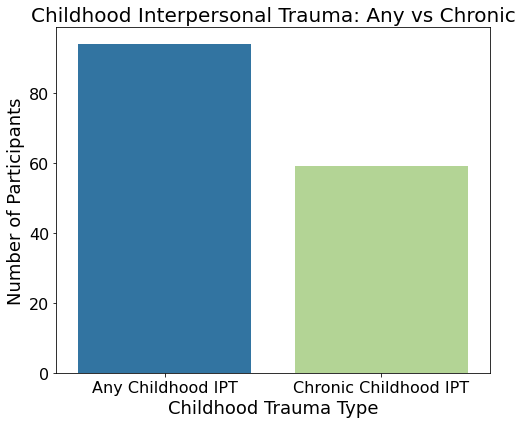

In [ ]:
# Build regression DataFrame for Learning Rates (socially-specific)
regression_df = pd.DataFrame({
    'interpersonal_chronicity' : merged_df['interpersonal_chronicity'],
    'chronic_childhood_interpersonal' : lec_df['chronic_childhood_interpersonal'],
    'subjLR_3prm': allLrnSumm['subjLR_3prm_predsoc'],
    'interpersonal_childhood_trunc': lec_df['interpersonal_childhood_trunc'],
    'interpersonal_adult_load_trunc': lec_df['interpersonal_adult_trunc'],
    'interpersonal_load_trunc': lec_df['interpersonal_load_trunc'],
    'BirthSex': datForAndrea.loc[good_candidates, 'BirthSex'],
    'Race': datForAndrea.loc[good_candidates, 'Race'],
    'HLS_ethnicity': datForAndrea.loc[good_candidates, 'HLS_ethnicity'],
    'Age': datForAndrea.loc[good_candidates, 'Age']
}).dropna()

regression_df = regression_df[regression_df['interpersonal_load_trunc'] > 0]

# Split into childhood IPT and adulthood-only IPT
childhood_mask = (regression_df['interpersonal_childhood_trunc'] > 0)
adulthood_mask = (regression_df['interpersonal_load_trunc'] > 0) & (regression_df['interpersonal_childhood_trunc'] == 0)

# Chronic trauma mask (chronicity > 0)
chronic_mask = (regression_df['interpersonal_chronicity'] > 0)
acute_mask = (regression_df['interpersonal_chronicity'] == 0)


# Chronic childhood IPT mask
chronic_child_mask = regression_df['chronic_childhood_interpersonal'] > 0
# Acute childhood IPT mask
acute_child_mask = (regression_df['interpersonal_childhood_trunc'] > 0) & (regression_df['chronic_childhood_interpersonal'] == 0)


from sklearn.preprocessing import StandardScaler

def run_standardized_reg(df, label):
    scaler = StandardScaler()
    predictors = ['interpersonal_load_trunc']
    X = scaler.fit_transform(df[predictors])
    y = scaler.fit_transform(df[['subjLR_3prm']]).flatten()
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[1]
    pval = model.pvalues[1]
    print(f"{label}: std. β={beta:.3f}, p={pval:.3f}")
    print(f"Predictor(s): {predictors} | Outcome: subjLR_3prm")
    #print(model.summary())


# Childhood IPT group
run_standardized_reg(regression_df[childhood_mask], "Childhood IPT")

# Adulthood-only IPT group
run_standardized_reg(regression_df[adulthood_mask], "Adulthood-only IPT")

# Chronic IPT group
run_standardized_reg(regression_df[chronic_mask], "Chronic IPT")

# Acute IPT group
run_standardized_reg(regression_df[acute_mask], "Acute IPT")

#chronic childhood IPT
run_standardized_reg(regression_df[chronic_child_mask], "Chronic Childhood IPT")

# Regression for acute childhood IPT group
run_standardized_reg(regression_df[acute_child_mask], "Acute Childhood IPT")

#chronic adulthood IPT
chronic_adult_mask = (regression_df['interpersonal_load_trunc'] > 0) & (regression_df['interpersonal_childhood_trunc'] == 0) & (regression_df['interpersonal_chronicity'] > 0)
run_standardized_reg(regression_df[chronic_adult_mask], "Chronic Adulthood IPT")

#acute adulthood IPT
acute_adult_mask = (regression_df['interpersonal_load_trunc'] > 0) & (regression_df['interpersonal_childhood_trunc'] == 0) & (regression_df['interpersonal_chronicity'] == 0)
run_standardized_reg(regression_df[acute_adult_mask], "Acute Adulthood IPT")


def run_standardized_reg_demo(df, label):
    scaler = StandardScaler()
    predictors = ['interpersonal_load_trunc', 'BirthSex', 'Race', 'HLS_ethnicity','Age']
    X = scaler.fit_transform(df[predictors])
    y = scaler.fit_transform(df[['subjLR_3prm']]).flatten()
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[1]
    pval = model.pvalues[1]
    print(f"{label}: std. β={beta:.3f}, p={pval:.3f}")
    print(f"Predictor(s): {predictors} | Outcome: subjLR_3prm")

    #print(model.summary())

# Childhood IPT group
run_standardized_reg_demo(regression_df[childhood_mask], "Childhood IPT w/ demos")

# Adulthood-only IPT group
run_standardized_reg_demo(regression_df[adulthood_mask], "Adulthood-only IPT w/ demos")


# Chronic IPT group
run_standardized_reg_demo(regression_df[chronic_mask], "Chronic IPT w/ demos")

# Acute IPT group
run_standardized_reg_demo(regression_df[acute_mask], "Acute IPT w/demos")

#chronic childhood IPT
run_standardized_reg_demo(regression_df[chronic_child_mask], "Chronic Childhood IPT w/demos")

# Regression for acute childhood IPT group
run_standardized_reg_demo(regression_df[acute_child_mask], "Acute Childhood IPT w/demos")

#chronic adulthood IPT
run_standardized_reg_demo(regression_df[chronic_adult_mask], "Chronic Adulthood IPT w/demos")

#acute adulthood IPT
run_standardized_reg_demo(regression_df[acute_adult_mask], "Acute Adulthood IPT w/demos")

#of those with chronic trauma, how much had any childhood trauma
import seaborn as sns

# Count participants with any childhood IPT and chronic childhood IPT
n_childhood = (regression_df['interpersonal_childhood_trunc'] > 0).sum()
n_chronic_childhood = (regression_df['chronic_childhood_interpersonal'] > 0).sum()

print(n_childhood)
print(n_chronic_childhood)

plt.figure(figsize=(7,6))
sns.barplot(
    x=['Any Childhood IPT', 'Chronic Childhood IPT'],
    y=[n_childhood, n_chronic_childhood],
    palette=['#1f78b4', '#b2df8a']
)
plt.ylabel('Number of Participants', fontsize=18)
plt.xlabel('Childhood Trauma Type', fontsize=18)
plt.title('Childhood Interpersonal Trauma: Any vs Chronic', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
#Apparently, a strong predictor of if Adult IPT will be associated with learning rate 
# is whether the individual also experienced childhood IPT

regression_df = pd.DataFrame({
   
    'subjLR_3prm': allLrnSumm['subjLR_3prm_predsoc'],

    'interpersonal_adult_load_trunc': lec_df['interpersonal_adult_trunc'],

    'interpersonal_childhood_trunc': lec_df['interpersonal_childhood_trunc'],
    'interpersonal_load_trunc': lec_df['interpersonal_load_trunc'],


    'BirthSex': datForAndrea.loc[good_candidates, 'BirthSex'],
    'Race': datForAndrea.loc[good_candidates, 'Race'],
    'HLS_ethnicity': datForAndrea.loc[good_candidates, 'HLS_ethnicity'],
    'Age': datForAndrea.loc[good_candidates, 'Age']
}).dropna()


# Split into childhood IPT and adulthood-only IPT
childhood_mask = (regression_df['interpersonal_childhood_trunc'] > 0) 
adulthood_mask = (regression_df['interpersonal_load_trunc'] > 0) & (regression_df['interpersonal_childhood_trunc'] == 0)

childhood_only_mask = (regression_df['interpersonal_childhood_trunc'] > 0) & (regression_df['interpersonal_adult_load_trunc'] == 0)
regression_df = regression_df[regression_df['interpersonal_adult_load_trunc'] > 0]

def run_standardized_reg_adult(df, label):
    scaler = StandardScaler()
    predictor = ['interpersonal_adult_load_trunc']
    X = scaler.fit_transform(df[predictor])
    y = scaler.fit_transform(df[['subjLR_3prm']]).flatten()
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[1]
    pval = model.pvalues[1]
    print(f"{label}: std. β={beta:.3f}, p={pval:.3f}")
    print(f"Predictor(s): {predictor} | Outcome: subjLR_3prm")
    #print(model.summary())

def run_standardized_reg_child(df, label):
    scaler = StandardScaler()
    predictor = ['interpersonal_childhood_trunc']
    X = scaler.fit_transform(df[predictor])
    y = scaler.fit_transform(df[['subjLR_3prm']]).flatten()
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[1]
    pval = model.pvalues[1]
    print(f"{label}: std. β={beta:.3f}, p={pval:.3f}")
    print(f"Predictor(s): {predictor} | Outcome: subjLR_3prm")
    #print(model.summary())

def run_standardized_reg_child_demos(df, label):
    scaler = StandardScaler()
    predictor = ['interpersonal_childhood_trunc', 'BirthSex', 'Race', 'HLS_ethnicity','Age']
    X = scaler.fit_transform(df[predictor])
    y = scaler.fit_transform(df[['subjLR_3prm']]).flatten()
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[1]
    pval = model.pvalues[1]
    print(f"{label}: std. β={beta:.3f}, p={pval:.3f}")
    print(f"Predictor(s): {predictor} | Outcome: subjLR_3prm")
    #print(model.summary())


run_standardized_reg_adult(regression_df[childhood_mask], "Adult IPT with childhood IPT")

run_standardized_reg_adult(regression_df[adulthood_mask], "Adult IPT without childhood IPT")

run_standardized_reg_child(regression_df[childhood_mask], "Childhood IPT")

run_standardized_reg_child_demos(regression_df[childhood_mask], "Childhood IPT w/ demos")


def run_standardized_reg_adult_demo(df, label):
    scaler = StandardScaler()
    predictors = ['interpersonal_adult_load_trunc', 'BirthSex', 'Race', 'HLS_ethnicity','Age']
    X = scaler.fit_transform(df[predictors])
    y = scaler.fit_transform(df[['subjLR_3prm']]).flatten()
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[1]
    pval = model.pvalues[1]
    print(f"{label}: std. β={beta:.3f}, p={pval:.3f}")
    print(f"Predictor(s): {predictors} | Outcome: subjLR_3prm")
    #print(model.summary())


run_standardized_reg_adult_demo(regression_df[childhood_mask], "Adult IPT with childhood IPT w/ demos")

run_standardized_reg_adult_demo(regression_df[adulthood_mask], "Adult IPT without childhood IPT w/ demos")


Adult IPT with childhood IPT: std. β=-0.321, p=0.030
Predictor(s): ['interpersonal_adult_load_trunc'] | Outcome: subjLR_3prm
Adult IPT without childhood IPT: std. β=-0.031, p=0.739
Predictor(s): ['interpersonal_adult_load_trunc'] | Outcome: subjLR_3prm
Childhood IPT: std. β=-0.351, p=0.017
Predictor(s): ['interpersonal_childhood_trunc'] | Outcome: subjLR_3prm
Childhood IPT w/ demos: std. β=-0.419, p=0.004
Predictor(s): ['interpersonal_childhood_trunc', 'BirthSex', 'Race', 'HLS_ethnicity', 'Age'] | Outcome: subjLR_3prm
Adult IPT with childhood IPT w/ demos: std. β=-0.282, p=0.067
Predictor(s): ['interpersonal_adult_load_trunc', 'BirthSex', 'Race', 'HLS_ethnicity', 'Age'] | Outcome: subjLR_3prm
Adult IPT without childhood IPT w/ demos: std. β=-0.090, p=0.357
Predictor(s): ['interpersonal_adult_load_trunc', 'BirthSex', 'Race', 'HLS_ethnicity', 'Age'] | Outcome: subjLR_3prm


C:\Users\mnand\AppData\Local\Temp/ipykernel_87976/2436438736.py:68: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  run_standardized_reg_adult(regression_df[childhood_mask], "Adult IPT with childhood IPT")
C:\Users\mnand\AppData\Local\Temp/ipykernel_87976/2436438736.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  run_standardized_reg_adult(regression_df[adulthood_mask], "Adult IPT without childhood IPT")
C:\Users\mnand\AppData\Local\Temp/ipykernel_87976/2436438736.py:72: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  run_standardized_reg_child(regression_df[childhood_mask], "Childhood IPT")
C:\Users\mnand\AppData\Local\Temp/ipykernel_87976/2436438736.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  run_standardized_reg_child_demos(regression_df[childhood_mask], "Childhood IPT w/ demos")
C:\Users\mnand\AppData\Local\Temp/ipykernel_87976/2436438736.py:91: 

In [ ]:
len(regression_df[adulthood_mask])

C:\Users\mnand\AppData\Local\Temp/ipykernel_87976/1071498377.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(regression_df[adulthood_mask])


118

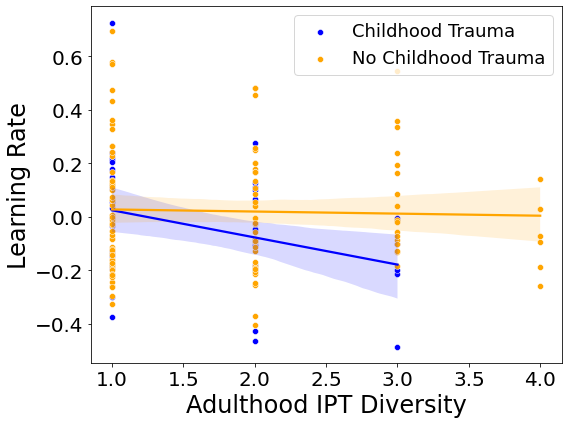

46 118


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt


plt.figure(figsize=(8,6))
sns.scatterplot(
    x=regression_df.loc[childhood_mask, 'interpersonal_adult_load_trunc'],
    y=regression_df.loc[childhood_mask, 'subjLR_3prm'],
    label='Childhood Trauma', color='blue'
)
sns.scatterplot(
    x=regression_df.loc[adulthood_mask, 'interpersonal_adult_load_trunc'],
    y=regression_df.loc[adulthood_mask, 'subjLR_3prm'],
    label='No Childhood Trauma', color='orange'
)

sns.regplot(
    x=regression_df.loc[childhood_mask, 'interpersonal_adult_load_trunc'],
    y=regression_df.loc[childhood_mask, 'subjLR_3prm'],
    scatter=False, color='blue'
)
sns.regplot(
    x=regression_df.loc[adulthood_mask, 'interpersonal_adult_load_trunc'],
    y=regression_df.loc[adulthood_mask, 'subjLR_3prm'],
    scatter=False, color='orange'
)

plt.xlabel('Adulthood IPT Diversity', fontsize=24)
plt.ylabel('Learning Rate', fontsize=24)
plt.legend(fontsize=18)
#plt.title('Trauma Load vs. Learning Rate by Childhood Trauma Group', fontsize=28)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.savefig('adultCtrauma_vs_lr.svg', format='svg')  # <-- Export as SVG
plt.show()

print(childhood_mask.sum(), adulthood_mask.sum())

Mean LR (chronic childhood IPT): 0.011 ± 0.205
Mean LR (acute childhood IPT): 0.044 ± 0.252
t-test: t=-0.69, p=0.494, Cohen's d=-0.147


C:\Users\mnand\AppData\Local\Temp/ipykernel_47008/784262863.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


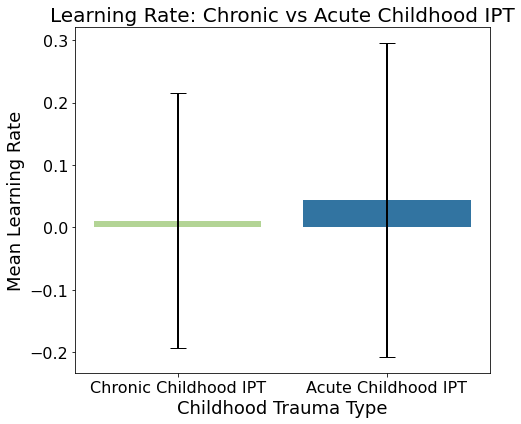

In [ ]:
# Chronic childhood IPT: chronic_childhood_interpersonal > 0
chronic_child_mask = regression_df['chronic_childhood_interpersonal'] > 0

# Acute childhood IPT: interpersonal_childhood_trunc > 0 and chronic_childhood_interpersonal == 0
acute_child_mask = (regression_df['interpersonal_childhood_trunc'] > 0) & (regression_df['chronic_childhood_interpersonal'] == 0)

# Compare mean learning rates for chronic vs acute childhood IPT
group_chronic = regression_df[chronic_child_mask]['subjLR_3prm']
group_acute = regression_df[acute_child_mask]['subjLR_3prm']

from scipy.stats import ttest_ind
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    pooled_sd = np.sqrt(((nx-1)*x.std()**2 + (ny-1)*y.std()**2) / (nx+ny-2))
    return (x.mean() - y.mean()) / pooled_sd

mean_chronic = group_chronic.mean()
sd_chronic = group_chronic.std()
mean_acute = group_acute.mean()
sd_acute = group_acute.std()
t_stat, p_val = ttest_ind(group_chronic, group_acute, nan_policy='omit')
d = cohens_d(group_chronic, group_acute)

print(f"Mean LR (chronic childhood IPT): {mean_chronic:.3f} ± {sd_chronic:.3f}")
print(f"Mean LR (acute childhood IPT): {mean_acute:.3f} ± {sd_acute:.3f}")
print(f"t-test: t={t_stat:.2f}, p={p_val:.3f}, Cohen's d={d:.3f}")

# Optional: visualize
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(7,6))
sns.barplot(
    x=['Chronic Childhood IPT', 'Acute Childhood IPT'],
    y=[mean_chronic, mean_acute],
    palette=['#b2df8a', '#1f78b4']
)
plt.errorbar(
    x=[0, 1],
    y=[mean_chronic, mean_acute],
    yerr=[sd_chronic, sd_acute],
    fmt='none',
    ecolor='black',
    capsize=8,
    linewidth=2
)
plt.ylabel('Mean Learning Rate', fontsize=18)
plt.xlabel('Childhood Trauma Type', fontsize=18)
plt.title('Learning Rate: Chronic vs Acute Childhood IPT', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
print(allLrnSumm.columns)

Index(['subjLR_3prm_predsoc', 'subjD_3prm_predsoc', 'subjp0_3prm_predsoc',
       'subjNLL_3prm_predsoc', 'subjLRTp_3prm_predsoc'],
      dtype='object')


In [ ]:
# Build regression DataFrame for Learning Rates (socially-specific)
regression_df = pd.DataFrame({
    'subjLR_3prm': allLrnSumm['subjLR_3prm_predsoc'],
    'subjD_3prm':allLrnSumm['subjD_3prm_predsoc'],
    'subjp0_3prm': allLrnSumm['subjp0_3prm_predsoc'],
    'CTQ' :CTQTot,
    'BirthSex': datForAndrea.loc[good_candidates, 'BirthSex'],
    'Race': datForAndrea.loc[good_candidates, 'Race'],
    'HLS_ethnicity': datForAndrea.loc[good_candidates, 'HLS_ethnicity'],
    'Age': datForAndrea.loc[good_candidates, 'Age']
}).dropna()

# Standardize interpersonal_load and init_offer_predsoc for each group

from sklearn.preprocessing import StandardScaler

def run_standardized_reg(df, label):
    scaler = StandardScaler()
    X = scaler.fit_transform(df[['CTQ']])
    y = scaler.fit_transform(df[['subjLR_3prm']]).flatten()
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[1]
    pval = model.pvalues[1]
    print(f"{label}: std. β={beta:.3f}, p={pval:.3f}")
    #print(model.summary())

# Childhood IPT group
run_standardized_reg(regression_df, "CTQTot")


def run_standardized_reg_demo(df, label):
    scaler = StandardScaler()
    X = scaler.fit_transform(df[['CTQ', 'BirthSex', 'Race', 'HLS_ethnicity','Age']])
    y = scaler.fit_transform(df[['subjLR_3prm']]).flatten()
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[1]
    pval = model.pvalues[1]
    print(f"{label}: std. β={beta:.3f}, p={pval:.3f}")
    print(model.summary())

run_standardized_reg_demo(regression_df, "CTQ + Demographics")

CTQTot: std. β=0.119, p=0.040
CTQ + Demographics: std. β=0.094, p=0.123


In [ ]:
from sklearn.preprocessing import StandardScaler

# Convert categorical variables to dummies
df = regression_df.copy()


outcomes = ['subjLR_3prm', 'subjD_3prm', 'subjp0_3prm']
predictor = ['CTQ']
predictors = ['CTQ', 'BirthSex', 'Race', 'HLS_ethnicity','Age']

for outcome in outcomes:
    scaler = StandardScaler()
    X = scaler.fit_transform(df[predictor])
    y = scaler.fit_transform(df[[outcome]]).flatten()
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[1]  # CTQ standardized beta
    pval = model.pvalues[1]
    print(f"{outcome} ~ CTQ + std. β={beta:.3f}, p={pval:.3f}")
    #print(model.summary())



for outcome in outcomes:
    scaler = StandardScaler()
    X = scaler.fit_transform(df[predictors])
    y = scaler.fit_transform(df[[outcome]]).flatten()
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[1]  # CTQ standardized beta
    pval = model.pvalues[1]
    print(f"{outcome} ~ CTQ + Demographics std. β={beta:.3f}, p={pval:.3f}")
    #print(model.summary())

subjLR_3prm ~ CTQ + std. β=0.119, p=0.040
subjD_3prm ~ CTQ + std. β=-0.004, p=0.944
subjp0_3prm ~ CTQ + std. β=0.053, p=0.360
subjLR_3prm ~ CTQ + Demographics std. β=0.094, p=0.123
subjD_3prm ~ CTQ + Demographics std. β=-0.067, p=0.271
subjp0_3prm ~ CTQ + Demographics std. β=0.120, p=0.047


<span style="font-size: 48px;">15: Child IPT X Learning Rate Mixed Effects</span>

In [ ]:

regression_df = pd.DataFrame({
    'LR_predsoc': allLrnSumm['subjLR_3prm_predsoc'],
    'interpersonal_childhood': lec_df['interpersonal_childhood_trunc'],
    'interpersonal_adult': lec_df['interpersonal_adult_trunc'],
}).dropna()
regression_df = regression_df[(regression_df['interpersonal_childhood'] > 0) | (regression_df['interpersonal_adult'] > 0)]

import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
model = smf.ols(
    formula="LR_predsoc ~ interpersonal_childhood * interpersonal_adult",
    data=regression_df
).fit()

anova_results = anova_lm(model)
print(anova_results)



                                                df    sum_sq   mean_sq  \
interpersonal_childhood                        1.0  0.000382  0.000382   
interpersonal_adult                            1.0  0.292562  0.292562   
interpersonal_childhood:interpersonal_adult    1.0  0.454104  0.454104   
Residual                                     208.0  9.661779  0.046451   

                                                    F    PR(>F)  
interpersonal_childhood                      0.008230  0.927801  
interpersonal_adult                          6.298310  0.012848  
interpersonal_childhood:interpersonal_adult  9.776006  0.002021  
Residual                                          NaN       NaN  


In [ ]:
regression_df = pd.DataFrame({
    'LR_predsoc': allLrnSumm['subjLR_3prm_predsoc'],
    #mask the ipt child yn to only include IPT 0s
    'interpersonal_childhood': lec_df['IPT_child_yn'],
    'interpersonal_adult': lec_df['interpersonal_load'],
}).dropna()
regression_df = regression_df[(regression_df['interpersonal_adult'] > 0)]

import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
model = smf.ols(
    formula="LR_predsoc ~ interpersonal_childhood * interpersonal_adult",
    data=regression_df
).fit()

anova_results = anova_lm(model)
print(anova_results)



#did i use the wrong interpersonal chid hood

                                                df    sum_sq   mean_sq  \
interpersonal_childhood                        1.0  0.000165  0.000165   
interpersonal_adult                            1.0  0.272038  0.272038   
interpersonal_childhood:interpersonal_adult    1.0  0.142574  0.142574   
Residual                                     208.0  9.994050  0.048048   

                                                    F    PR(>F)  
interpersonal_childhood                      0.003439  0.953291  
interpersonal_adult                          5.661756  0.018243  
interpersonal_childhood:interpersonal_adult  2.967302  0.086450  
Residual                                          NaN       NaN  


In [ ]:

regression_df = pd.DataFrame({
    'LR_predsoc': allLrnSumm['subjLR_3prm_predsoc'],
    'interpersonal_childhood': CTQTot,
    'interpersonal_adult': lec_df['interpersonal_adult_trunc'],
}).dropna()
regression_df = regression_df[(regression_df['interpersonal_childhood'] > 0) | (regression_df['interpersonal_adult'] > 0)]

import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
model = smf.ols(
    formula="LR_predsoc ~ interpersonal_childhood * interpersonal_adult",
    data=regression_df
).fit()

anova_results = anova_lm(model)
print(anova_results)


                                                df     sum_sq   mean_sq  \
interpersonal_childhood                        1.0   0.213360  0.213360   
interpersonal_adult                            1.0   0.013953  0.013953   
interpersonal_childhood:interpersonal_adult    1.0   0.340968  0.340968   
Residual                                     292.0  14.401009  0.049319   

                                                    F    PR(>F)  
interpersonal_childhood                      4.326159  0.038403  
interpersonal_adult                          0.282919  0.595199  
interpersonal_childhood:interpersonal_adult  6.913597  0.009007  
Residual                                          NaN       NaN  


In [ ]:

regression_df = pd.DataFrame({
    'LR_predsoc': allLrnSumm['subjLR_3prm_predsoc'],
    'interpersonal_childhood': CTQTot,
    
}).dropna()

regression_df = regression_df[(regression_df['interpersonal_childhood'] > 0) ]

import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
model = smf.ols(
    formula="LR_predsoc ~ interpersonal_childhood",
    data=regression_df
).fit()

anova_results = anova_lm(model)
print(anova_results)


                            df     sum_sq  mean_sq         F    PR(>F)
interpersonal_childhood    1.0   0.213360  0.21336  4.251021  0.040105
Residual                 294.0  14.755931  0.05019       NaN       NaN


<span style="font-size: 48px;">15: Plot</span>

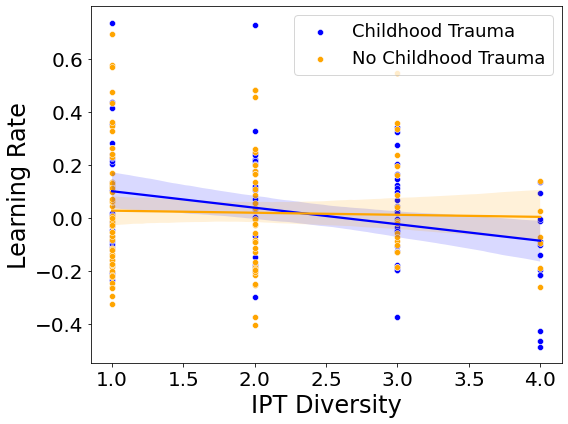

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
regression_df = pd.DataFrame({
    'LR_predsoc': allLrnSumm['subjLR_3prm_predsoc'],
    'interpersonal_load': lec_df['interpersonal_load_trunc'],
    'interpersonal_childhood': lec_df['interpersonal_childhood_trunc'],
}).dropna()

childhood_mask = (regression_df['interpersonal_childhood'] > 0)
adulthood_mask = (regression_df['interpersonal_load'] > 0) & (regression_df['interpersonal_childhood'] == 0)


plt.figure(figsize=(8,6))
sns.scatterplot(
    x=regression_df.loc[childhood_mask, 'interpersonal_load'],
    y=regression_df.loc[childhood_mask, 'LR_predsoc'],
    label='Childhood Trauma', color='blue'
)
sns.scatterplot(
    x=regression_df.loc[adulthood_mask, 'interpersonal_load'],
    y=regression_df.loc[adulthood_mask, 'LR_predsoc'],
    label='No Childhood Trauma', color='orange'
)

sns.regplot(
    x=regression_df.loc[childhood_mask, 'interpersonal_load'],
    y=regression_df.loc[childhood_mask, 'LR_predsoc'],
    scatter=False, color='blue'
)
sns.regplot(
    x=regression_df.loc[adulthood_mask, 'interpersonal_load'],
    y=regression_df.loc[adulthood_mask, 'LR_predsoc'],
    scatter=False, color='orange'
)

plt.xlabel('IPT Diversity', fontsize=24)
plt.ylabel('Learning Rate', fontsize=24)
plt.legend(fontsize=18)
#plt.title('Trauma Load vs. Learning Rate by Childhood Trauma Group', fontsize=28)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.savefig('Ctrauma_vs_lr.svg', format='svg')  # <-- Export as SVG
plt.show()

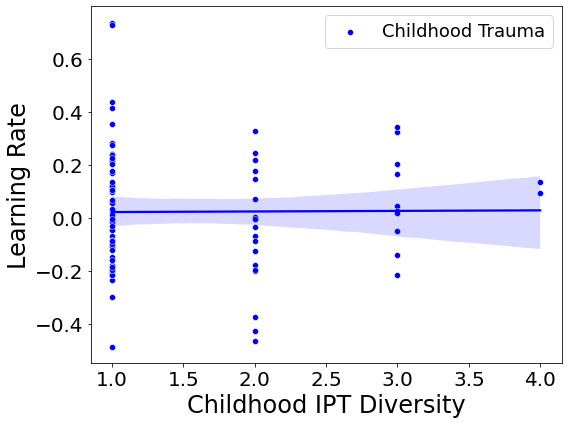

In [ ]:
#CHILDHOOD IPT 


import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
regression_df = pd.DataFrame({
    'LR_predsoc': allLrnSumm['subjLR_3prm_predsoc'],
   
    'interpersonal_childhood': lec_df['interpersonal_childhood_trunc'],
}).dropna()

childhood_mask = (regression_df['interpersonal_childhood'] > 0)


plt.figure(figsize=(8,6))
sns.scatterplot(
    x=regression_df.loc[childhood_mask, 'interpersonal_childhood'],
    y=regression_df.loc[childhood_mask, 'LR_predsoc'],
    label='Childhood Trauma', color='blue'
)

sns.regplot(
    x=regression_df.loc[childhood_mask, 'interpersonal_childhood'],
    y=regression_df.loc[childhood_mask, 'LR_predsoc'],
    scatter=False, color='blue'
)

plt.xlabel('Childhood IPT Diversity', fontsize=24)
plt.ylabel('Learning Rate', fontsize=24)
plt.legend(fontsize=18)
#plt.title('Trauma Load vs. Learning Rate by Childhood Trauma Group', fontsize=28)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.savefig('Ctrauma_vs_lr.svg', format='svg')  # <-- Export as SVG
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
regression_df = pd.DataFrame({
    'LR_predsoc': allLrnSumm['subjLR_3prm_predsoc'],
    'interpersonal_load': lec_df['interpersonal_load_trunc'],
    'interpersonal_childhood': lec_df['interpersonal_childhood_trunc'],
}).dropna()

childhood_mask = (regression_df['interpersonal_childhood'] > 0)
adulthood_mask = (regression_df['interpersonal_load'] > 0) & (regression_df['interpersonal_childhood'] == 0)


plt.figure(figsize=(8,6))
sns.scatterplot(
    x=regression_df.loc[childhood_mask, 'interpersonal_load'],
    y=regression_df.loc[childhood_mask, 'LR_predsoc'],
    label='Childhood Trauma', color='blue'
)
sns.scatterplot(
    x=regression_df.loc[adulthood_mask, 'interpersonal_load'],
    y=regression_df.loc[adulthood_mask, 'LR_predsoc'],
    label='No Childhood Trauma', color='orange'
)

sns.regplot(
    x=regression_df.loc[childhood_mask, 'interpersonal_load'],
    y=regression_df.loc[childhood_mask, 'LR_predsoc'],
    scatter=False, color='blue'
)
sns.regplot(
    x=regression_df.loc[adulthood_mask, 'interpersonal_load'],
    y=regression_df.loc[adulthood_mask, 'LR_predsoc'],
    scatter=False, color='orange'
)

plt.xlabel('IPT Diversity', fontsize=24)
plt.ylabel('Learning Rate', fontsize=24)
plt.legend(fontsize=18)
#plt.title('Trauma Load vs. Learning Rate by Childhood Trauma Group', fontsize=28)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.savefig('Ctrauma_vs_lr.svg', format='svg')  # <-- Export as SVG
plt.show()

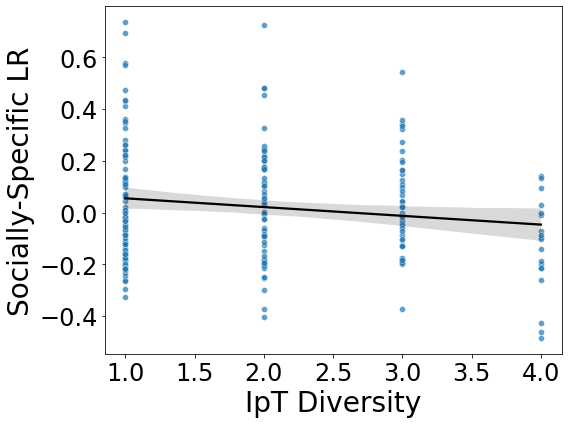

In [ ]:
import matplotlib.pyplot as plt
regression_df = pd.DataFrame({
    'LR_predsoc': allLrnSumm['subjLR_3prm_predsoc'],
    'interpersonal_load': lec_df['interpersonal_load_trunc'],
}).dropna()

regression_df = regression_df[(regression_df['interpersonal_load'] > 0)]

# Plot overall trauma load vs. socially-specific learning rate (no group split)
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=regression_df['interpersonal_load'],
    y=regression_df['LR_predsoc'],
    color='#1f78b4',  # blue
    alpha=0.7
)
sns.regplot(
    x=regression_df['interpersonal_load'],
    y=regression_df['LR_predsoc'],
    scatter=False,
    color='black'
)

plt.xlabel('IpT Diversity', fontsize=28)
plt.ylabel('Socially-Specific LR', fontsize=28)
#plt.title('Trauma Load vs. Learning Rate', fontsize=32)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.tight_layout()
plt.savefig('trauma_vs_lr.svg', format='svg')  # <-- Export as SVG
plt.show()

In [ ]:
#sanity check using damians data

damdat = pd.read_csv(r"C:\Users\mnand\Desktop\SNE Data Analysis\AndreaDissertationDataset.csv")



def happened_in_childhood1(val, age):
    if pd.isnull(val) or pd.isnull(age):
        return 0
    try:
        if int(val) == 0 and float(age) < 18:
            return 9
        return int(contains_1(val) and float(age) < 18)
    except:
        return 0


lec_cols_interest1 = ['LECA_6', 'LECA_7',  'LECA_8',  'LECA_9', 'LECA_10', 'LECA_11', 'LECA_17']
lec_age_cols1 = ['LEC6FUAge', 'LEC7FUAge', 'LEC8FUAge', 'LEC9FUAge', 'LEC10FUAge', 'LEC11FUAge', 'LEC16FUAge']
damdat['interpersonal_childhood'] = [
    sum(happened_in_childhood1(row[lec_col], row[age_col]) for lec_col, age_col in zip(lec_cols_interest1, lec_age_cols1))
    for _, row in damdat.iterrows()
]
count = (damdat['interpersonal_childhood'] == 9 ).sum()
print(count)

17


<span style="font-size: 48px;">16: Bias and IPT Regressions</span>

Mean bias (no IPT): 0.203 ± 0.335
Mean bias (any IPT): 0.220 ± 0.340
Independent samples t-test: t=-0.46, p=0.644, Cohen's d=-0.049


C:\Users\mnand\AppData\Local\Temp/ipykernel_47008/1530747419.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


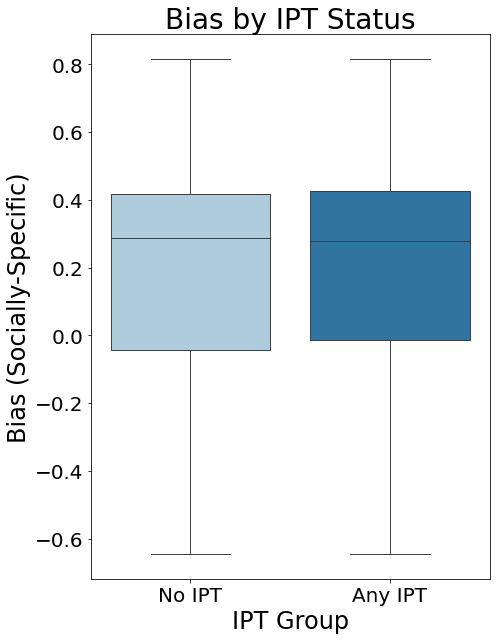

In [ ]:
merged_df = pd.merge(
    allLrnSumm,
    lec_df[['interpersonal_load', 'interpersonal_childhood', 'interpersonal_load_trunc', 'interpersonal_childhood_trunc','interpersonal_chronicity']],
    left_index=True,
    right_index=True
)
valid_candidates = merged_df.index.intersection(good_candidates)
merged_df = merged_df.loc[valid_candidates]

# Group socially-specific initial offers by IPT status
group_no_ipt = merged_df[merged_df['interpersonal_load'] == 0]['subjD_3prm_predsoc']
group_any_ipt = merged_df[merged_df['interpersonal_load'] > 0]['subjD_3prm_predsoc']

from scipy.stats import ttest_ind
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    pooled_sd = np.sqrt(((nx-1)*x.std()**2 + (ny-1)*y.std()**2) / (nx+ny-2))
    return (x.mean() - y.mean()) / pooled_sd

# Calculate stats
mean_no_ipt = group_no_ipt.mean()
sd_no_ipt = group_no_ipt.std()
mean_any_ipt = group_any_ipt.mean()
sd_any_ipt = group_any_ipt.std()
t_stat, p_val = ttest_ind(group_no_ipt, group_any_ipt, nan_policy='omit')
d = cohens_d(group_no_ipt, group_any_ipt)

print(f"Mean bias (no IPT): {mean_no_ipt:.3f} ± {sd_no_ipt:.3f}")
print(f"Mean bias (any IPT): {mean_any_ipt:.3f} ± {sd_any_ipt:.3f}")
print(f"Independent samples t-test: t={t_stat:.2f}, p={p_val:.3f}, Cohen's d={d:.3f}")
# Calculate SEM
n_no_ipt = len(group_no_ipt)
n_any_ipt = len(group_any_ipt)
plt.figure(figsize=(7, 9))
sns.boxplot(
    x=['No IPT'] * n_no_ipt + ['Any IPT'] * n_any_ipt,
    y=pd.concat([group_no_ipt, group_any_ipt]),
    palette=['#a6cee3', '#1f78b4']
)
plt.ylabel('Bias (Socially-Specific)', fontsize=24)
plt.xlabel('IPT Group', fontsize=24)
plt.title('Bias by IPT Status', fontsize=28)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.savefig('DIPT.svg', format='svg')  # <-- Export as SVG
plt.show()


In [ ]:
# Build regression DataFrame for Learning Rates (socially-specific)
regression_df = pd.DataFrame({
    'interpersonal_chronicity' : merged_df['interpersonal_chronicity'],
    'chronic_childhood_interpersonal' : lec_df['chronic_childhood_interpersonal'],
    'subjLR_3prm': allLrnSumm['subjLR_3prm_predsoc'],
    'subjD_3prm':allLrnSumm['subjD_3prm_predsoc'],
    'interpersonal_childhood_trunc': lec_df['interpersonal_childhood_trunc'],
    'interpersonal_adult_load_trunc': lec_df['interpersonal_adult_trunc'],
    'interpersonal_load_trunc': lec_df['interpersonal_load_trunc'],
    'BirthSex': datForAndrea.loc[good_candidates, 'BirthSex'],
    'Race': datForAndrea.loc[good_candidates, 'Race'],
    'HLS_ethnicity': datForAndrea.loc[good_candidates, 'HLS_ethnicity'],
    'Age': datForAndrea.loc[good_candidates, 'Age']
}).dropna()

regression_df = regression_df[regression_df['interpersonal_load_trunc'] > 0]

# Split into childhood IPT and adulthood-only IPT
childhood_mask = (regression_df['interpersonal_childhood_trunc'] > 0)
adulthood_mask = (regression_df['interpersonal_load_trunc'] > 0) & (regression_df['interpersonal_childhood_trunc'] == 0)

# Chronic trauma mask (chronicity > 0)
chronic_mask = (regression_df['interpersonal_chronicity'] > 0)
acute_mask = (regression_df['interpersonal_chronicity'] == 0)


# Chronic childhood IPT mask
chronic_child_mask = regression_df['chronic_childhood_interpersonal'] > 0
# Acute childhood IPT mask
acute_child_mask = (regression_df['interpersonal_childhood_trunc'] > 0) & (regression_df['chronic_childhood_interpersonal'] == 0)


from sklearn.preprocessing import StandardScaler

def run_standardized_reg(df, label):
    scaler = StandardScaler()
    predictors = ['interpersonal_load_trunc']
    X = scaler.fit_transform(df[predictors])
    y = scaler.fit_transform(df[['subjD_3prm']]).flatten()
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[1]
    pval = model.pvalues[1]
    print(f"{label}: std. β={beta:.3f}, p={pval:.3f}")
    print(f"Predictor(s): {predictors} | Outcome: subjD_3prm")
    #print(model.summary())

def run_standardized_reg_adult(df, label):
    scaler = StandardScaler()
    predictor = ['interpersonal_adult_load_trunc']
    X = scaler.fit_transform(df[predictor])
    y = scaler.fit_transform(df[['subjD_3prm']]).flatten()
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[1]
    pval = model.pvalues[1]
    print(f"{label}: std. β={beta:.3f}, p={pval:.3f}")
    print(f"Predictor(s): {predictor} | Outcome: subjD_3prm")
    #print(model.summary())


run_standardized_reg_adult(regression_df[childhood_mask], "Adult IPT with childhood IPT")
run_standardized_reg_adult(regression_df[adulthood_mask], "Adult IPT without childhood IPT")


def run_standardized_reg_adult_demo(df, label):
    scaler = StandardScaler()
    predictors = ['interpersonal_adult_load_trunc', 'BirthSex', 'Race', 'HLS_ethnicity','Age']
    X = scaler.fit_transform(df[predictors])
    y = scaler.fit_transform(df[['subjD_3prm']]).flatten()
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[1]
    pval = model.pvalues[1]
    print(f"{label}: std. β={beta:.3f}, p={pval:.3f}")
    print(f"Predictor(s): {predictors} | Outcome: subjD_3prm")
    #print(model.summary())


run_standardized_reg_adult_demo(regression_df[childhood_mask], "Adult IPT with childhood IPT w/ demos")
run_standardized_reg_adult_demo(regression_df[adulthood_mask], "Adult IPT without childhood IPT w/ demos")

# Childhood IPT group
run_standardized_reg(regression_df[childhood_mask], "Childhood IPT")

# Adulthood-only IPT group
run_standardized_reg(regression_df[adulthood_mask], "Adulthood-only IPT")

# Chronic IPT group
run_standardized_reg(regression_df[chronic_mask], "Chronic IPT")

# Acute IPT group
run_standardized_reg(regression_df[acute_mask], "Acute IPT")

#chronic childhood IPT
run_standardized_reg(regression_df[chronic_child_mask], "Chronic Childhood IPT")

# Regression for acute childhood IPT group
run_standardized_reg(regression_df[acute_child_mask], "Acute Childhood IPT")

#chronic adulthood IPT
run_standardized_reg(regression_df[chronic_adult_mask], "Chronic Adulthood IPT")

#acute adulthood IPT
run_standardized_reg(regression_df[acute_adult_mask], "Acute Adulthood IPT")


def run_standardized_reg_demo(df, label):
    scaler = StandardScaler()
    predictors = ['interpersonal_load_trunc', 'BirthSex', 'Race', 'HLS_ethnicity','Age']
    X = scaler.fit_transform(df[predictors])
    y = scaler.fit_transform(df[['subjD_3prm']]).flatten()
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[1]
    pval = model.pvalues[1]
    print(f"{label}: std. β={beta:.3f}, p={pval:.3f}")
    print(f"Predictor(s): {predictors} | Outcome: subjD_3prm")

    #print(model.summary())

# Childhood IPT group
run_standardized_reg_demo(regression_df[childhood_mask], "Childhood IPT w/ demos")

# Adulthood-only IPT group
run_standardized_reg_demo(regression_df[adulthood_mask], "Adulthood-only IPT w/ demos")


# Chronic IPT group
run_standardized_reg_demo(regression_df[chronic_mask], "Chronic IPT w/ demos")

# Acute IPT group
run_standardized_reg_demo(regression_df[acute_mask], "Acute IPT w/demos")

#chronic childhood IPT
run_standardized_reg_demo(regression_df[chronic_child_mask], "Chronic Childhood IPT w/demos")

# Regression for acute childhood IPT group
run_standardized_reg_demo(regression_df[acute_child_mask], "Acute Childhood IPT w/demos")

#chronic adulthood IPT
run_standardized_reg_demo(regression_df[chronic_adult_mask], "Chronic Adulthood IPT w/demos")

#acute adulthood IPT
run_standardized_reg_demo(regression_df[acute_adult_mask], "Acute Adulthood IPT w/demos")


Adult IPT with childhood IPT: std. β=-0.066, p=0.528
Predictor(s): ['interpersonal_adult_load_trunc'] | Outcome: subjD_3prm
Adult IPT without childhood IPT: std. β=0.093, p=0.318
Predictor(s): ['interpersonal_adult_load_trunc'] | Outcome: subjD_3prm
Adult IPT with childhood IPT w/ demos: std. β=-0.068, p=0.516
Predictor(s): ['interpersonal_adult_load_trunc', 'BirthSex', 'Race', 'HLS_ethnicity', 'Age'] | Outcome: subjD_3prm
Adult IPT without childhood IPT w/ demos: std. β=0.089, p=0.369
Predictor(s): ['interpersonal_adult_load_trunc', 'BirthSex', 'Race', 'HLS_ethnicity', 'Age'] | Outcome: subjD_3prm
Childhood IPT: std. β=0.056, p=0.593
Predictor(s): ['interpersonal_load_trunc'] | Outcome: subjD_3prm
Adulthood-only IPT: std. β=0.093, p=0.318
Predictor(s): ['interpersonal_load_trunc'] | Outcome: subjD_3prm
Chronic IPT: std. β=0.131, p=0.158
Predictor(s): ['interpersonal_load_trunc'] | Outcome: subjD_3prm
Acute IPT: std. β=0.009, p=0.929
Predictor(s): ['interpersonal_load_trunc'] | Outcome

## PRINCIPLE COMPONENT ANALYSES OF PTSD SCALES

In [ ]:
## need to do a PCA on the combined BPD and PTSD symptoms to create a composite score

#qsumm holds the questionnaire summary scores,lets take all PCL and SCID-II BPD columns
BPD_PTSD_df = qDat.loc[:, qDat.columns.str.startswith('PCL')|qDat.columns.str.startswith('SCID-II_BPD')]

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Select PCL columns ending in '.2' and SCID-II BPD columns ending in '.1'
pcl_cols = []
for col in BPD_PTSD_df.columns:
    if col.startswith('PCL'):
        try:
            # Extract question number, assuming format like 'PCL5-X.Y'
            question_num = int(col.split('-')[1].split('.')[0])
            
            # For questions 9 and 11-20, take the .3 column
            if (question_num == 9 or (11 <= question_num <= 20)) and col.endswith('.3'):
                pcl_cols.append(col)
            # For other questions, take the .2 column
            elif not (question_num == 9 or (11 <= question_num <= 20)) and col.endswith('.2'):
                pcl_cols.append(col)
        except (IndexError, ValueError):
            # Ignore columns that don't match the expected format
            continue
scid_cols = [col for col in BPD_PTSD_df.columns if col.startswith('SCID-II_BPD') and col.endswith('.1')]
# Combine the selected columns into a new DataFrame for PCA
pca_input_df = BPD_PTSD_df[pcl_cols + scid_cols].copy()


# Replace NaNs with 0s as requested
pca_input_df.fillna(0, inplace=True)

# Standardize the data before applying PCA
scaler = StandardScaler()
scaled_data = scaler.fit_transform(pca_input_df)

pca = PCA(n_components=5) 
principal_components = pca.fit_transform(scaled_data)

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

item_names = pca_input_df.columns

loading_df = pd.DataFrame(
    loadings,
    index=item_names,          # e.g. PCL5_01, SCID_BPD_03, ...
    columns=[f"PC{i+1}" for i in range(loadings.shape[1])]
)
# Define PTSD items as the first 20 rows and BPD items as the rest
ptsd_items = loading_df.index[:20]
bpd_items = loading_df.index[20:]

max_diff = -1
best_pc = None

# Iterate through the 5 principal components to find the one with the largest difference
for i in range(1, 6):
    pc = f"PC{i}"
    ptsd_mean = loading_df.loc[ptsd_items, pc].mean()
    bpd_mean  = loading_df.loc[bpd_items, pc].mean()
    diff = abs(ptsd_mean - bpd_mean)
    
    print(f"{pc}:")
    print(f"  Mean PTSD Loading: {ptsd_mean:.4f}")
    print(f"  Mean BPD Loading:  {bpd_mean:.4f}")
    print(f"  Absolute Difference: {diff:.4f}\n")

    if diff > max_diff:
        max_diff = diff
        best_pc = pc
print(f"The principal component with the largest difference is {best_pc} with a difference of {max_diff:.4f}")


# Create a DataFrame with the principal components
pc_df = pd.DataFrame(data=principal_components, 
                     columns=[f'PC{i+1}' for i in range(pca.n_components)],
                     index=pca_input_df.index)

# The first principal component (PC1) is used as the composite score
qDat['BPD_PTSD_Comp'] = pc_df['PC1']
qDat['BPD_PTSD_Uniq'] = pc_df['PC2']
# --- Explained Variance ---
print("Explained variance by component: ", pca.explained_variance_ratio_)
print(f"Total variance explained by {pca.n_components} components: {sum(pca.explained_variance_ratio_)*100:.2f}%")

# Display the head of the new composite score column
print("\nComposite Score Head:")
print(qDat[['BPD_PTSD_Composite']].head())
#transform the data to actually work with PCA, we want each Q to have a magnitude. So we first take every PCL column ending in .2, and replace NANs with 0s for not experienced
#IMPORTANT: for now, lets only take the .1 col of SCID, but disregard .2, which is a chronicity measure


PC1:
  Mean PTSD Loading: 0.6584
  Mean BPD Loading:  0.5703
  Absolute Difference: 0.0881

PC2:
  Mean PTSD Loading: -0.2023
  Mean BPD Loading:  0.3299
  Absolute Difference: 0.5322

PC3:
  Mean PTSD Loading: -0.0110
  Mean BPD Loading:  0.0286
  Absolute Difference: 0.0396

PC4:
  Mean PTSD Loading: -0.0313
  Mean BPD Loading:  0.0449
  Absolute Difference: 0.0762

PC5:
  Mean PTSD Loading: -0.0280
  Mean BPD Loading:  0.0302
  Absolute Difference: 0.0582

The principal component with the largest difference is PC2 with a difference of 0.5322
Explained variance by component:  [0.39381389 0.08215957 0.04674719 0.04446735 0.03319851]
Total variance explained by 5 components: 60.04%

Composite Score Head:
                          BPD_PTSD_Composite
PROLIFIC_PID                                
5f2f86864fd821374b4367bc           -3.005398
61492ac26b91b5b11ba2c88b            4.023581
60234c1d5a0cf81cba76ce5d           -3.504096
6362aca86b740b1ec4cb6efb           -2.619236
60fcd2b146529d02

In [ ]:
#now that we have a unique and common element, lets combine these for our covariates

In [ ]:
## Learning rate correlations with PC1
from scipy.stats import pearsonr
import pandas as pd

# Create a dataframe for correlation
corr_df = pd.DataFrame({
    'PC1': qDat['BPD_PTSD_Comp'],
    'LR_social_specific': allLrnSumm['subjLR_3prm_predsoc']
})

# Filter for good candidates and drop any missing values
valid_candidates = corr_df.index.intersection(good_candidates)
corr_df = corr_df.loc[valid_candidates].dropna()

# Calculate Pearson correlation
corr, p_value = pearsonr(corr_df['PC1'], corr_df['LR_social_specific'])

print(f"Correlation between PC1 (BPD/PTSD Composite) and Socially-Specific Learning Rate:")
print(f"n = {len(corr_df)}")
print(f"Pearson's r: {corr:.3f}")
print(f"P-value: {p_value:.3g}")

Correlation between PC1 (BPD/PTSD Composite) and Socially-Specific Learning Rate:
n = 363
Pearson's r: -0.015
P-value: 0.783


In [ ]:
from sklearn.preprocessing import StandardScaler

def run_standardized_reg(df, label):
    scaler = StandardScaler()
    predictors = ['PC1']
    X = scaler.fit_transform(df[predictors])
    y = scaler.fit_transform(df[['LR_social_specific']]).flatten()
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[1]
    pval = model.pvalues[1]
    print(f"{label}: std. β={beta:.3f}, p={pval:.3f}")
    print(f"Predictor(s): {predictors} | Outcome: LR_social_specific")
    #print(model.summary())

run_standardized_reg(corr_df, "PC1 predicting LR_social_specific")


PC1 predicting LR_social_specific: std. β=-0.015, p=0.783
Predictor(s): ['PC1'] | Outcome: LR_social_specific


In [ ]:
## Learning rate correlations with PC2
from scipy.stats import pearsonr
import pandas as pd

# Create a dataframe for correlation
corr_df = pd.DataFrame({
    'PC2': qDat['BPD_PTSD_Uniq'],
    'LR_social_specific': allLrnSumm['subjLR_3prm_predsoc']
})

# Filter for good candidates and drop any missing values
valid_candidates = corr_df.index.intersection(good_candidates)
corr_df = corr_df.loc[valid_candidates].dropna()

# Calculate Pearson correlation
corr, p_value = pearsonr(corr_df['PC2'], corr_df['LR_social_specific'])

print(f"Correlation between PC2 (BPD/PTSD Composite) and Socially-Specific Learning Rate:")
print(f"Pearson's r: {corr:.3f}")
print(f"P-value: {p_value:.3g}")

Correlation between PC2 (BPD/PTSD Composite) and Socially-Specific Learning Rate:
Pearson's r: -0.009
P-value: 0.861


In [ ]:

def run_standardized_reg(df, label):
    scaler = StandardScaler()
    predictors = ['PC2']
    X = scaler.fit_transform(df[predictors])
    y = scaler.fit_transform(df[['LR_social_specific']]).flatten()
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    beta = model.params[1]
    pval = model.pvalues[1]
    print(f"{label}: std. β={beta:.3f}, p={pval:.3f}")
    print(f"Predictor(s): {predictors} | Outcome: LR_social_specific")
    #print(model.summary())

run_standardized_reg(corr_df, "PC2 predicting LR_social_specific")

PC2 predicting LR_social_specific: std. β=-0.009, p=0.861
Predictor(s): ['PC2'] | Outcome: LR_social_specific


,PID,"0.2,0.65","0.2,0.8","0.35,0.65","0.35,0.8","0.65,0.2","0.8,0.35","0.65,0.35","0.8,0.2"
0,p1,5.0,4.0,3.0,1.0,3.0,4.0,NaN,NaN
1,p1,1.0,1.0,1.0,1.0,4.0,5.0,NaN,NaN
2,p1,1.0,2.0,1.0,1.0,1.0,4.0,NaN,NaN
3,p1,2.0,1.0,2.0,1.0,2.0,4.0,NaN,NaN
4,p1,1.0,1.0,2.0,1.0,2.0,5.0,NaN,NaN


In [ ]:
"""
Cell generated by Data Wrangler.
"""
